# Analyzinbinned Planktivore Image Abundance

## CANON September 2025

Processing:  
A manifest of images names was generated as a .parquet file (F.B.).

Datetime valus are parsed from filenames, `'high_mag_cam-1744670420014743-71333078704-18-001-540-1014-84-20.tif'` where the second dash seperated values `1744670420014743`is a unix timestamp in microseconds. 

Once timestamps are converted into a pandas.datetime64 object, ~~it is converted into the local timezone (Pacific) and the timezone information is removed from the datetime object~~

LRAUV netcprofiles files were downloaded from the Axiom Research Workspace
This code is to be processed similar to the Synchro April 2025.
This is a copy of that notebook and needs to have files/times/dates adjusted as needed.

In [1]:
import pandas as pd
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from pathlib import Path
import seaborn as sns
import tqdm
#import rasterio
#from rasterio.plot import reshape_as_raster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
from scipy.signal import find_peaks, savgol_filter
import datetime as dt
from scipy.stats import linregress

# Directory for Generated Figures
fig_dir=Path("c:/planktivore/figures")
#fig_dir = Path("../../figures")

## Load High Mag Images Names

In [2]:
p = Path("z:/data/Planktivore/raw/2025_September-CANON-Ahi-Planktivore/")
# p = Path("../../inference_out")
df = pd.read_parquet(p/"September_2025_Ahi_highmag_level2.parquet",)
df.rename(columns={0: "fileName"}, inplace=True)
df['dateStr'] = df["fileName"].str.split("-",expand=True)[1]
numeric_microseconds=pd.to_numeric(df['dateStr'])
#df['dateTime'] = pd.to_datetime(df['dateStr'], unit='us')
df['dateTime'] = pd.to_datetime(numeric_microseconds, unit='us')
df['dateTime'] = df['dateTime'].dt.tz_localize('UTC').dt.tz_localize(None)
df.index = df['dateTime']
df.reset_index(drop=True, inplace=True)


In [3]:
# Could correct times here since they just have an offset
# 202509122059 -1147.2 seconds
# > above -1543.2 seconds
mdate=dt.datetime(2025,9,12,20,59,0)
ll=df['dateTime'] < mdate
lk=df['dateTime'] >= mdate
df.loc[ll,'dateTime']=df.loc[ll,'dateTime']+pd.Timedelta(seconds=1147.2)  # Adjust as needed
df.loc[lk,'dateTime']=df.loc[lk,'dateTime']+pd.Timedelta(seconds=1543.2)  # Adjust as needed
#df['dateTime'][ll]=df['dateTime'][ll]+pd.Timedelta(seconds=-1147.2)  # Adjust as needed

## Load Inference Data ##

Data are generated using `planktivore-inference.py`

In [4]:
#inference = pd.read_parquet(p / "interefence_mbari-ptvr-vits-b8-20250826.parquet")
#inference = pd.read_parquet("c:/planktivore/inference_results_mbari-ptvr-vits-b8-20250826_synchro_202504.parquet")
inference=pd.read_parquet("z:/data/Planktivore/raw/2025_September-CANON-Ahi-Planktivore/inference/inference_results_mbari-ptvr-vits-b8-20251009.parquet")
#inference = pd.read_parquet("c:/planktivore/inference_results_mbari-ptvr-vits-b8-20251009.parquet")
# Copied from config.json
id2label = {
    "0": "Akashiwo",
    "1": "Amphidinium_Oxyphysis",
    "2": "Ceratium",
    "3": "Chaetoceros",
    "4": "Ciliate",
    "5": "Cylindrotheca",
    "6": "Detonula_Cerataulina_Lauderia",
    "7": "Detritus",
    "8": "Dictyocha",
    "9": "Dinoflagellate",
    "10": "Eucampia",
    "11": "Guinardia_Dactyliosolen",
    "12": "Gyrodinium",
    "13": "Medium_pennate",
    "14": "Mesodinium",
    "15": "Mixed_diatom_chain",
    "16": "Nano_plankton",
    "17": "Polykrikos",
    "18": "Prorocentrum",
    "19": "Pseudo-nitzschia",
    "20": "Strombidium",
    "21": "Thalassionema",
    "22": "Thalassiosira",
    "23": "Tiarina",
    "24": "Truncated",
    "25": "unknown_flagellate"
}

all_labels = list(id2label.values())
all_labels

['Akashiwo',
 'Amphidinium_Oxyphysis',
 'Ceratium',
 'Chaetoceros',
 'Ciliate',
 'Cylindrotheca',
 'Detonula_Cerataulina_Lauderia',
 'Detritus',
 'Dictyocha',
 'Dinoflagellate',
 'Eucampia',
 'Guinardia_Dactyliosolen',
 'Gyrodinium',
 'Medium_pennate',
 'Mesodinium',
 'Mixed_diatom_chain',
 'Nano_plankton',
 'Polykrikos',
 'Prorocentrum',
 'Pseudo-nitzschia',
 'Strombidium',
 'Thalassionema',
 'Thalassiosira',
 'Tiarina',
 'Truncated',
 'unknown_flagellate']

In [5]:
len(all_labels)

26

In [6]:
inference['label1'].unique()

array(['Thalassiosira', 'Cylindrotheca', 'Ciliate', 'Tiarina',
       'Dictyocha', 'Ceratium', 'Nano_plankton', 'Chaetoceros',
       'unknown_flagellate', 'Strombidium', 'Dinoflagellate',
       'Amphidinium_Oxyphysis', 'Pseudo-nitzschia', 'Thalassionema',
       'Gyrodinium', 'Detritus', 'Detonula_Cerataulina_Lauderia',
       'Mixed_diatom_chain', 'Mesodinium', 'Guinardia_Dactyliosolen',
       'Prorocentrum', 'Eucampia', 'Medium_pennate', 'Polykrikos',
       'Akashiwo', 'Truncated'], dtype=object)

In [7]:
inference['fileName'] = inference['file'].str.split("/", expand=True).iloc[:, -1]
inference['dateStr'] = inference["fileName"].str.split("-",expand=True)[1]
numeric_microseconds=pd.to_numeric(inference['dateStr'])
inference['dateTime'] = pd.to_datetime(numeric_microseconds, unit='us')
#inference['dateTime'] = pd.to_datetime(inference['dateStr'], unit='us')
inference['dateTime'] = inference['dateTime'].dt.tz_localize('UTC').dt.tz_localize(None)
inference.sort_values('dateTime', inplace=True)
ll=inference['dateTime'] < mdate
lk=inference['dateTime'] >= mdate
inference.loc[ll,'dateTime']=inference.loc[ll,'dateTime']+pd.Timedelta(seconds=1147.2)  # Adjust as needed
inference.loc[lk,'dateTime']=inference.loc[lk,'dateTime']+pd.Timedelta(seconds=1543.2)  # Adjust as needed
inference.head()

,file,label1,score1,label2,score2,label3,score3,fileName,dateStr,dateTime
0,/home/flbahr/DeepSea_AI/data/Planktivore/raw/2...,Thalassiosira,0.262636,unknown_flagellate,0.251121,Ceratium,0.122047,high_mag_cam-1757463520785039-86878781456-0-00...,1757463520785039,2025-09-10 00:37:47.985039
1,/home/flbahr/DeepSea_AI/data/Planktivore/raw/2...,Cylindrotheca,0.593911,unknown_flagellate,0.339473,Ceratium,0.015396,high_mag_cam-1757463520885197-86978793496-1-00...,1757463520885197,2025-09-10 00:37:48.085197
2,/home/flbahr/DeepSea_AI/data/Planktivore/raw/2...,Cylindrotheca,0.416308,Amphidinium_Oxyphysis,0.263178,Prorocentrum,0.255113,high_mag_cam-1757463520885889-86978793496-1-00...,1757463520885889,2025-09-10 00:37:48.085889
3,/home/flbahr/DeepSea_AI/data/Planktivore/raw/2...,Ciliate,0.967132,Prorocentrum,0.010727,Mesodinium,0.007989,high_mag_cam-1757463520919557-87078777552-2-00...,1757463520919557,2025-09-10 00:37:48.119557
4,/home/flbahr/DeepSea_AI/data/Planktivore/raw/2...,Cylindrotheca,0.418855,Dinoflagellate,0.276509,Nano_plankton,0.086184,high_mag_cam-1757463521314865-87478728592-6-00...,1757463521314865,2025-09-10 00:37:48.514865


In [8]:
# new code to drop values which are not confident
# actually we want to rename these values 
# add a boolean column for confident or not
# this avoids having to name the untrusted values with bad_image or other
# where other is specifically used for non-living things (i.e. IFCB PTWG, Standard and practices for reporting plankton and other particle observations from images, 2020)
conf_threshold = 0.5
inference_filtered=inference.copy()
inference_filtered['trust'] = inference_filtered['score1'] >= conf_threshold

In [9]:
print(inference.shape)
print(inference_filtered.shape)

(852847, 10)
(852847, 11)


## Load LRAUV Data

These data are found as netcdf files on the Research Workspace:

`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504142054_202504150400_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504150400_202504152346_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504152347_202504160013_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160014_202504160017_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160018_202504181753_2S_scieng.nc`


__Goal__: Align the datetime from planktivore images to the LRAUV CTD Data (with some type of tolerance)

In [10]:
##glider_fnames = sorted(glob.glob("/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/*_scieng.nc"))
glider_fnames = sorted(glob.glob("c:/planktivore/CANON_Sept2025/*_scieng.nc"))
ds = xr.open_mfdataset(glider_fnames,
                       join='outer',
                       compat='no_conflicts')

In [11]:
# remove unneeded variables to make dataset smaller
ds=ds.drop_vars('health_platform_battery_charge')
ds=ds.drop_vars('health_platform_average_voltage')
ds=ds.drop_vars('health_platform_average_current')
ds=ds.drop_vars('control_inputs_buoyancy_position')
ds=ds.drop_vars('control_inputs_elevator_angle')
ds=ds.drop_vars('control_inputs_rudder_angle')
ds=ds.drop_vars('control_inputs_mass_position')
ds=ds.drop_vars('pose_latitude_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pose_longitude_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pose_depth_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pitch')
ds=ds.drop_vars('roll')
ds=ds.drop_vars('yaw')

In [12]:
ds

<xarray.Dataset> Size: 33MB
Dimensions:                                                                        (
                                                                                    time: 166272)
Coordinates:
  * time                                                                           (time) datetime64[ns] 1MB ...
    latitude                                                                       (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    longitude                                                                      (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    depth                                                                          (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
Data variables: (12/21)
    fix_latitude                                                                   (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    fix_longitude                                                                  (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    salinity                                                                       (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    temperature                                                                    (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    mass_concentration_of_oxygen_in_sea_water                                      (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    bin_mean_sea_water_salinity                                                    (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    ...                                                                             ...
    volumescatcoeff117deg650nm                                                     (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    particulatebackscatteringcoeff470nm                                            (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    particulatebackscatteringcoeff650nm                                            (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    bin_mean_mass_concentration_of_chlorophyll_in_sea_water                        (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    bin_median_mass_concentration_of_chlorophyll_in_sea_water                      (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
    fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources  (time) float64 1MB dask.array<chunksize=(13683,), meta=np.ndarray>
Attributes: (12/28)
    title:                         Ahi 35 CANON - LRAUV interpolated data
    deployment_name:               Ahi 35 CANON
    summary:                       Observational oceanographic data translate...
    netcdf_version:                3.6
    Conventions:                   CF-1.6
    date_created:                  2025-09-18T20:43:05.975352
    ...                            ...
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    time_coverage_start:           2025-09-09T00:28:55.467941
    time_coverage_end:             2025-09-09T08:04:58
    useconst:                      Not intended for legal use. Data may conta...
    history:                       Created by STOQS software command "stoqs/l...

In [13]:
# place to save figures
#fig_dir = Path("../../figures")
fig_dir=Path("c:/planktivore/figures")

### Make Flat dataframe from Profile data

In [14]:
lrauv_raw = ds.to_dataframe()
profiles = lrauv_raw.copy()
# below was Patrick's ad hoc filtering
#sstart = dt.datetime(2025,4,14,20)
#etime = dt.datetime(2025,4,20)
## can we automate any of this?
#profiles = profiles.query("depth < 400 & time < @etime")
#profiles = profiles.iloc[150:-4225]

In [15]:
# Gemini code
def find_flat_line_regions(
    df: pd.DataFrame, 
    column_name: str, 
    threshold: float, 
    window_size: int, 
    max_std: float
) -> pd.Index:
    """
    Identifies indices where the data is flat and below a specific threshold.

    Args:
        df: The input pandas DataFrame.
        column_name: The name of the column ('depth') to analyze.
        threshold: The maximum value the data can reach (e.g., 100).
        window_size: The rolling window size for calculating flatness (e.g., 10).
        max_std: The maximum allowable standard deviation for a 'flat' segment (e.g., 0.5).

    Returns:
        A pandas Index object containing the indices of the flat regions.
    """
    
    # 1. Check the 'below threshold' condition (a simple boolean Series)
    # This filters out all data points that are above the general threshold.
    is_below_threshold = df[column_name] < threshold

    # 2. Check the 'flatness' condition using Rolling Standard Deviation (STD)
    # Small standard deviation implies low variability (i.e., flat line).
    # We use .rolling(window_size, center=True) to look both backward and forward.
    rolling_std = df[column_name].rolling(
        window=window_size, 
        min_periods=1, # Ensure we get results near the start/end
        center=True
    ).std()
    
    is_flat = rolling_std > max_std

    # 3. Combine both conditions
    # We want indices where BOTH conditions are True.
    flat_regions = df.index[is_below_threshold & is_flat]
    
    return flat_regions

# --- Example Usage ---

# 1. Create Sample Data
# We'll create a sample 'depth' series with a flat section below 100.
#data = {
#    'depth': [10, 11, 10, 12, 100, 101, 10, 10.1, 9.9, 10.0, 10.2, 150, 152]
#}
#df = pd.DataFrame(data)
#
## 2. Define Parameters
#THRESHOLD = 15.0       # The depth must be less than 15.0
#WINDOW_SIZE = 5        # Check flatness over 5 consecutive points
#MAX_STD = 0.5          # Standard deviation must be less than 0.5 for 'flatness'
#
## 3. Find the Regions
#flat_indices = find_flat_line_regions(
#    df, 
#    'depth', 
#    THRESHOLD, 
#    WINDOW_SIZE, 
#    MAX_STD
#)
#
#print("--- Input Data ---")
#print(df)
#print(f"\nFlatness window size: {WINDOW_SIZE}")
#print(f"Max depth threshold: {THRESHOLD}")
#print(f"Max standard deviation: {MAX_STD}")
#print("\n--- Indices of Flat Regions Below Threshold ---")
#print(flat_indices)

# To get the actual DataFrame rows:
# df.loc[flat_indices]

In [16]:
# This code allows for automation of removing flat profiles
# this is before profiles are defined.  Problem is that it leaves the very first point of a flat region.
flatvalues=find_flat_line_regions(lrauv_raw,'depth',300,14,0.5)
profiles=lrauv_raw.loc[flatvalues]

In [17]:
def label_casts_by_turning_points(
    df,
    depth_col="depth",
    smooth=True,
    win_len=21,         # odd integer; tune as neeed
    polyorder=2,
    peak_prominence=0.25,  # meters; tune to ignore tiny wiggles in depth
    peak_distance=10       # samples; min spacing between turning points
):
    """
    Label AUV casts using turning points (depth minima/maxima).
    Returns a copy of df with:
      - 'phase': 'down'|'up'|'turn'
      - 'cast_id': Int64 (new cast at the start of each 'down' segment)
    Assumes DateTimeIndex and depth positive downward.
    """
    out = df.sort_index().copy()
    depth = out[depth_col].to_numpy()
    n = len(out)
    if n == 0:
        return out.assign(phase=np.nan, cast_id=pd.Series(dtype="Int64"))

    # --- optional smoothing: Savgol_filter - Fits polynomial over a window ---
    if smooth and n >= 7:
        wl = win_len if n >= win_len else max(3, (n//2)*2 + 1)
        depth_s = savgol_filter(depth, window_length=wl, polyorder=polyorder, mode="interp")
    else:
        depth_s = depth.copy()

    # --- turning points ---
    deep_idx, _    = find_peaks( depth_s, prominence=peak_prominence, distance=peak_distance)   # local maxima (deep)
    shallow_idx, _ = find_peaks(-depth_s, prominence=peak_prominence, distance=peak_distance)   # local minima (shallow)
    turn_idx = np.unique(np.sort(np.r_[deep_idx, shallow_idx]))

    # Ensure we include start/end as implicit boundaries if needed
    if len(turn_idx) == 0 or turn_idx[0] != 0:
        turn_idx = np.r_[0, turn_idx]
    if turn_idx[-1] != n-1:
        turn_idx = np.r_[turn_idx, n-1]

    phase = np.array(["turn"]*n, dtype=object)
    cast_id = np.full(n, np.nan)
    current = 0

    # --- label each segment between turning points ---
    for a, b in zip(turn_idx[:-1], turn_idx[1:]):
        if b <= a: 
            continue
        seg = slice(a, b+1)  # inclusive segment

        # slope sign from endpoints (robust for monotonic segments)
        going_deeper = (depth_s[b] > depth_s[a])
        if going_deeper:
            phase[seg] = "down"
            # start a new cast at the *beginning* of each down segment
            current += 1
            cast_id[seg] = current
        else:
            phase[seg] = "up"
            if current > 0:
                cast_id[seg] = current

    out["phase"] = phase
    out["cast_id"] = pd.Series(cast_id, index=out.index).astype("Int64")
    out["turning_point"] = False
    out.loc[out.index[turn_idx], "turning_point"] = True
    return out

labeled = label_casts_by_turning_points(
    profiles,
    depth_col="depth",
    smooth=True,
    win_len=21,
    polyorder=2,
    peak_prominence=4,  # raise to skip tiny kinks; lower if casts are gentle
    peak_distance=20       # increase if you’re over-detecting turns
)

In [ ]:
# what if we do the flat line removal after casts are defined
#flatvalues=find_flat_line_regions(lrauv_raw,'depth',300,14,0.5)
#profiles=lrauv_raw.loc[flatvalues]
#x=np.unique(labeled['cast_id'][:])
#ncasts=np.arange(0,len(x))
#flatvalues=find_flat_line_regions(labeled[labeled['cast_id']==12],'depth',300,14,0.5)
#labeledx=labeled.drop(flatvalues)
#plt.plot(labeledx[labeledx['cast_id']==12]['depth'])
#plt.gca().invert_yaxis()
#plt.show()
#for i in ncasts:
#    flatvalues=find_flat_line_regions(labeled[labeled['cast_id']==x[i]],'depth',300,14,0.5)
#    # does this actually work are these indices valid for the full labeled dataframe?
#    labeled=labeled.drop(flatvalues)


In [18]:
# Generate cast_id_unique that is unique for each down and up segment
mask = labeled['cast_id'].notna()
labeled.loc[mask, 'cast_id_unique'] = (
    labeled.loc[mask, 'cast_id'] * 2 +
    (labeled.loc[mask, 'phase'] == 'up').astype(int) - 1
).astype('Int64')

In [19]:
labeled

,fix_latitude,fix_longitude,salinity,temperature,mass_concentration_of_oxygen_in_sea_water,bin_mean_sea_water_salinity,bin_median_sea_water_salinity,bin_mean_sea_water_temperature,bin_median_sea_water_temperature,PAR,...,bin_mean_mass_concentration_of_chlorophyll_in_sea_water,bin_median_mass_concentration_of_chlorophyll_in_sea_water,fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources,latitude,longitude,depth,phase,cast_id,turning_point,cast_id_unique
time,,,,,,,,,,,,,,,,,,,,,
2025-09-09 00:30:28,36.798345,-121.845908,31.150341,17.521875,5840.420898,32.956123,33.451080,17.545313,17.553125,122.116882,...,1.798035,1.796841,45.036316,36.797509,-121.854795,0.993929,down,1,True,1
2025-09-09 00:30:30,36.798345,-121.845908,31.150341,17.521875,5840.420898,32.956123,33.451080,17.545313,17.553125,115.665794,...,1.798035,1.796841,45.036316,36.797507,-121.854773,1.105088,down,1,False,1
2025-09-09 00:30:32,36.798345,-121.845908,31.150341,17.521875,5840.420898,32.956123,33.451080,17.545313,17.553125,111.147018,...,1.798035,1.796841,45.036316,36.797505,-121.854751,1.289437,down,1,False,1
2025-09-09 00:30:34,36.798345,-121.845908,31.150341,17.521875,5840.420898,32.956123,33.451080,17.545313,17.553125,104.291367,...,1.798035,1.796841,45.036316,36.797503,-121.854730,1.545176,down,1,False,1
2025-09-09 00:30:36,36.798345,-121.845908,31.150341,17.521875,5840.420898,32.956123,33.451080,17.545313,17.553125,98.134949,...,1.798035,1.796841,45.036316,36.797501,-121.854708,1.786500,down,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-12 20:31:54,36.766530,-121.868932,33.499241,16.869532,6861.746094,33.499718,33.500195,16.850000,16.846094,533.789429,...,1.373730,1.343074,23.908664,36.766696,-121.868878,0.369423,up,1062,False,2124
2025-09-12 20:31:56,36.766530,-121.868934,33.500671,16.865625,6879.448730,33.501625,33.501625,16.857813,16.857813,485.065582,...,1.382607,1.361225,23.911767,36.766693,-121.868882,0.153288,up,1062,False,2124
2025-09-12 20:31:58,36.766530,-121.868937,33.505440,16.842188,6873.071289,33.502897,33.503215,16.860417,16.860417,408.878906,...,1.391483,1.379376,23.914871,36.766690,-121.868885,0.143446,up,1062,False,2124


In [20]:
# Now we can clean salinity based on jumps
# This is not perfect but should help
salty=labeled['salinity']
bads=np.where(np.abs(np.diff(salty))> 0.25)[0]
badlabels=labeled.index[bads+1]
labeled.loc[badlabels,'salinity']=np.nan

In [21]:

def rolling_r_squared(series_x: pd.Series, series_y: pd.Series, window: int) -> pd.Series:
    """
    Calculates the R-squared (coefficient of determination) for a linear fit
    within a rolling window, adapted for speed using NumPy and SciPy.
    """
    # Create an array of R-squared values, initialized to NaN
    r_squared_values = np.full(len(series_y), np.nan)
    
    # Iterate through the series, calculating linregress for each window
    # Note: Rolling functions can be complex to optimize purely with built-ins
    # We iterate, but use fast NumPy/SciPy operations within the loop.
    for i in range(len(series_y) - window + 1):
        x_window = series_x.iloc[i : i + window]
        y_window = series_y.iloc[i : i + window]
        
        # Check for minimum variability required for linregress to work
        # If x is constant (dx=0) or y is constant (dy=0), linregress may fail/be trivial
        if x_window.std() == 0:
             r_squared_values[i + window - 1] = 0.0 # Assign R^2 = 0 for constant x
             continue

        # Perform the linear regression
        # slope, intercept, r_value, p_value, std_err = linregress(...)
        result = linregress(x_window, y_window)
        
        # R-squared is r_value**2
        r_squared_values[i + window - 1] = result.rvalue**2

    # Convert the resulting array back to a Series
    return pd.Series(r_squared_values, index=series_y.index).shift(-(window-1))


def detect_interpolated_segments_rolling(
    df: pd.DataFrame, 
    value_col: str, 
    index_col: str, 
    window_size: int, 
    min_r_squared: float = 0.999
) -> pd.Series:
    """
    Detects segments where data is highly linear (likely interpolated) 
    over a defined rolling window size.

    Args:
        df: The input pandas DataFrame.
        value_col: The column containing the data values (Y-axis).
        index_col: The column containing the index/depth/time (X-axis).
        window_size: The number of consecutive points to check for linearity (e.g., 5).
        min_r_squared: The R^2 threshold to define a segment as 'linear'. 
                       (e.g., 0.999 for very strict linearity).

    Returns:
        A boolean Series where True indicates the point belongs to a highly linear segment.
    """
    if window_size < 3:
        raise ValueError("Window size must be 3 or greater for meaningful linear fit.")
        
    # 1. Calculate the Rolling R-squared
    r_squared = rolling_r_squared(
        df[index_col], 
        df[value_col], 
        window=window_size
    )

    # 2. Identify segments with a near-perfect linear fit
    is_highly_linear = r_squared >= min_r_squared

    # 3. Spread the 'True' flag across the entire window
    # The R^2 value is calculated for the *end* of the window, but we want 
    # all points within that window to be flagged.
    
    # The easiest way to flag all points in a highly linear region is to 
    # check for *any* True within the surrounding window.
    
    # We use a rolling *max* on the boolean series, which will set a value to True
    # if ANY value in the preceding window was True.
    # We apply this twice: once forward (max-window to current) and once backward (current to max+window)
    # to cover the full range of the linear segment.

    # Flag points belonging to a linear segment (forward check)
    is_linear_forward = is_highly_linear.rolling(window=window_size, min_periods=1).max().astype(bool)
    
    # Flag points belonging to a linear segment (backward check)
    is_linear_backward = is_highly_linear.rolling(window=window_size, min_periods=1).max().shift(-(window_size - 1), fill_value=False).astype(bool)
    
    # Combine the forward and backward checks
    is_interpolated = is_linear_forward | is_linear_backward
    
    return is_interpolated


## --- Example Usage ---

## Data with a 5-point interpolated segment and a 3-point segment
#data = {
#    'depth': list(range(10)),
#    'value': [5, 6.2, 7.4, 8.6, 9.8, 11.0, 11.1, 11.2, 12.0, 13.0]
#}
#df = pd.DataFrame(data)

## Segment from depth 1 to 5: [6.2, 7.4, 8.6, 9.8, 11.0]. Slope is (11-6.2)/(5-1) = 1.2
## This is a perfect 5-point linear segment.
## Segment from depth 6 to 7: [11.1, 11.2]. Not linear enough (3 points needed).
## Segment from depth 5 to 7: [11.0, 11.1, 11.2]. Slope is 0.1. A perfect 3-point linear segment.

## 2. Define Parameters
#WINDOW = 5
#MIN_R2 = 0.9999
#
## 3. Find the Regions
#interpolated_mask = detect_interpolated_segments_rolling(
#    df, 
#    'value', 
#    'depth', 
#    WINDOW, 
#    MIN_R2
#)
#
#print("--- Original Data ---")
#print(df)
#print(f"\nRolling Window Size: {WINDOW}")
#print(f"Minimum R-squared for linearity: {MIN_R2}")
#
#print("\n--- Interpolation Detection Mask ---")
#print(interpolated_mask)
#
#print("\n--- Identified Interpolated Points (Mask = True) ---")
#print(df[interpolated_mask])

In [22]:
# Gemini code

def detect_linear_interpolation(
    df: pd.DataFrame, 
    value_col: str, 
    index_col: str, 
    tolerance: float = 1e-6
) -> pd.Series:
    """
    Detects points that are perfectly linearly interpolated.

    Args:
        df: The input pandas DataFrame.
        value_col: The column containing the data values (the y-axis).
        index_col: The column containing the index/depth/time (the x-axis).
        tolerance: A small value to allow for floating-point errors.

    Returns:
        A boolean Series where True indicates a likely interpolated point.
    """
    
    # --- Step 1: Calculate the slope (First Derivative / First Difference) ---
    # We use .diff() divided by the index difference to get the true slope (dy/dx)
    
    # Calculate difference in y-values (numerator)
    dy = df[value_col].diff()
    
    # Calculate difference in x-values (denominator)
    dx = df[index_col].diff()
    
    # Handle division by zero/NaN (e.g., if there are duplicate index values or at the start)
    # Where dx is 0, we set the slope (m) to 0 or NaN, as it will be filtered later.
    slope = dy / dx
    
    # --- Step 2: Calculate the change in slope (Second Derivative / Second Difference) ---
    # Interpolated points have a constant slope, so the change in slope is zero.
    change_in_slope = slope.diff()

    # --- Step 3: Identify the interpolated regions ---
    # A point is interpolated if the change in slope is *effectively* zero.
    # We use a tolerance because of floating-point arithmetic.
    is_interpolated = change_in_slope.abs() < tolerance
    
    # The first two points will always be False due to the nature of .diff()
    # (The first point of slope is NaN, the second point of change_in_slope is NaN)
    # However, this boolean Series correctly marks the *intermediate* points of a 
    # linear segment.
    
    # Shift the result backward by one position. 
    # The change in slope at index i depends on values at i-1 and i.
    # To identify the *interpolated point itself* at index i, we shift the 
    # TRUE values back to i-1.
    return is_interpolated.shift(-1, fill_value=False)


# --- Example Usage ---

# 1. Create Sample Data
# Data Point (1, 10)
# Real Data (2, 12)
# Interpolated (3, 14) <-- This point is exactly on the line between (2,12) and (4,16)
# Real Data (4, 16)
# Real Data (5, 17)
# Real Data (6, 18.5)
# Interpolated (7, 20) <-- Another interpolation, for example.

#data = {
#    'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#    'value': [10.0, 12.0, 14.0, 16.0, 17.5, 17.7, 17.9, 18.1, 19.5, 20.0]
#}
#df = pd.DataFrame(data)

# Inject a *known* interpolated segment:
# The segment from (1, 10) to (4, 16) has a constant slope of (16-10)/(4-1) = 2.0
# The points at depth 2 and 3 should be detected as interpolated.
# Let's adjust the example to make the segment 3-7 perfectly linear (slope 0.2)
#df.loc[5:7, 'value'] = [17.7, 17.9, 18.1] # Slope from 5 to 7 is (18.1-17.7)/(7-5) = 0.2

# The linear segments are:
# (1, 10.0) -> (4, 16.0) : Slope is 2.0. Interpolated points are at depth 2 and 3.
# (5, 17.5) -> (7, 18.1) : Slope is 0.3. Interpolated point is at depth 6.

# 2. Find the Regions
#interpolated_mask = detect_linear_interpolation(df, 'value', 'depth', tolerance=1e-6)

#print("--- Original Data ---")
#print(df)
#print("\n--- Interpolation Detection Mask ---")
#print(interpolated_mask)

#print("\n--- Identified Interpolated Points (Mask = True) ---")
#print(df[interpolated_mask])

In [23]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'bin_mean_mass_concentration_of_chlorophyll_in_sea_water',
       'bin_median_mass_concentration_of_chlorophyll_in_sea_water',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique'],
      dtype='object')

In [ ]:
## add test code to try and determine the best value for parameters that removes the most parts of cast we want to remove but NOT too much of the good data
#phase='up'
#castid=12
## 14 leaves data that look bad but 13 seems to remove that data
# is this just an empirical choice? Will this work for all casts?
##
#WINDOW=13
#MIN_R2=0.999
#new_labeled = labeled.copy()
#exclude_columns=['cast_id','depth','phase','turning_point','cast_id_unique','time','latitude','longitude','fix_latitude','fix_longitude','fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources']
#all_labels_clean=[col for col in labeled.columns if col not in exclude_columns]
#castup=(new_labeled['cast_id']==castid)&(new_labeled['phase']=='up')
#full_indexu=castup.index
#interpolated_masku = detect_interpolated_segments_rolling(labeled[castup], 'temperature', 'depth', WINDOW, MIN_R2)
#reindex_up = interpolated_masku.reindex(full_indexu, fill_value=False)
#castup_bool=castup.astype(bool)
#reindex_up_bool=reindex_up.astype(bool)
#final_clean_up_condition=castup_bool & reindex_up_bool
#new_labeled.loc[final_clean_up_condition, all_labels_clean] = np.nan
#castup=(new_labeled['cast_id']==castid)&(new_labeled['phase']=='up')
#plt.plot(new_labeled['temperature'][castup],new_labeled['depth'][castup],'r.-')
#plt.gca().invert_yaxis()
#plt.title(f'Cast ID {castid} Up - Cleaned')
#plt.show()

In [24]:
x=np.unique(labeled['cast_id'][:])
ncasts=np.arange(0,len(x))
WINDOW=15
MIN_R2=0.999
new_labeled=labeled.copy()
exclude_columns=['cast_id','depth','phase','turning_point','cast_id_unique','time','latitude','longitude','fix_latitude','fix_longitude','fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources']
all_labels_clean=[col for col in labeled.columns if col not in exclude_columns]
for i in ncasts:
    castdown=(labeled['cast_id']==x[i])&(labeled['phase']=='down')
    full_indexd=castdown.index
    castup=(labeled['cast_id']==x[i])&(labeled['phase']=='up')
    full_indexu=castup.index
    interpolated_maskd = detect_interpolated_segments_rolling(labeled[castdown], 'temperature', 'depth', WINDOW, MIN_R2)
    interpolated_masku = detect_interpolated_segments_rolling(labeled[castup], 'temperature', 'depth', WINDOW, MIN_R2)
    reindex_down = interpolated_maskd.reindex(full_indexd, fill_value=False)
    reindex_up = interpolated_masku.reindex(full_indexu, fill_value=False)
    castdown_bool=castdown.astype(bool)
    castup_bool=castup.astype(bool)
    reindex_down_bool=reindex_down.astype(bool)
    reindex_up_bool=reindex_up.astype(bool)
    final_clean_down_condition=castdown_bool & reindex_down_bool
    final_clean_up_condition=castup_bool & reindex_up_bool
    #final_clean_down_condition=castdown & interpolated_maskd
    #final_clean_up_condition=castup & interpolated_masku
    new_labeled.loc[final_clean_down_condition,all_labels_clean]=np.nan
    new_labeled.loc[final_clean_up_condition,all_labels_clean]=np.nan


In [ ]:
## code to create plots for inspection
#for i in ncasts:
#    castdown=(new_labeled['cast_id']==x[i])&(new_labeled['phase']=='down')
#    castup=(new_labeled['cast_id']==x[i])&(new_labeled['phase']=='up')
#    plt.plot(new_labeled['temperature'][castdown],new_labeled['depth'][castdown],'b.-')
#    plt.plot(new_labeled['temperature'][castup],new_labeled['depth'][castup],'r.-')
#    plt.gca().invert_yaxis()
#    plt.title(f'Cast ID {x[i]}')
#    plt.show()

In [ ]:
## Want to automate what was done by inspection
## Fred's new code based upon plot inspection and cast number/ids
#casttodrop=[12,21,77,78,78,79,79,94,111,125,146,170,204,222,248]
#phasetodrop=['up','up','up','down','up','down','up','up','up','up','up','up','up','up','up']
#ldr=np.arange(0,len(casttodrop))
#for dropit in ldr:
#    condition_to_drop=(labeled['cast_id']==casttodrop[dropit])&(labeled['phase']==phasetodrop[dropit])
#    labeled=labeled[~condition_to_drop]

In [ ]:
## code to generate plots of all casts for salinity vs depth
#uid=np.unique(labeled['cast_id'])
##uid=np.delete(uid,-1)
##lids=np.arange(0,1)
##castnumbers=[1,12,21,37,61,77,78,79,81,94,111,119,125,146,160,170,204,222,248]
##lids=np.arange(0,len(castnumbers))
#
#lids=np.arange(0,len(uid))
##lids=np.arange(0,1)
#for cast in lids:
#    #cid=castnumbers[cast]
#    cid=uid[cast]
#    cindex=np.where(labeled['cast_id']==cid)
#    tmps=labeled['salinity'][cindex[0]]
#    tmpd=labeled['depth'][cindex[0]]
#    #tmpphase=labeled['phase'][cindex[0]]
#    #jindex=np.where(tmpphase=='down')
#    #kindex=np.where(tmpphase=='up')
#    #plt.subplot(1,2,1)
#    #plt.plot(tmps[jindex[0]],tmpd[jindex[0]])
#    #plt.subplot(1,2,2)
#    #plt.plot(tmps[kindex[0]],tmpd[kindex[0]])
#    plt.plot(labeled['salinity'][cindex[0]],labeled['depth'][cindex[0]])
#    plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#    plt.title('cast id '+str(cid))
#    #plt.show()
#    plt.savefig('./cast_plots/cast_'+str(uid[cast])+'1.jpg')
#    plt.clf()
##labeled['cast_id']

In [ ]:
## test plot for temperature vs depth for a single cast
#plt.plot(labeled['temperature'][cindex[0]],labeled['depth'][cindex[0]])
#plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#plt.title('cast id '+str(cid))

In [25]:
# Remove bad casts by cast_id_unique (these were manually review and identified)
# Patrick's original code we will remove for now 
#to_drop = [158,222,250,292,340,496,42,43,223,29,341,408]
#labeled = labeled[~labeled['cast_id_unique'].isin(to_drop)]
labeled=new_labeled.copy()
# Replace particulatebackscatteringcoeff470nm values > 1 with NaN
mask_pb = labeled['particulatebackscatteringcoeff470nm'] > .015
n_replaced = mask_pb.sum()
labeled.loc[mask_pb, 'particulatebackscatteringcoeff470nm'] = np.nan

from haversine import haversine
import matplotlib.dates as mdates

distances = []
for lat,lon in labeled[['latitude','longitude']].itertuples(index=False):
    dist = haversine((36.7783, -121.85), (lat, lon), unit='km')
    distances.append(dist)
labeled['distance_km'] = distances


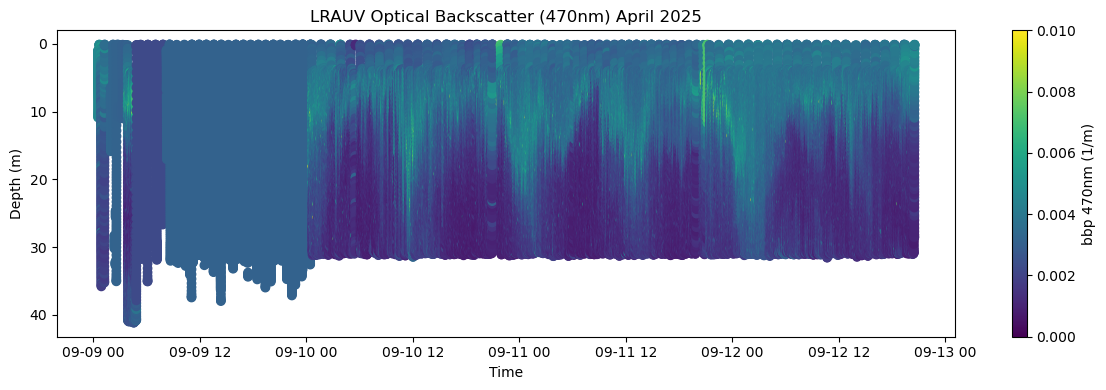

In [26]:

fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    labeled.index,labeled['depth'], c=labeled['particulatebackscatteringcoeff470nm'])
sc.set_clim(0, 0.01)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='bbp 470nm (1/m)')
plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()

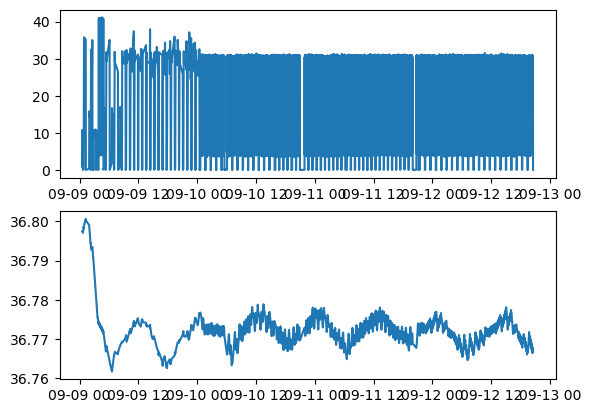

In [27]:
plt.subplot(2,1,1)
plt.plot(labeled.index, labeled['depth'])
plt.subplot(2,1,2)
plt.plot(labeled.index, labeled['latitude'])

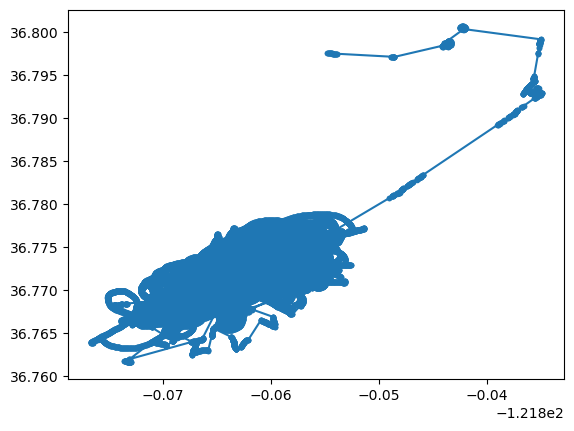

In [28]:
plt.plot(labeled['longitude'], labeled['latitude'],'.-')

In [29]:
df.keys()

Index(['fileName', 'dateStr', 'dateTime'], dtype='object')

In [30]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'bin_mean_mass_concentration_of_chlorophyll_in_sea_water',
       'bin_median_mass_concentration_of_chlorophyll_in_sea_water',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km'],
      dtype='object')

How this works and how we need to attempt to fix this issue.
1) The labled data frame contains the vehicle data
2) df contains the file name data (i.e. names for the ROI from the name.parquet file)
This maps the df data into the bin_codes but there is no indication that the planktivore camera was on or off in this data set. 
If the camera was off, then not files but if no valid ROIS, also no files.
Henry also want to compute some sort of volume/time for these.
If we load the camera log data into a dataframe can we use Patrick's trick to get the "bin_codes" below for the log data?
What happens if there is no log data during a period of time?

In [31]:
import sys
sys.path.append('c:/planktivore_code/')
import glob
from decode_pvtr_camlog import DualMagLog
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
#
# file name is something like YYYY-MM-DD-HH-MM-SS.SSSSS.log
mypath='y:/2025-09-08-LRAH-35/'
#mypath='y:/2025-04-14-LRAH-27/'
extension='*.log'
filelist=glob.glob(os.path.join(mypath,'**',extension),recursive=True)
filelist=sorted(filelist)
nf=np.arange(0,len(filelist))
for mf in nf:
    instance=DualMagLog(filelist[mf])
    data=instance.parse_lines()
    tmpdf=instance.export('CANON_Sep2025.csv')
    if mf==0:
        camdf=tmpdf
    else:
        camdf=pd.concat([camdf,tmpdf],ignore_index=True)

2026-01-22 07:04:00.788 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757052837
2026-01-22 07:04:00.789 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757052837
2026-01-22 07:04:00.790 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757052837
2026-01-22 07:04:00.790 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757052837
2026-01-22 07:04:00.791 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757052837
2026-01-22 07:04:00.791 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757052837
2026-01-22 07:04:00.792 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757052838
2026-01-22 07:04:00.793 | INFO     | decode_pvtr_camlog:parse_lines:159 -

time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-09-04 23:13:57.287000
2025-09-04 23:13:57.287000
2025-09-04 23:13:57.612000
2025-09-04 23:13:57.612000
2025-09-04 23:13:57.926000
2025-09-04 23:13:57.926000
2025-09-04 23:13:58.250000
2025-09-04 23:13:58.250000
2025-09-04 23:13:58.575000
2025-09-04 23:13:58.575000
2025-09-04 23:13:58.907000
2025-09-04 23:13:58.907000
2025-09-04 23:13:59.223000
2025-09-04 23:13:59.223000
2025-09-04 23:13:59.538000
2025-09-04 23:13:59.538000
2025-09-04 23:13:59.863000
2025-09-04 23:13:59.863000
2025-09-04 23:14:00.190000
2025-09-04 23:14:00.190000
2025-09-04 23:14:00.510000
2025-09-04 23:14:00.510000
2025-09-04 23:14:00.827000
2025-09-04 23:14:00.827000
2025-09-04 23:16:27.228000
2025-09-04 23:16:27.228000
2025-09-04 23:16:27.553000
2025-09-04 23:16:27.553000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:04:03.772 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757488716
2026-01-22 07:04:03.772 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757488716
2026-01-22 07:04:03.773 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757488716
2026-01-22 07:04:03.774 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757488716
2026-01-22 07:04:03.774 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757488716
2026-01-22 07:04:03.775 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757488716
2026-01-22 07:04:03.775 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757488717
2026-01-22 07:04:03.776 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-10 00:18:36.315000
2025-09-10 00:18:36.315000
2025-09-10 00:18:36.640000
2025-09-10 00:18:36.640000
2025-09-10 00:18:36.964000
2025-09-10 00:18:36.964000
2025-09-10 00:18:37.279000
2025-09-10 00:18:37.279000
2025-09-10 00:18:37.605000
2025-09-10 00:18:37.605000
2025-09-10 00:18:37.932000
2025-09-10 00:18:37.932000
2025-09-10 00:18:38.261000
2025-09-10 00:18:38.261000
2025-09-10 00:18:38.575000
2025-09-10 00:18:38.575000
2025-09-10 00:18:38.899000
2025-09-10 00:18:38.899000
2025-09-10 00:18:39.226000
2025-09-10 00:18:39.226000
2025-09-10 00:18:39.560000
2025-09-10 00:18:39.560000
2025-09-10 00:18:39.875000
2025-09-10 00:18:39.875000
2025-09-10 00:25:14.267000
2025-09-10 00:25:14.592000
2025-09-10 00:25:14.918000
2025-09-10 00:25:15.233000
2025-09-10 00:25:15.558000
2025-09-10 00:25:15.878000


2026-01-22 07:04:04.007 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3987, could not find matching low_mag time: 1757490002
2026-01-22 07:04:04.008 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3987, could not find high_mag matching time: 1757490002
2026-01-22 07:04:04.009 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3988, could not find matching low_mag time: 1757490002
2026-01-22 07:04:04.009 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3988, could not find high_mag matching time: 1757490002
2026-01-22 07:04:04.010 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3989, could not find matching low_mag time: 1757490002
2026-01-22 07:04:04.010 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3989, could not find high_mag matching time: 1757490002
2026-01-22 07:04:04.187 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7246, could not find high_mag matching time: 1757491053
2026-01-22 07:04:04.188 | INFO     | decode_pvtr_ca

2025-09-10 00:40:02.061000
2025-09-10 00:40:02.061000
2025-09-10 00:40:02.387000
2025-09-10 00:40:02.387000
2025-09-10 00:40:02.701000
2025-09-10 00:40:02.701000
2025-09-10 00:57:33.027000
2025-09-10 00:57:33.353000
2025-09-10 00:57:33.668000
2025-09-10 00:57:33.993000
2025-09-10 00:57:34.319000


2026-01-22 07:04:04.191 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7251, could not find matching low_mag time: 1757491054
2026-01-22 07:04:04.192 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7252, could not find matching low_mag time: 1757491054
2026-01-22 07:04:04.378 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10645, could not find high_mag matching time: 1757492149


2025-09-10 00:57:34.637000
2025-09-10 00:57:34.963000
2025-09-10 01:15:49.133000


2026-01-22 07:04:04.379 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10646, could not find high_mag matching time: 1757492149
2026-01-22 07:04:04.379 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10647, could not find high_mag matching time: 1757492149
2026-01-22 07:04:04.380 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10648, could not find matching low_mag time: 1757492150
2026-01-22 07:04:04.381 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10649, could not find matching low_mag time: 1757492150
2026-01-22 07:04:04.382 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10650, could not find matching low_mag time: 1757492150
2026-01-22 07:04:04.555 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13898, could not find high_mag matching time: 1757493198
2026-01-22 07:04:04.556 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13899, could not find high_mag matching time: 1757493198
2026-01-22 07:04:04.557 | INFO     | decode_

2025-09-10 01:15:49.458000
2025-09-10 01:15:49.782000
2025-09-10 01:15:50.110000
2025-09-10 01:15:50.435000
2025-09-10 01:15:50.749000
2025-09-10 01:33:18.170000
2025-09-10 01:33:18.497000
2025-09-10 01:33:18.814000
2025-09-10 01:33:19.139000
2025-09-10 01:33:19.455000
2025-09-10 01:33:19.781000


2026-01-22 07:04:04.735 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17129, could not find matching low_mag time: 1757494240
2026-01-22 07:04:04.735 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17129, could not find high_mag matching time: 1757494240
2026-01-22 07:04:04.736 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17130, could not find matching low_mag time: 1757494240
2026-01-22 07:04:04.736 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17130, could not find high_mag matching time: 1757494240
2026-01-22 07:04:04.737 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17131, could not find matching low_mag time: 1757494240
2026-01-22 07:04:04.738 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17131, could not find high_mag matching time: 1757494240
2026-01-22 07:04:04.914 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20453, could not find matching low_mag time: 1757495312


2025-09-10 01:50:40.113000
2025-09-10 01:50:40.113000
2025-09-10 01:50:40.433000
2025-09-10 01:50:40.433000
2025-09-10 01:50:40.751000
2025-09-10 01:50:40.751000
2025-09-10 02:08:32.037000


2026-01-22 07:04:04.915 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20453, could not find high_mag matching time: 1757495312
2026-01-22 07:04:04.916 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20454, could not find matching low_mag time: 1757495312
2026-01-22 07:04:04.916 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20454, could not find high_mag matching time: 1757495312
2026-01-22 07:04:04.917 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20455, could not find matching low_mag time: 1757495312
2026-01-22 07:04:04.918 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20455, could not find high_mag matching time: 1757495312
2026-01-22 07:04:05.098 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23765, could not find matching low_mag time: 1757496380


2025-09-10 02:08:32.037000
2025-09-10 02:08:32.363000
2025-09-10 02:08:32.363000
2025-09-10 02:08:32.679000
2025-09-10 02:08:32.679000
2025-09-10 02:26:20.088000
2025-09-10 02:26:20.088000


2026-01-22 07:04:05.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23765, could not find high_mag matching time: 1757496380
2026-01-22 07:04:05.100 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23766, could not find matching low_mag time: 1757496380
2026-01-22 07:04:05.100 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23766, could not find high_mag matching time: 1757496380
2026-01-22 07:04:05.101 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23767, could not find matching low_mag time: 1757496380
2026-01-22 07:04:05.102 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23767, could not find high_mag matching time: 1757496380
2026-01-22 07:04:05.277 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27034, could not find matching low_mag time: 1757497434
2026-01-22 07:04:05.278 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27034, could not find high_mag matching time: 1757497434
2026-01-22 07:04:05.279 | INFO     | decode_

2025-09-10 02:26:20.413000
2025-09-10 02:26:20.413000
2025-09-10 02:26:20.728000
2025-09-10 02:26:20.728000
2025-09-10 02:43:54.275000
2025-09-10 02:43:54.275000
2025-09-10 02:43:54.594000
2025-09-10 02:43:54.594000
2025-09-10 02:43:54.920000
2025-09-10 02:43:54.920000


2026-01-22 07:04:05.454 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30221, could not find matching low_mag time: 1757498462
2026-01-22 07:04:05.455 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30221, could not find high_mag matching time: 1757498462
2026-01-22 07:04:05.455 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30222, could not find matching low_mag time: 1757498462
2026-01-22 07:04:05.456 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30222, could not find high_mag matching time: 1757498462
2026-01-22 07:04:05.457 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30223, could not find matching low_mag time: 1757498462
2026-01-22 07:04:05.457 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30223, could not find high_mag matching time: 1757498462
2026-01-22 07:04:05.458 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30224, could not find matching low_mag time: 1757498462
2026-01-22 07:04:05.458 | INFO     | decode_p

2025-09-10 03:01:02.027000
2025-09-10 03:01:02.027000
2025-09-10 03:01:02.343000
2025-09-10 03:01:02.343000
2025-09-10 03:01:02.669000
2025-09-10 03:01:02.669000
2025-09-10 03:01:02.994000
2025-09-10 03:01:02.994000
2025-09-10 03:18:19.129000


2026-01-22 07:04:05.632 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33437, could not find high_mag matching time: 1757499499
2026-01-22 07:04:05.632 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33438, could not find matching low_mag time: 1757499499
2026-01-22 07:04:05.633 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33438, could not find high_mag matching time: 1757499499
2026-01-22 07:04:05.634 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33439, could not find matching low_mag time: 1757499499
2026-01-22 07:04:05.634 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33439, could not find high_mag matching time: 1757499499
2026-01-22 07:04:05.815 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36799, could not find high_mag matching time: 1757500583


2025-09-10 03:18:19.129000
2025-09-10 03:18:19.445000
2025-09-10 03:18:19.445000
2025-09-10 03:18:19.770000
2025-09-10 03:18:19.770000
2025-09-10 03:36:23.301000


2026-01-22 07:04:05.816 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36800, could not find high_mag matching time: 1757500583
2026-01-22 07:04:05.818 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36801, could not find high_mag matching time: 1757500583
2026-01-22 07:04:05.818 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36802, could not find matching low_mag time: 1757500584
2026-01-22 07:04:05.819 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36803, could not find matching low_mag time: 1757500584
2026-01-22 07:04:05.820 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36804, could not find matching low_mag time: 1757500584
2026-01-22 07:04:05.992 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40039, could not find high_mag matching time: 1757501628
2026-01-22 07:04:05.992 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40040, could not find high_mag matching time: 1757501628
2026-01-22 07:04:05.993 | INFO     | decode_

2025-09-10 03:36:23.625000
2025-09-10 03:36:23.950000
2025-09-10 03:36:24.267000
2025-09-10 03:36:24.592000
2025-09-10 03:36:24.916000
2025-09-10 03:53:48.144000
2025-09-10 03:53:48.469000
2025-09-10 03:53:48.785000
2025-09-10 03:53:49.110000
2025-09-10 03:53:49.435000
2025-09-10 03:53:49.750000


2026-01-22 07:04:06.179 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43326, could not find high_mag matching time: 1757502688
2026-01-22 07:04:06.180 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43327, could not find high_mag matching time: 1757502688
2026-01-22 07:04:06.181 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43328, could not find high_mag matching time: 1757502688
2026-01-22 07:04:06.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43329, could not find matching low_mag time: 1757502689
2026-01-22 07:04:06.183 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43330, could not find matching low_mag time: 1757502689
2026-01-22 07:04:06.183 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43331, could not find matching low_mag time: 1757502689
2026-01-22 07:04:06.363 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46656, could not find high_mag matching time: 1757503762


2025-09-10 04:11:28.145000
2025-09-10 04:11:28.470000
2025-09-10 04:11:28.797000
2025-09-10 04:11:29.112000
2025-09-10 04:11:29.437000
2025-09-10 04:11:29.763000
2025-09-10 04:29:22


2026-01-22 07:04:06.363 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46657, could not find high_mag matching time: 1757503762
2026-01-22 07:04:06.364 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46658, could not find high_mag matching time: 1757503762
2026-01-22 07:04:06.365 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46659, could not find high_mag matching time: 1757503762
2026-01-22 07:04:06.365 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46660, could not find matching low_mag time: 1757503763
2026-01-22 07:04:06.366 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46661, could not find matching low_mag time: 1757503763
2026-01-22 07:04:06.367 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46662, could not find matching low_mag time: 1757503763
2026-01-22 07:04:06.537 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49813, could not find high_mag matching time: 1757504780
2026-01-22 07:04:06.537 | INFO     | decode_

2025-09-10 04:29:22.326000
2025-09-10 04:29:22.640000
2025-09-10 04:29:22.966000
2025-09-10 04:29:23.292000
2025-09-10 04:29:23.607000
2025-09-10 04:29:23.932000
2025-09-10 04:46:20.075000
2025-09-10 04:46:20.401000
2025-09-10 04:46:20.727000
2025-09-10 04:46:21.043000
2025-09-10 04:46:21.368000
2025-09-10 04:46:21.694000


2026-01-22 07:04:06.715 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53075, could not find high_mag matching time: 1757505832
2026-01-22 07:04:06.716 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53076, could not find high_mag matching time: 1757505832
2026-01-22 07:04:06.717 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53077, could not find high_mag matching time: 1757505832
2026-01-22 07:04:06.717 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53078, could not find high_mag matching time: 1757505832
2026-01-22 07:04:06.718 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53079, could not find matching low_mag time: 1757505833
2026-01-22 07:04:06.718 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53080, could not find matching low_mag time: 1757505833
2026-01-22 07:04:06.719 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53081, could not find matching low_mag time: 1757505833
2026-01-22 07:04:06.809 | INFO     | decode_

2025-09-10 05:03:52
2025-09-10 05:03:52.326000
2025-09-10 05:03:52.651000
2025-09-10 05:03:52.966000
2025-09-10 05:03:53.302000
2025-09-10 05:03:53.617000
2025-09-10 05:03:53.943000
2025-09-10 05:12:57.323000
2025-09-10 05:12:57.323000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:04:13.075 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757508160
2026-01-22 07:04:13.076 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757508160
2026-01-22 07:04:13.077 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757508160
2026-01-22 07:04:13.078 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757508160
2026-01-22 07:04:13.078 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757508160
2026-01-22 07:04:13.079 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757508160
2026-01-22 07:04:13.080 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757508161
2026-01-22 07:04:13.081 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-10 05:42:40.208000
2025-09-10 05:42:40.208000
2025-09-10 05:42:40.525000
2025-09-10 05:42:40.525000
2025-09-10 05:42:40.860000
2025-09-10 05:42:40.860000
2025-09-10 05:42:41.233000
2025-09-10 05:42:41.233000
2025-09-10 05:42:41.505000
2025-09-10 05:42:41.505000
2025-09-10 05:42:41.832000
2025-09-10 05:42:41.832000
2025-09-10 05:42:42.146000
2025-09-10 05:42:42.146000
2025-09-10 05:42:42.470000
2025-09-10 05:42:42.470000
2025-09-10 05:42:42.797000
2025-09-10 05:42:42.797000
2025-09-10 05:42:43.151000
2025-09-10 05:42:43.151000
2025-09-10 05:42:43.438000
2025-09-10 05:42:43.438000
2025-09-10 05:42:43.756000
2025-09-10 05:42:43.756000
2025-09-10 05:51:16.174000
2025-09-10 05:51:16.174000


2026-01-22 07:04:13.261 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1600, could not find high_mag matching time: 1757508676
2026-01-22 07:04:13.262 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1601, could not find matching low_mag time: 1757508676
2026-01-22 07:04:13.263 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1601, could not find high_mag matching time: 1757508676
2026-01-22 07:04:13.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1602, could not find matching low_mag time: 1757508676
2026-01-22 07:04:13.264 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1602, could not find high_mag matching time: 1757508676


2025-09-10 05:51:16.510000
2025-09-10 05:51:16.510000
2025-09-10 05:51:16.825000
2025-09-10 05:51:16.825000


2026-01-22 07:04:13.454 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3402, could not find matching low_mag time: 1757509257
2026-01-22 07:04:13.455 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3402, could not find high_mag matching time: 1757509257
2026-01-22 07:04:13.456 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3403, could not find matching low_mag time: 1757509257
2026-01-22 07:04:13.457 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3403, could not find high_mag matching time: 1757509257
2026-01-22 07:04:13.458 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3404, could not find matching low_mag time: 1757509257
2026-01-22 07:04:13.458 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3404, could not find high_mag matching time: 1757509257


2025-09-10 06:00:57.288000
2025-09-10 06:00:57.288000
2025-09-10 06:00:57.603000
2025-09-10 06:00:57.603000
2025-09-10 06:00:57.928000
2025-09-10 06:00:57.928000


2026-01-22 07:04:13.782 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6481, could not find matching low_mag time: 1757510250
2026-01-22 07:04:13.783 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6481, could not find high_mag matching time: 1757510250
2026-01-22 07:04:13.783 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6482, could not find matching low_mag time: 1757510250
2026-01-22 07:04:13.784 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6482, could not find high_mag matching time: 1757510250
2026-01-22 07:04:13.785 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6483, could not find matching low_mag time: 1757510250
2026-01-22 07:04:13.785 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6483, could not find high_mag matching time: 1757510250


2025-09-10 06:17:30.221000
2025-09-10 06:17:30.221000
2025-09-10 06:17:30.537000
2025-09-10 06:17:30.537000
2025-09-10 06:17:30.862000
2025-09-10 06:17:30.862000


2026-01-22 07:04:14.145 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9839, could not find matching low_mag time: 1757511333
2026-01-22 07:04:14.146 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9839, could not find high_mag matching time: 1757511333
2026-01-22 07:04:14.147 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9840, could not find matching low_mag time: 1757511333
2026-01-22 07:04:14.147 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9840, could not find high_mag matching time: 1757511333
2026-01-22 07:04:14.148 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9841, could not find matching low_mag time: 1757511333
2026-01-22 07:04:14.148 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9841, could not find high_mag matching time: 1757511333


2025-09-10 06:35:33.109000
2025-09-10 06:35:33.109000
2025-09-10 06:35:33.425000
2025-09-10 06:35:33.425000
2025-09-10 06:35:33.750000
2025-09-10 06:35:33.750000


2026-01-22 07:04:14.500 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13086, could not find high_mag matching time: 1757512380
2026-01-22 07:04:14.501 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13087, could not find high_mag matching time: 1757512380
2026-01-22 07:04:14.502 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13088, could not find high_mag matching time: 1757512380
2026-01-22 07:04:14.503 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13089, could not find matching low_mag time: 1757512381
2026-01-22 07:04:14.503 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13090, could not find matching low_mag time: 1757512381
2026-01-22 07:04:14.504 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13091, could not find matching low_mag time: 1757512381


2025-09-10 06:53:00.197000
2025-09-10 06:53:00.522000
2025-09-10 06:53:00.849000
2025-09-10 06:53:01.166000
2025-09-10 06:53:01.495000
2025-09-10 06:53:01.811000


2026-01-22 07:04:14.840 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16292, could not find matching low_mag time: 1757513414
2026-01-22 07:04:14.841 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16292, could not find high_mag matching time: 1757513414
2026-01-22 07:04:14.842 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16293, could not find matching low_mag time: 1757513414
2026-01-22 07:04:14.842 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16293, could not find high_mag matching time: 1757513414
2026-01-22 07:04:14.843 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16294, could not find matching low_mag time: 1757513414
2026-01-22 07:04:14.844 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16294, could not find high_mag matching time: 1757513414


2025-09-10 07:10:14.071000
2025-09-10 07:10:14.071000
2025-09-10 07:10:14.398000
2025-09-10 07:10:14.398000
2025-09-10 07:10:14.713000
2025-09-10 07:10:14.713000


2026-01-22 07:04:15.183 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19468, could not find matching low_mag time: 1757514438
2026-01-22 07:04:15.184 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19468, could not find high_mag matching time: 1757514438
2026-01-22 07:04:15.185 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19469, could not find matching low_mag time: 1757514438
2026-01-22 07:04:15.186 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19469, could not find high_mag matching time: 1757514438
2026-01-22 07:04:15.186 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19470, could not find matching low_mag time: 1757514438
2026-01-22 07:04:15.187 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19470, could not find high_mag matching time: 1757514438


2025-09-10 07:27:18.265000
2025-09-10 07:27:18.265000
2025-09-10 07:27:18.590000
2025-09-10 07:27:18.590000
2025-09-10 07:27:18.906000
2025-09-10 07:27:18.906000


2026-01-22 07:04:15.536 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22748, could not find matching low_mag time: 1757515496
2026-01-22 07:04:15.536 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22748, could not find high_mag matching time: 1757515496
2026-01-22 07:04:15.537 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22749, could not find matching low_mag time: 1757515496
2026-01-22 07:04:15.538 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22749, could not find high_mag matching time: 1757515496
2026-01-22 07:04:15.538 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22750, could not find matching low_mag time: 1757515496
2026-01-22 07:04:15.540 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22750, could not find high_mag matching time: 1757515496
2026-01-22 07:04:15.541 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22751, could not find matching low_mag time: 1757515496
2026-01-22 07:04:15.541 | INFO     | decode_p

2025-09-10 07:44:56.020000
2025-09-10 07:44:56.020000
2025-09-10 07:44:56.335000
2025-09-10 07:44:56.335000
2025-09-10 07:44:56.662000
2025-09-10 07:44:56.662000
2025-09-10 07:44:56.987000
2025-09-10 07:44:56.987000


2026-01-22 07:04:15.878 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25961, could not find high_mag matching time: 1757516532
2026-01-22 07:04:15.879 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25962, could not find high_mag matching time: 1757516532
2026-01-22 07:04:15.880 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25963, could not find high_mag matching time: 1757516532
2026-01-22 07:04:15.880 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25964, could not find matching low_mag time: 1757516533
2026-01-22 07:04:15.881 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25965, could not find matching low_mag time: 1757516533
2026-01-22 07:04:15.882 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25966, could not find matching low_mag time: 1757516533


2025-09-10 08:02:12.152000
2025-09-10 08:02:12.466000
2025-09-10 08:02:12.792000
2025-09-10 08:02:13.117000
2025-09-10 08:02:13.433000
2025-09-10 08:02:13.759000


2026-01-22 07:04:16.222 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29189, could not find matching low_mag time: 1757517573
2026-01-22 07:04:16.223 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29189, could not find high_mag matching time: 1757517573
2026-01-22 07:04:16.224 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29190, could not find matching low_mag time: 1757517573
2026-01-22 07:04:16.225 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29190, could not find high_mag matching time: 1757517573
2026-01-22 07:04:16.225 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29191, could not find matching low_mag time: 1757517573
2026-01-22 07:04:16.226 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29191, could not find high_mag matching time: 1757517573


2025-09-10 08:19:33.110000
2025-09-10 08:19:33.110000
2025-09-10 08:19:33.437000
2025-09-10 08:19:33.437000
2025-09-10 08:19:33.762000
2025-09-10 08:19:33.762000


2026-01-22 07:04:16.564 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32371, could not find matching low_mag time: 1757518599
2026-01-22 07:04:16.564 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32371, could not find high_mag matching time: 1757518599
2026-01-22 07:04:16.565 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32372, could not find matching low_mag time: 1757518599
2026-01-22 07:04:16.566 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32372, could not find high_mag matching time: 1757518599
2026-01-22 07:04:16.566 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32373, could not find matching low_mag time: 1757518599
2026-01-22 07:04:16.567 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32373, could not find high_mag matching time: 1757518599


2025-09-10 08:36:39.248000
2025-09-10 08:36:39.248000
2025-09-10 08:36:39.573000
2025-09-10 08:36:39.573000
2025-09-10 08:36:39.898000
2025-09-10 08:36:39.898000


2026-01-22 07:04:16.892 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35444, could not find matching low_mag time: 1757519590
2026-01-22 07:04:16.893 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35444, could not find high_mag matching time: 1757519590
2026-01-22 07:04:16.894 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35445, could not find matching low_mag time: 1757519590
2026-01-22 07:04:16.895 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35445, could not find high_mag matching time: 1757519590
2026-01-22 07:04:16.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35446, could not find matching low_mag time: 1757519590
2026-01-22 07:04:16.896 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35446, could not find high_mag matching time: 1757519590


2025-09-10 08:53:10.236000
2025-09-10 08:53:10.236000
2025-09-10 08:53:10.552000
2025-09-10 08:53:10.552000
2025-09-10 08:53:10.878000
2025-09-10 08:53:10.878000


2026-01-22 07:04:17.220 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38470, could not find matching low_mag time: 1757520566
2026-01-22 07:04:17.222 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38470, could not find high_mag matching time: 1757520566
2026-01-22 07:04:17.222 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38471, could not find matching low_mag time: 1757520566
2026-01-22 07:04:17.223 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38471, could not find high_mag matching time: 1757520566
2026-01-22 07:04:17.223 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38472, could not find matching low_mag time: 1757520566
2026-01-22 07:04:17.224 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38472, could not find high_mag matching time: 1757520566


2025-09-10 09:09:26.062000
2025-09-10 09:09:26.062000
2025-09-10 09:09:26.377000
2025-09-10 09:09:26.377000
2025-09-10 09:09:26.703000
2025-09-10 09:09:26.703000


2026-01-22 07:04:17.556 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41528, could not find matching low_mag time: 1757521552
2026-01-22 07:04:17.557 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41528, could not find high_mag matching time: 1757521552
2026-01-22 07:04:17.558 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41529, could not find matching low_mag time: 1757521552
2026-01-22 07:04:17.559 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41529, could not find high_mag matching time: 1757521552
2026-01-22 07:04:17.560 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41530, could not find matching low_mag time: 1757521552
2026-01-22 07:04:17.560 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41530, could not find high_mag matching time: 1757521552


2025-09-10 09:25:52.203000
2025-09-10 09:25:52.203000
2025-09-10 09:25:52.528000
2025-09-10 09:25:52.528000
2025-09-10 09:25:52.854000
2025-09-10 09:25:52.854000


2026-01-22 07:04:17.917 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44756, could not find high_mag matching time: 1757522593
2026-01-22 07:04:17.918 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44757, could not find high_mag matching time: 1757522593
2026-01-22 07:04:17.919 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44758, could not find high_mag matching time: 1757522593
2026-01-22 07:04:17.919 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44759, could not find matching low_mag time: 1757522594
2026-01-22 07:04:17.920 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44760, could not find matching low_mag time: 1757522594
2026-01-22 07:04:17.920 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44761, could not find matching low_mag time: 1757522594


2025-09-10 09:43:13.178000
2025-09-10 09:43:13.503000
2025-09-10 09:43:13.818000
2025-09-10 09:43:14.144000
2025-09-10 09:43:14.459000
2025-09-10 09:43:14.784000


2026-01-22 07:04:18.256 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47959, could not find matching low_mag time: 1757523626
2026-01-22 07:04:18.256 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47959, could not find high_mag matching time: 1757523626
2026-01-22 07:04:18.257 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47960, could not find matching low_mag time: 1757523626
2026-01-22 07:04:18.257 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47960, could not find high_mag matching time: 1757523626
2026-01-22 07:04:18.258 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47961, could not find matching low_mag time: 1757523626
2026-01-22 07:04:18.259 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47961, could not find high_mag matching time: 1757523626


2025-09-10 10:00:26.085000
2025-09-10 10:00:26.085000
2025-09-10 10:00:26.410000
2025-09-10 10:00:26.410000
2025-09-10 10:00:26.726000
2025-09-10 10:00:26.726000


2026-01-22 07:04:18.594 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51097, could not find matching low_mag time: 1757524638
2026-01-22 07:04:18.595 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51097, could not find high_mag matching time: 1757524638
2026-01-22 07:04:18.596 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51098, could not find matching low_mag time: 1757524638
2026-01-22 07:04:18.596 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51098, could not find high_mag matching time: 1757524638
2026-01-22 07:04:18.597 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51099, could not find matching low_mag time: 1757524638
2026-01-22 07:04:18.598 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51099, could not find high_mag matching time: 1757524638


2025-09-10 10:17:18.038000
2025-09-10 10:17:18.038000
2025-09-10 10:17:18.353000
2025-09-10 10:17:18.353000
2025-09-10 10:17:18.679000
2025-09-10 10:17:18.679000


2026-01-22 07:04:18.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54208, could not find high_mag matching time: 1757525641
2026-01-22 07:04:18.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54209, could not find high_mag matching time: 1757525641
2026-01-22 07:04:18.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54210, could not find high_mag matching time: 1757525641
2026-01-22 07:04:18.936 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54211, could not find matching low_mag time: 1757525642
2026-01-22 07:04:18.937 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54212, could not find matching low_mag time: 1757525642
2026-01-22 07:04:18.938 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54213, could not find matching low_mag time: 1757525642


2025-09-10 10:34:01.265000
2025-09-10 10:34:01.590000
2025-09-10 10:34:01.916000
2025-09-10 10:34:02.230000
2025-09-10 10:34:02.558000
2025-09-10 10:34:02.883000


2026-01-22 07:04:19.270 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57327, could not find high_mag matching time: 1757526647
2026-01-22 07:04:19.270 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57328, could not find high_mag matching time: 1757526647
2026-01-22 07:04:19.271 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57329, could not find high_mag matching time: 1757526647
2026-01-22 07:04:19.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57330, could not find matching low_mag time: 1757526648
2026-01-22 07:04:19.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57331, could not find matching low_mag time: 1757526648
2026-01-22 07:04:19.273 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57332, could not find matching low_mag time: 1757526648


2025-09-10 10:50:47.095000
2025-09-10 10:50:47.411000
2025-09-10 10:50:47.736000
2025-09-10 10:50:48.062000
2025-09-10 10:50:48.377000
2025-09-10 10:50:48.703000


2026-01-22 07:04:19.594 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60406, could not find matching low_mag time: 1757527640
2026-01-22 07:04:19.594 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60406, could not find high_mag matching time: 1757527640
2026-01-22 07:04:19.595 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60407, could not find matching low_mag time: 1757527640
2026-01-22 07:04:19.595 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60407, could not find high_mag matching time: 1757527640
2026-01-22 07:04:19.596 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60408, could not find matching low_mag time: 1757527640
2026-01-22 07:04:19.596 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60408, could not find high_mag matching time: 1757527640
2026-01-22 07:04:19.597 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60409, could not find matching low_mag time: 1757527640
2026-01-22 07:04:19.598 | INFO     | decode_p

2025-09-10 11:07:20.006000
2025-09-10 11:07:20.006000
2025-09-10 11:07:20.331000
2025-09-10 11:07:20.331000
2025-09-10 11:07:20.650000
2025-09-10 11:07:20.650000
2025-09-10 11:07:20.976000
2025-09-10 11:07:20.976000


2026-01-22 07:04:19.941 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63588, could not find high_mag matching time: 1757528666
2026-01-22 07:04:19.943 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63589, could not find high_mag matching time: 1757528666
2026-01-22 07:04:19.943 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63590, could not find high_mag matching time: 1757528666
2026-01-22 07:04:19.944 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63591, could not find matching low_mag time: 1757528667
2026-01-22 07:04:19.945 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63592, could not find matching low_mag time: 1757528667
2026-01-22 07:04:19.945 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63593, could not find matching low_mag time: 1757528667


2025-09-10 11:24:26.147000
2025-09-10 11:24:26.463000
2025-09-10 11:24:26.789000
2025-09-10 11:24:27.115000
2025-09-10 11:24:27.430000
2025-09-10 11:24:27.756000


2026-01-22 07:04:20.279 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66729, could not find high_mag matching time: 1757529679
2026-01-22 07:04:20.280 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66730, could not find high_mag matching time: 1757529679
2026-01-22 07:04:20.281 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66731, could not find high_mag matching time: 1757529679
2026-01-22 07:04:20.281 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66732, could not find matching low_mag time: 1757529680
2026-01-22 07:04:20.282 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66733, could not find matching low_mag time: 1757529680
2026-01-22 07:04:20.282 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66734, could not find matching low_mag time: 1757529680
2026-01-22 07:04:20.283 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66735, could not find matching low_mag time: 1757529680


2025-09-10 11:41:19.048000
2025-09-10 11:41:19.374000
2025-09-10 11:41:19.701000
2025-09-10 11:41:20.016000
2025-09-10 11:41:20.343000
2025-09-10 11:41:20.663000
2025-09-10 11:41:20.989000


2026-01-22 07:04:20.625 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69964, could not find matching low_mag time: 1757530722
2026-01-22 07:04:20.626 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69964, could not find high_mag matching time: 1757530722
2026-01-22 07:04:20.627 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69965, could not find matching low_mag time: 1757530722
2026-01-22 07:04:20.627 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69965, could not find high_mag matching time: 1757530722
2026-01-22 07:04:20.628 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69966, could not find matching low_mag time: 1757530722
2026-01-22 07:04:20.629 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69966, could not find high_mag matching time: 1757530722


2025-09-10 11:58:42.276000
2025-09-10 11:58:42.276000
2025-09-10 11:58:42.601000
2025-09-10 11:58:42.601000
2025-09-10 11:58:42.916000
2025-09-10 11:58:42.916000


2026-01-22 07:04:20.952 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73034, could not find matching low_mag time: 1757531712
2026-01-22 07:04:20.953 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73034, could not find high_mag matching time: 1757531712
2026-01-22 07:04:20.954 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73035, could not find matching low_mag time: 1757531712
2026-01-22 07:04:20.954 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73035, could not find high_mag matching time: 1757531712
2026-01-22 07:04:20.955 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73036, could not find matching low_mag time: 1757531712
2026-01-22 07:04:20.956 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73036, could not find high_mag matching time: 1757531712


2025-09-10 12:15:12.303000
2025-09-10 12:15:12.303000
2025-09-10 12:15:12.629000
2025-09-10 12:15:12.629000
2025-09-10 12:15:12.954000
2025-09-10 12:15:12.954000


2026-01-22 07:04:21.294 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76228, could not find matching low_mag time: 1757532742
2026-01-22 07:04:21.296 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76228, could not find high_mag matching time: 1757532742
2026-01-22 07:04:21.296 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76229, could not find matching low_mag time: 1757532742
2026-01-22 07:04:21.297 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76229, could not find high_mag matching time: 1757532742
2026-01-22 07:04:21.298 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76230, could not find matching low_mag time: 1757532742
2026-01-22 07:04:21.298 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76230, could not find high_mag matching time: 1757532742


2025-09-10 12:32:22.310000
2025-09-10 12:32:22.310000
2025-09-10 12:32:22.626000
2025-09-10 12:32:22.626000
2025-09-10 12:32:22.961000
2025-09-10 12:32:22.961000


2026-01-22 07:04:21.635 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79446, could not find high_mag matching time: 1757533780
2026-01-22 07:04:21.635 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79447, could not find high_mag matching time: 1757533780
2026-01-22 07:04:21.636 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79448, could not find high_mag matching time: 1757533780
2026-01-22 07:04:21.637 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79449, could not find matching low_mag time: 1757533781
2026-01-22 07:04:21.638 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79450, could not find matching low_mag time: 1757533781
2026-01-22 07:04:21.638 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79451, could not find matching low_mag time: 1757533781
2026-01-22 07:04:21.639 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79452, could not find matching low_mag time: 1757533781


2025-09-10 12:49:40.055000
2025-09-10 12:49:40.381000
2025-09-10 12:49:40.696000
2025-09-10 12:49:41.022000
2025-09-10 12:49:41.347000
2025-09-10 12:49:41.664000
2025-09-10 12:49:41.989000


2026-01-22 07:04:21.979 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 82653, could not find matching low_mag time: 1757534814
2026-01-22 07:04:21.980 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 82653, could not find high_mag matching time: 1757534814
2026-01-22 07:04:21.980 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 82654, could not find matching low_mag time: 1757534814
2026-01-22 07:04:21.981 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 82654, could not find high_mag matching time: 1757534814
2026-01-22 07:04:21.981 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 82655, could not find matching low_mag time: 1757534814
2026-01-22 07:04:21.982 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 82655, could not find high_mag matching time: 1757534814


2025-09-10 13:06:54.245000
2025-09-10 13:06:54.245000
2025-09-10 13:06:54.563000
2025-09-10 13:06:54.563000
2025-09-10 13:06:54.888000
2025-09-10 13:06:54.888000


2026-01-22 07:04:22.318 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 85837, could not find matching low_mag time: 1757535841
2026-01-22 07:04:22.319 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 85837, could not find high_mag matching time: 1757535841
2026-01-22 07:04:22.320 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 85838, could not find matching low_mag time: 1757535841
2026-01-22 07:04:22.320 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 85838, could not find high_mag matching time: 1757535841
2026-01-22 07:04:22.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 85839, could not find matching low_mag time: 1757535841
2026-01-22 07:04:22.322 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 85839, could not find high_mag matching time: 1757535841
2026-01-22 07:04:22.322 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 85840, could not find matching low_mag time: 1757535841
2026-01-22 07:04:22.323 | INFO     | decode_p

2025-09-10 13:24:01.022000
2025-09-10 13:24:01.022000
2025-09-10 13:24:01.348000
2025-09-10 13:24:01.348000
2025-09-10 13:24:01.663000
2025-09-10 13:24:01.663000
2025-09-10 13:24:01.989000
2025-09-10 13:24:01.989000


2026-01-22 07:04:22.650 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 88923, could not find matching low_mag time: 1757536836
2026-01-22 07:04:22.650 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 88923, could not find high_mag matching time: 1757536836
2026-01-22 07:04:22.651 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 88924, could not find matching low_mag time: 1757536836
2026-01-22 07:04:22.652 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 88924, could not find high_mag matching time: 1757536836
2026-01-22 07:04:22.652 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 88925, could not find matching low_mag time: 1757536836
2026-01-22 07:04:22.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 88925, could not find high_mag matching time: 1757536836


2025-09-10 13:40:36.208000
2025-09-10 13:40:36.208000
2025-09-10 13:40:36.534000
2025-09-10 13:40:36.534000
2025-09-10 13:40:36.850000
2025-09-10 13:40:36.850000


2026-01-22 07:04:22.993 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92132, could not find matching low_mag time: 1757537871
2026-01-22 07:04:22.993 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92132, could not find high_mag matching time: 1757537871
2026-01-22 07:04:22.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92133, could not find matching low_mag time: 1757537871
2026-01-22 07:04:22.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92133, could not find high_mag matching time: 1757537871
2026-01-22 07:04:22.995 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92134, could not find matching low_mag time: 1757537871
2026-01-22 07:04:22.996 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92134, could not find high_mag matching time: 1757537871


2025-09-10 13:57:51.050000
2025-09-10 13:57:51.050000
2025-09-10 13:57:51.376000
2025-09-10 13:57:51.376000
2025-09-10 13:57:51.691000
2025-09-10 13:57:51.691000


2026-01-22 07:04:23.326 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 95295, could not find matching low_mag time: 1757538891
2026-01-22 07:04:23.326 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 95295, could not find high_mag matching time: 1757538891
2026-01-22 07:04:23.327 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 95296, could not find matching low_mag time: 1757538891
2026-01-22 07:04:23.328 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 95296, could not find high_mag matching time: 1757538891
2026-01-22 07:04:23.329 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 95297, could not find matching low_mag time: 1757538891
2026-01-22 07:04:23.330 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 95297, could not find high_mag matching time: 1757538891


2025-09-10 14:14:51.043000
2025-09-10 14:14:51.043000
2025-09-10 14:14:51.369000
2025-09-10 14:14:51.369000
2025-09-10 14:14:51.694000
2025-09-10 14:14:51.694000


2026-01-22 07:04:23.654 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 98387, could not find matching low_mag time: 1757539888
2026-01-22 07:04:23.655 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 98387, could not find high_mag matching time: 1757539888
2026-01-22 07:04:23.656 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 98388, could not find matching low_mag time: 1757539888
2026-01-22 07:04:23.657 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 98388, could not find high_mag matching time: 1757539888
2026-01-22 07:04:23.657 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 98389, could not find matching low_mag time: 1757539888
2026-01-22 07:04:23.658 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 98389, could not find high_mag matching time: 1757539888


2025-09-10 14:31:28.164000
2025-09-10 14:31:28.164000
2025-09-10 14:31:28.489000
2025-09-10 14:31:28.489000
2025-09-10 14:31:28.815000
2025-09-10 14:31:28.815000


2026-01-22 07:04:23.991 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 101528, could not find matching low_mag time: 1757540901
2026-01-22 07:04:23.992 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 101528, could not find high_mag matching time: 1757540901
2026-01-22 07:04:23.993 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 101529, could not find matching low_mag time: 1757540901
2026-01-22 07:04:23.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 101529, could not find high_mag matching time: 1757540901
2026-01-22 07:04:23.995 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 101530, could not find matching low_mag time: 1757540901
2026-01-22 07:04:23.995 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 101530, could not find high_mag matching time: 1757540901


2025-09-10 14:48:21.072000
2025-09-10 14:48:21.072000
2025-09-10 14:48:21.398000
2025-09-10 14:48:21.398000
2025-09-10 14:48:21.714000
2025-09-10 14:48:21.714000


2026-01-22 07:04:24.340 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 104800, could not find matching low_mag time: 1757541956
2026-01-22 07:04:24.341 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 104800, could not find high_mag matching time: 1757541956
2026-01-22 07:04:24.341 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 104801, could not find matching low_mag time: 1757541956
2026-01-22 07:04:24.342 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 104801, could not find high_mag matching time: 1757541956
2026-01-22 07:04:24.343 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 104802, could not find matching low_mag time: 1757541956
2026-01-22 07:04:24.344 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 104802, could not find high_mag matching time: 1757541956


2025-09-10 15:05:56.240000
2025-09-10 15:05:56.240000
2025-09-10 15:05:56.566000
2025-09-10 15:05:56.566000
2025-09-10 15:05:56.886000
2025-09-10 15:05:56.886000


2026-01-22 07:04:24.675 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107957, could not find matching low_mag time: 1757542974
2026-01-22 07:04:24.676 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107957, could not find high_mag matching time: 1757542974
2026-01-22 07:04:24.677 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107958, could not find matching low_mag time: 1757542974
2026-01-22 07:04:24.677 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107958, could not find high_mag matching time: 1757542974
2026-01-22 07:04:24.678 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107959, could not find matching low_mag time: 1757542974
2026-01-22 07:04:24.679 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107959, could not find high_mag matching time: 1757542974
2026-01-22 07:04:24.884 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109885, could not find matching low_mag time: 1757543596


2025-09-10 15:22:54.310000
2025-09-10 15:22:54.310000
2025-09-10 15:22:54.636000
2025-09-10 15:22:54.636000
2025-09-10 15:22:54.952000
2025-09-10 15:22:54.952000
2025-09-10 15:33:16.049000


2026-01-22 07:04:24.885 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 109885, could not find high_mag matching time: 1757543596
2026-01-22 07:04:24.886 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109886, could not find matching low_mag time: 1757543596
2026-01-22 07:04:24.886 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 109886, could not find high_mag matching time: 1757543596


2025-09-10 15:33:16.049000
2025-09-10 15:33:16.364000
2025-09-10 15:33:16.364000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:04:28.123 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757543826
2026-01-22 07:04:28.124 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757543826
2026-01-22 07:04:28.124 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757543826
2026-01-22 07:04:28.125 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757543826
2026-01-22 07:04:28.126 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757543826
2026-01-22 07:04:28.126 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757543826
2026-01-22 07:04:28.127 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757543827
2026-01-22 07:04:28.127 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-10 15:37:06.201000
2025-09-10 15:37:06.201000
2025-09-10 15:37:06.526000
2025-09-10 15:37:06.526000
2025-09-10 15:37:06.901000
2025-09-10 15:37:06.901000
2025-09-10 15:37:07.175000
2025-09-10 15:37:07.175000
2025-09-10 15:37:07.499000
2025-09-10 15:37:07.499000
2025-09-10 15:37:07.821000
2025-09-10 15:37:07.821000
2025-09-10 15:37:08.145000
2025-09-10 15:37:08.145000
2025-09-10 15:37:08.467000
2025-09-10 15:37:08.467000
2025-09-10 15:37:08.793000
2025-09-10 15:37:08.793000
2025-09-10 15:37:09.145000
2025-09-10 15:37:09.145000
2025-09-10 15:37:09.449000
2025-09-10 15:37:09.449000
2025-09-10 15:37:09.754000
2025-09-10 15:37:09.754000
2025-09-10 15:45:11.212000
2025-09-10 15:45:11.547000
2025-09-10 15:45:11.862000
2025-09-10 15:45:12.186000
2025-09-10 15:45:12.512000
2025-09-10 15:45:12.837000


2026-01-22 07:04:28.342 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3628, could not find matching low_mag time: 1757544996
2026-01-22 07:04:28.342 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3628, could not find high_mag matching time: 1757544996
2026-01-22 07:04:28.343 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3629, could not find matching low_mag time: 1757544996
2026-01-22 07:04:28.344 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3629, could not find high_mag matching time: 1757544996
2026-01-22 07:04:28.344 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3630, could not find matching low_mag time: 1757544996
2026-01-22 07:04:28.345 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3630, could not find high_mag matching time: 1757544996
2026-01-22 07:04:28.532 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6958, could not find matching low_mag time: 1757546070


2025-09-10 15:56:36.167000
2025-09-10 15:56:36.167000
2025-09-10 15:56:36.493000
2025-09-10 15:56:36.493000
2025-09-10 15:56:36.809000
2025-09-10 15:56:36.809000
2025-09-10 16:14:30.020000


2026-01-22 07:04:28.533 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6958, could not find high_mag matching time: 1757546070
2026-01-22 07:04:28.534 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6959, could not find matching low_mag time: 1757546070
2026-01-22 07:04:28.535 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6959, could not find high_mag matching time: 1757546070
2026-01-22 07:04:28.536 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6960, could not find matching low_mag time: 1757546070
2026-01-22 07:04:28.537 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6960, could not find high_mag matching time: 1757546070
2026-01-22 07:04:28.537 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6961, could not find matching low_mag time: 1757546070
2026-01-22 07:04:28.538 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6961, could not find high_mag matching time: 1757546070
2026-01-22 07:04:28.720 | INFO     | decode_pvtr_ca

2025-09-10 16:14:30.020000
2025-09-10 16:14:30.345000
2025-09-10 16:14:30.345000
2025-09-10 16:14:30.661000
2025-09-10 16:14:30.661000
2025-09-10 16:14:30.986000
2025-09-10 16:14:30.986000
2025-09-10 16:32:16.145000
2025-09-10 16:32:16.145000


2026-01-22 07:04:28.721 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10264, could not find high_mag matching time: 1757547136
2026-01-22 07:04:28.721 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10265, could not find matching low_mag time: 1757547136
2026-01-22 07:04:28.722 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10265, could not find high_mag matching time: 1757547136
2026-01-22 07:04:28.723 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10266, could not find matching low_mag time: 1757547136
2026-01-22 07:04:28.723 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10266, could not find high_mag matching time: 1757547136
2026-01-22 07:04:28.906 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13570, could not find matching low_mag time: 1757548202
2026-01-22 07:04:28.907 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13570, could not find high_mag matching time: 1757548202
2026-01-22 07:04:28.908 | INFO     | decode_

2025-09-10 16:32:16.469000
2025-09-10 16:32:16.469000
2025-09-10 16:32:16.794000
2025-09-10 16:32:16.794000
2025-09-10 16:50:02.270000
2025-09-10 16:50:02.270000
2025-09-10 16:50:02.585000
2025-09-10 16:50:02.585000


2026-01-22 07:04:28.909 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13572, could not find matching low_mag time: 1757548202
2026-01-22 07:04:28.910 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13572, could not find high_mag matching time: 1757548202


2025-09-10 16:50:02.905000
2025-09-10 16:50:02.905000


2026-01-22 07:04:29.103 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16866, could not find matching low_mag time: 1757549265
2026-01-22 07:04:29.103 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16866, could not find high_mag matching time: 1757549265
2026-01-22 07:04:29.104 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16867, could not find matching low_mag time: 1757549265
2026-01-22 07:04:29.104 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16867, could not find high_mag matching time: 1757549265
2026-01-22 07:04:29.105 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16868, could not find matching low_mag time: 1757549265
2026-01-22 07:04:29.106 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16868, could not find high_mag matching time: 1757549265
2026-01-22 07:04:29.291 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20144, could not find matching low_mag time: 1757550322


2025-09-10 17:07:45.176000
2025-09-10 17:07:45.176000
2025-09-10 17:07:45.492000
2025-09-10 17:07:45.492000
2025-09-10 17:07:45.819000
2025-09-10 17:07:45.819000
2025-09-10 17:25:22.268000


2026-01-22 07:04:29.292 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20144, could not find high_mag matching time: 1757550322
2026-01-22 07:04:29.292 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20145, could not find matching low_mag time: 1757550322
2026-01-22 07:04:29.293 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20145, could not find high_mag matching time: 1757550322
2026-01-22 07:04:29.293 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20146, could not find matching low_mag time: 1757550322
2026-01-22 07:04:29.294 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20146, could not find high_mag matching time: 1757550322
2026-01-22 07:04:29.478 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23418, could not find matching low_mag time: 1757551378


2025-09-10 17:25:22.268000
2025-09-10 17:25:22.583000
2025-09-10 17:25:22.583000
2025-09-10 17:25:22.909000
2025-09-10 17:25:22.909000
2025-09-10 17:42:58.065000


2026-01-22 07:04:29.478 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23418, could not find high_mag matching time: 1757551378
2026-01-22 07:04:29.479 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23419, could not find matching low_mag time: 1757551378
2026-01-22 07:04:29.479 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23419, could not find high_mag matching time: 1757551378
2026-01-22 07:04:29.480 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23420, could not find matching low_mag time: 1757551378
2026-01-22 07:04:29.481 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23420, could not find high_mag matching time: 1757551378
2026-01-22 07:04:29.670 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26792, could not find matching low_mag time: 1757552466


2025-09-10 17:42:58.065000
2025-09-10 17:42:58.391000
2025-09-10 17:42:58.391000
2025-09-10 17:42:58.707000
2025-09-10 17:42:58.707000
2025-09-10 18:01:06.116000


2026-01-22 07:04:29.671 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26792, could not find high_mag matching time: 1757552466
2026-01-22 07:04:29.671 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26793, could not find matching low_mag time: 1757552466
2026-01-22 07:04:29.672 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26793, could not find high_mag matching time: 1757552466
2026-01-22 07:04:29.673 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26794, could not find matching low_mag time: 1757552466
2026-01-22 07:04:29.674 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26794, could not find high_mag matching time: 1757552466
2026-01-22 07:04:29.858 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30079, could not find matching low_mag time: 1757553526
2026-01-22 07:04:29.859 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30079, could not find high_mag matching time: 1757553526


2025-09-10 18:01:06.116000
2025-09-10 18:01:06.443000
2025-09-10 18:01:06.443000
2025-09-10 18:01:06.758000
2025-09-10 18:01:06.758000
2025-09-10 18:18:46.118000
2025-09-10 18:18:46.118000


2026-01-22 07:04:29.859 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30080, could not find matching low_mag time: 1757553526
2026-01-22 07:04:29.860 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30080, could not find high_mag matching time: 1757553526
2026-01-22 07:04:29.861 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30081, could not find matching low_mag time: 1757553526
2026-01-22 07:04:29.861 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30081, could not find high_mag matching time: 1757553526
2026-01-22 07:04:30.045 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33369, could not find matching low_mag time: 1757554587
2026-01-22 07:04:30.046 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33369, could not find high_mag matching time: 1757554587


2025-09-10 18:18:46.445000
2025-09-10 18:18:46.445000
2025-09-10 18:18:46.759000
2025-09-10 18:18:46.759000
2025-09-10 18:36:27.078000
2025-09-10 18:36:27.078000


2026-01-22 07:04:30.046 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33370, could not find matching low_mag time: 1757554587
2026-01-22 07:04:30.047 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33370, could not find high_mag matching time: 1757554587
2026-01-22 07:04:30.048 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33371, could not find matching low_mag time: 1757554587
2026-01-22 07:04:30.048 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33371, could not find high_mag matching time: 1757554587
2026-01-22 07:04:30.228 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36613, could not find matching low_mag time: 1757555633
2026-01-22 07:04:30.228 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36613, could not find high_mag matching time: 1757555633


2025-09-10 18:36:27.403000
2025-09-10 18:36:27.403000
2025-09-10 18:36:27.728000
2025-09-10 18:36:27.728000
2025-09-10 18:53:53.213000
2025-09-10 18:53:53.213000


2026-01-22 07:04:30.229 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36614, could not find matching low_mag time: 1757555633
2026-01-22 07:04:30.230 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36614, could not find high_mag matching time: 1757555633
2026-01-22 07:04:30.231 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36615, could not find matching low_mag time: 1757555633
2026-01-22 07:04:30.231 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36615, could not find high_mag matching time: 1757555633
2026-01-22 07:04:30.420 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39863, could not find matching low_mag time: 1757556681


2025-09-10 18:53:53.529000
2025-09-10 18:53:53.529000
2025-09-10 18:53:53.855000
2025-09-10 18:53:53.855000
2025-09-10 19:11:21.269000


2026-01-22 07:04:30.421 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39863, could not find high_mag matching time: 1757556681
2026-01-22 07:04:30.422 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39864, could not find matching low_mag time: 1757556681
2026-01-22 07:04:30.422 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39864, could not find high_mag matching time: 1757556681
2026-01-22 07:04:30.423 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39865, could not find matching low_mag time: 1757556681
2026-01-22 07:04:30.424 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39865, could not find high_mag matching time: 1757556681
2026-01-22 07:04:30.607 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43103, could not find high_mag matching time: 1757557726


2025-09-10 19:11:21.269000
2025-09-10 19:11:21.595000
2025-09-10 19:11:21.595000
2025-09-10 19:11:21.911000
2025-09-10 19:11:21.911000
2025-09-10 19:28:46.117000


2026-01-22 07:04:30.608 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43104, could not find high_mag matching time: 1757557726
2026-01-22 07:04:30.609 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43105, could not find high_mag matching time: 1757557726
2026-01-22 07:04:30.609 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43106, could not find matching low_mag time: 1757557727
2026-01-22 07:04:30.610 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43107, could not find matching low_mag time: 1757557727
2026-01-22 07:04:30.611 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43108, could not find matching low_mag time: 1757557727
2026-01-22 07:04:30.790 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46331, could not find matching low_mag time: 1757558767
2026-01-22 07:04:30.791 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46331, could not find high_mag matching time: 1757558767


2025-09-10 19:28:46.442000
2025-09-10 19:28:46.767000
2025-09-10 19:28:47.082000
2025-09-10 19:28:47.409000
2025-09-10 19:28:47.734000
2025-09-10 19:46:07.087000
2025-09-10 19:46:07.087000


2026-01-22 07:04:30.792 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46332, could not find matching low_mag time: 1757558767
2026-01-22 07:04:30.792 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46332, could not find high_mag matching time: 1757558767
2026-01-22 07:04:30.793 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46333, could not find matching low_mag time: 1757558767
2026-01-22 07:04:30.794 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46333, could not find high_mag matching time: 1757558767
2026-01-22 07:04:30.975 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49516, could not find matching low_mag time: 1757559794
2026-01-22 07:04:30.976 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49516, could not find high_mag matching time: 1757559794


2025-09-10 19:46:07.412000
2025-09-10 19:46:07.412000
2025-09-10 19:46:07.738000
2025-09-10 19:46:07.738000
2025-09-10 20:03:14.185000
2025-09-10 20:03:14.185000


2026-01-22 07:04:30.976 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49517, could not find matching low_mag time: 1757559794
2026-01-22 07:04:30.977 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49517, could not find high_mag matching time: 1757559794
2026-01-22 07:04:30.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49518, could not find matching low_mag time: 1757559794
2026-01-22 07:04:30.978 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49518, could not find high_mag matching time: 1757559794
2026-01-22 07:04:31.157 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52756, could not find matching low_mag time: 1757560839


2025-09-10 20:03:14.500000
2025-09-10 20:03:14.500000
2025-09-10 20:03:14.824000
2025-09-10 20:03:14.824000
2025-09-10 20:20:39.035000


2026-01-22 07:04:31.158 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52756, could not find high_mag matching time: 1757560839
2026-01-22 07:04:31.159 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52757, could not find matching low_mag time: 1757560839
2026-01-22 07:04:31.160 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52757, could not find high_mag matching time: 1757560839
2026-01-22 07:04:31.161 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52758, could not find matching low_mag time: 1757560839
2026-01-22 07:04:31.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52758, could not find high_mag matching time: 1757560839
2026-01-22 07:04:31.347 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56127, could not find high_mag matching time: 1757561926
2026-01-22 07:04:31.348 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56128, could not find high_mag matching time: 1757561926


2025-09-10 20:20:39.035000
2025-09-10 20:20:39.350000
2025-09-10 20:20:39.350000
2025-09-10 20:20:39.676000
2025-09-10 20:20:39.676000
2025-09-10 20:38:46.109000
2025-09-10 20:38:46.425000


2026-01-22 07:04:31.348 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56129, could not find high_mag matching time: 1757561926
2026-01-22 07:04:31.349 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56130, could not find matching low_mag time: 1757561927
2026-01-22 07:04:31.350 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56131, could not find matching low_mag time: 1757561927
2026-01-22 07:04:31.351 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56132, could not find matching low_mag time: 1757561927
2026-01-22 07:04:31.354 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56167, could not find matching low_mag time: 1757561939
2026-01-22 07:04:31.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56167, could not find high_mag matching time: 1757561939


2025-09-10 20:38:46.751000
2025-09-10 20:38:47.077000
2025-09-10 20:38:47.393000
2025-09-10 20:38:47.719000
2025-09-10 20:38:59.012000
2025-09-10 20:38:59.012000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:04:36.688 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757565192
2026-01-22 07:04:36.689 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757565192
2026-01-22 07:04:36.690 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757565192
2026-01-22 07:04:36.691 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757565192
2026-01-22 07:04:36.692 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757565192
2026-01-22 07:04:36.692 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757565192
2026-01-22 07:04:36.693 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757565193
2026-01-22 07:04:36.694 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-10 21:33:12.116000
2025-09-10 21:33:12.116000
2025-09-10 21:33:12.441000
2025-09-10 21:33:12.441000
2025-09-10 21:33:12.765000
2025-09-10 21:33:12.765000
2025-09-10 21:33:13.089000
2025-09-10 21:33:13.089000
2025-09-10 21:33:13.405000
2025-09-10 21:33:13.405000
2025-09-10 21:33:13.733000
2025-09-10 21:33:13.733000
2025-09-10 21:33:14.054000
2025-09-10 21:33:14.054000
2025-09-10 21:33:14.370000
2025-09-10 21:33:14.370000
2025-09-10 21:33:14.694000
2025-09-10 21:33:14.694000
2025-09-10 21:33:15.024000
2025-09-10 21:33:15.024000
2025-09-10 21:33:15.415000
2025-09-10 21:33:15.415000
2025-09-10 21:33:15.660000
2025-09-10 21:33:15.660000
2025-09-10 21:33:15.985000
2025-09-10 21:33:15.985000
2025-09-10 21:39:53.274000
2025-09-10 21:39:53.274000
2025-09-10 21:39:53.599000
2025-09-10 21:39:53.599000
2025-09-10 21:39:53.925000
2025-09-10 21:39:53.925000


2026-01-22 07:04:36.988 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3176, could not find matching low_mag time: 1757566216
2026-01-22 07:04:36.989 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3176, could not find high_mag matching time: 1757566216
2026-01-22 07:04:36.989 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3177, could not find matching low_mag time: 1757566216
2026-01-22 07:04:36.991 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3177, could not find high_mag matching time: 1757566216
2026-01-22 07:04:36.992 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3178, could not find matching low_mag time: 1757566216
2026-01-22 07:04:36.992 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3178, could not find high_mag matching time: 1757566216


2025-09-10 21:50:16.315000
2025-09-10 21:50:16.315000
2025-09-10 21:50:16.630000
2025-09-10 21:50:16.630000
2025-09-10 21:50:16.955000
2025-09-10 21:50:16.955000


2026-01-22 07:04:37.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6171, could not find matching low_mag time: 1757567182
2026-01-22 07:04:37.265 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6171, could not find high_mag matching time: 1757567182
2026-01-22 07:04:37.266 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6172, could not find matching low_mag time: 1757567182
2026-01-22 07:04:37.266 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6172, could not find high_mag matching time: 1757567182
2026-01-22 07:04:37.267 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6173, could not find matching low_mag time: 1757567182
2026-01-22 07:04:37.267 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6173, could not find high_mag matching time: 1757567182


2025-09-10 22:06:22.147000
2025-09-10 22:06:22.147000
2025-09-10 22:06:22.472000
2025-09-10 22:06:22.472000
2025-09-10 22:06:22.788000
2025-09-10 22:06:22.788000


2026-01-22 07:04:37.544 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9365, could not find matching low_mag time: 1757568212
2026-01-22 07:04:37.545 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9365, could not find high_mag matching time: 1757568212
2026-01-22 07:04:37.545 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9366, could not find matching low_mag time: 1757568212
2026-01-22 07:04:37.547 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9366, could not find high_mag matching time: 1757568212
2026-01-22 07:04:37.547 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9367, could not find matching low_mag time: 1757568212
2026-01-22 07:04:37.548 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9367, could not find high_mag matching time: 1757568212


2025-09-10 22:23:32.149000
2025-09-10 22:23:32.149000
2025-09-10 22:23:32.474000
2025-09-10 22:23:32.474000
2025-09-10 22:23:32.791000
2025-09-10 22:23:32.791000


2026-01-22 07:04:37.833 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12637, could not find matching low_mag time: 1757569267
2026-01-22 07:04:37.834 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12637, could not find high_mag matching time: 1757569267
2026-01-22 07:04:37.834 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12638, could not find matching low_mag time: 1757569267
2026-01-22 07:04:37.835 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12638, could not find high_mag matching time: 1757569267
2026-01-22 07:04:37.835 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12639, could not find matching low_mag time: 1757569267
2026-01-22 07:04:37.836 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12639, could not find high_mag matching time: 1757569267


2025-09-10 22:41:07.302000
2025-09-10 22:41:07.302000
2025-09-10 22:41:07.627000
2025-09-10 22:41:07.627000
2025-09-10 22:41:07.943000
2025-09-10 22:41:07.943000


2026-01-22 07:04:38.120 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15874, could not find matching low_mag time: 1757570311
2026-01-22 07:04:38.120 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15874, could not find high_mag matching time: 1757570311
2026-01-22 07:04:38.121 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15875, could not find matching low_mag time: 1757570311
2026-01-22 07:04:38.122 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15875, could not find high_mag matching time: 1757570311
2026-01-22 07:04:38.122 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15876, could not find matching low_mag time: 1757570311
2026-01-22 07:04:38.123 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15876, could not find high_mag matching time: 1757570311


2025-09-10 22:58:31.181000
2025-09-10 22:58:31.181000
2025-09-10 22:58:31.507000
2025-09-10 22:58:31.507000
2025-09-10 22:58:31.833000
2025-09-10 22:58:31.833000


2026-01-22 07:04:38.418 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19214, could not find high_mag matching time: 1757571388
2026-01-22 07:04:38.419 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19215, could not find high_mag matching time: 1757571388
2026-01-22 07:04:38.420 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19216, could not find high_mag matching time: 1757571388
2026-01-22 07:04:38.421 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19217, could not find matching low_mag time: 1757571389
2026-01-22 07:04:38.421 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19218, could not find matching low_mag time: 1757571389
2026-01-22 07:04:38.422 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19219, could not find matching low_mag time: 1757571389


2025-09-10 23:16:28.270000
2025-09-10 23:16:28.586000
2025-09-10 23:16:28.911000
2025-09-10 23:16:29.236000
2025-09-10 23:16:29.551000
2025-09-10 23:16:29.877000


2026-01-22 07:04:38.721 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22529, could not find high_mag matching time: 1757572457
2026-01-22 07:04:38.722 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22530, could not find high_mag matching time: 1757572457
2026-01-22 07:04:38.723 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22531, could not find high_mag matching time: 1757572457
2026-01-22 07:04:38.723 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22532, could not find matching low_mag time: 1757572458
2026-01-22 07:04:38.724 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22533, could not find matching low_mag time: 1757572458
2026-01-22 07:04:38.725 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22534, could not find matching low_mag time: 1757572458


2025-09-10 23:34:17.302000
2025-09-10 23:34:17.620000
2025-09-10 23:34:17.946000
2025-09-10 23:34:18.261000
2025-09-10 23:34:18.587000
2025-09-10 23:34:18.904000


2026-01-22 07:04:39.017 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25828, could not find high_mag matching time: 1757573521
2026-01-22 07:04:39.018 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25829, could not find high_mag matching time: 1757573521
2026-01-22 07:04:39.019 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25830, could not find high_mag matching time: 1757573521
2026-01-22 07:04:39.019 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25831, could not find matching low_mag time: 1757573522
2026-01-22 07:04:39.020 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25832, could not find matching low_mag time: 1757573522
2026-01-22 07:04:39.021 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25833, could not find matching low_mag time: 1757573522


2025-09-10 23:52:01.157000
2025-09-10 23:52:01.483000
2025-09-10 23:52:01.808000
2025-09-10 23:52:02.128000
2025-09-10 23:52:02.454000
2025-09-10 23:52:02.769000


2026-01-22 07:04:39.302 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29022, could not find matching low_mag time: 1757574551
2026-01-22 07:04:39.303 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29022, could not find high_mag matching time: 1757574551
2026-01-22 07:04:39.303 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29023, could not find matching low_mag time: 1757574551
2026-01-22 07:04:39.304 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29023, could not find high_mag matching time: 1757574551
2026-01-22 07:04:39.305 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29024, could not find matching low_mag time: 1757574551
2026-01-22 07:04:39.305 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29024, could not find high_mag matching time: 1757574551


2025-09-11 00:09:11.158000
2025-09-11 00:09:11.158000
2025-09-11 00:09:11.493000
2025-09-11 00:09:11.493000
2025-09-11 00:09:11.807000
2025-09-11 00:09:11.807000


2026-01-22 07:04:39.583 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32182, could not find matching low_mag time: 1757575570
2026-01-22 07:04:39.584 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32182, could not find high_mag matching time: 1757575570
2026-01-22 07:04:39.585 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32183, could not find matching low_mag time: 1757575570
2026-01-22 07:04:39.585 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32183, could not find high_mag matching time: 1757575570
2026-01-22 07:04:39.586 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32184, could not find matching low_mag time: 1757575570
2026-01-22 07:04:39.586 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32184, could not find high_mag matching time: 1757575570


2025-09-11 00:26:10.214000
2025-09-11 00:26:10.214000
2025-09-11 00:26:10.529000
2025-09-11 00:26:10.529000
2025-09-11 00:26:10.855000
2025-09-11 00:26:10.855000


2026-01-22 07:04:39.871 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35391, could not find high_mag matching time: 1757576605
2026-01-22 07:04:39.872 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35392, could not find high_mag matching time: 1757576605
2026-01-22 07:04:39.873 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35393, could not find high_mag matching time: 1757576605
2026-01-22 07:04:39.874 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35394, could not find matching low_mag time: 1757576606
2026-01-22 07:04:39.874 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35395, could not find matching low_mag time: 1757576606
2026-01-22 07:04:39.875 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35396, could not find matching low_mag time: 1757576606
2026-01-22 07:04:39.876 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35397, could not find matching low_mag time: 1757576606


2025-09-11 00:43:25.055000
2025-09-11 00:43:25.370000
2025-09-11 00:43:25.694000
2025-09-11 00:43:26.018000
2025-09-11 00:43:26.342000
2025-09-11 00:43:26.656000
2025-09-11 00:43:26.981000


2026-01-22 07:04:40.162 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38536, could not find high_mag matching time: 1757577619
2026-01-22 07:04:40.163 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38537, could not find high_mag matching time: 1757577619
2026-01-22 07:04:40.164 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38538, could not find high_mag matching time: 1757577619
2026-01-22 07:04:40.164 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38539, could not find matching low_mag time: 1757577620
2026-01-22 07:04:40.165 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38540, could not find matching low_mag time: 1757577620
2026-01-22 07:04:40.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38541, could not find matching low_mag time: 1757577620


2025-09-11 01:00:19.242000
2025-09-11 01:00:19.566000
2025-09-11 01:00:19.891000
2025-09-11 01:00:20.216000
2025-09-11 01:00:20.541000
2025-09-11 01:00:20.865000


2026-01-22 07:04:40.459 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41835, could not find matching low_mag time: 1757578683
2026-01-22 07:04:40.460 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41835, could not find high_mag matching time: 1757578683
2026-01-22 07:04:40.460 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41836, could not find matching low_mag time: 1757578683
2026-01-22 07:04:40.461 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41836, could not find high_mag matching time: 1757578683
2026-01-22 07:04:40.462 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41837, could not find matching low_mag time: 1757578683
2026-01-22 07:04:40.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41837, could not find high_mag matching time: 1757578683


2025-09-11 01:18:03.116000
2025-09-11 01:18:03.116000
2025-09-11 01:18:03.441000
2025-09-11 01:18:03.441000
2025-09-11 01:18:03.760000
2025-09-11 01:18:03.760000


2026-01-22 07:04:40.740 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44961, could not find matching low_mag time: 1757579691
2026-01-22 07:04:40.740 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44961, could not find high_mag matching time: 1757579691
2026-01-22 07:04:40.741 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44962, could not find matching low_mag time: 1757579691
2026-01-22 07:04:40.742 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44962, could not find high_mag matching time: 1757579691
2026-01-22 07:04:40.742 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44963, could not find matching low_mag time: 1757579691
2026-01-22 07:04:40.743 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44963, could not find high_mag matching time: 1757579691


2025-09-11 01:34:51.191000
2025-09-11 01:34:51.191000
2025-09-11 01:34:51.516000
2025-09-11 01:34:51.516000
2025-09-11 01:34:51.835000
2025-09-11 01:34:51.835000


2026-01-22 07:04:41.030 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48208, could not find matching low_mag time: 1757580738
2026-01-22 07:04:41.031 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48208, could not find high_mag matching time: 1757580738
2026-01-22 07:04:41.032 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48209, could not find matching low_mag time: 1757580738
2026-01-22 07:04:41.032 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48209, could not find high_mag matching time: 1757580738
2026-01-22 07:04:41.033 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48210, could not find matching low_mag time: 1757580738
2026-01-22 07:04:41.033 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48210, could not find high_mag matching time: 1757580738


2025-09-11 01:52:18.301000
2025-09-11 01:52:18.301000
2025-09-11 01:52:18.627000
2025-09-11 01:52:18.627000
2025-09-11 01:52:18.942000
2025-09-11 01:52:18.942000


2026-01-22 07:04:41.321 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51467, could not find high_mag matching time: 1757581789
2026-01-22 07:04:41.322 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51468, could not find high_mag matching time: 1757581789
2026-01-22 07:04:41.323 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51469, could not find high_mag matching time: 1757581789
2026-01-22 07:04:41.323 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51470, could not find matching low_mag time: 1757581790
2026-01-22 07:04:41.324 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51471, could not find matching low_mag time: 1757581790
2026-01-22 07:04:41.325 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51472, could not find matching low_mag time: 1757581790


2025-09-11 02:09:49.266000
2025-09-11 02:09:49.591000
2025-09-11 02:09:49.907000
2025-09-11 02:09:50.234000
2025-09-11 02:09:50.551000
2025-09-11 02:09:50.875000


2026-01-22 07:04:41.618 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54685, could not find matching low_mag time: 1757582827
2026-01-22 07:04:41.619 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54685, could not find high_mag matching time: 1757582827
2026-01-22 07:04:41.619 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54686, could not find matching low_mag time: 1757582827
2026-01-22 07:04:41.620 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54686, could not find high_mag matching time: 1757582827
2026-01-22 07:04:41.621 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54687, could not find matching low_mag time: 1757582827
2026-01-22 07:04:41.621 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54687, could not find high_mag matching time: 1757582827
2026-01-22 07:04:41.622 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54688, could not find matching low_mag time: 1757582827
2026-01-22 07:04:41.623 | INFO     | decode_p

2025-09-11 02:27:07.012000
2025-09-11 02:27:07.012000
2025-09-11 02:27:07.327000
2025-09-11 02:27:07.327000
2025-09-11 02:27:07.652000
2025-09-11 02:27:07.652000
2025-09-11 02:27:07.978000
2025-09-11 02:27:07.978000


2026-01-22 07:04:41.898 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57802, could not find matching low_mag time: 1757583832
2026-01-22 07:04:41.899 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57802, could not find high_mag matching time: 1757583832
2026-01-22 07:04:41.899 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57803, could not find matching low_mag time: 1757583832
2026-01-22 07:04:41.900 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57803, could not find high_mag matching time: 1757583832
2026-01-22 07:04:41.900 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57804, could not find matching low_mag time: 1757583832
2026-01-22 07:04:41.901 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57804, could not find high_mag matching time: 1757583832


2025-09-11 02:43:52.170000
2025-09-11 02:43:52.170000
2025-09-11 02:43:52.496000
2025-09-11 02:43:52.496000
2025-09-11 02:43:52.822000
2025-09-11 02:43:52.822000


2026-01-22 07:04:42.179 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60937, could not find matching low_mag time: 1757584843
2026-01-22 07:04:42.180 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60937, could not find high_mag matching time: 1757584843
2026-01-22 07:04:42.181 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60938, could not find matching low_mag time: 1757584843
2026-01-22 07:04:42.181 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60938, could not find high_mag matching time: 1757584843
2026-01-22 07:04:42.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60939, could not find matching low_mag time: 1757584843
2026-01-22 07:04:42.182 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60939, could not find high_mag matching time: 1757584843


2025-09-11 03:00:43.160000
2025-09-11 03:00:43.160000
2025-09-11 03:00:43.479000
2025-09-11 03:00:43.479000
2025-09-11 03:00:43.804000
2025-09-11 03:00:43.804000


2026-01-22 07:04:42.474 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64233, could not find matching low_mag time: 1757585906
2026-01-22 07:04:42.475 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64233, could not find high_mag matching time: 1757585906
2026-01-22 07:04:42.476 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64234, could not find matching low_mag time: 1757585906
2026-01-22 07:04:42.477 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64234, could not find high_mag matching time: 1757585906
2026-01-22 07:04:42.477 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64235, could not find matching low_mag time: 1757585906
2026-01-22 07:04:42.478 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64235, could not find high_mag matching time: 1757585906


2025-09-11 03:18:26.058000
2025-09-11 03:18:26.058000
2025-09-11 03:18:26.373000
2025-09-11 03:18:26.373000
2025-09-11 03:18:26.697000
2025-09-11 03:18:26.697000


2026-01-22 07:04:42.758 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67387, could not find matching low_mag time: 1757586923
2026-01-22 07:04:42.759 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67387, could not find high_mag matching time: 1757586923
2026-01-22 07:04:42.759 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67388, could not find matching low_mag time: 1757586923
2026-01-22 07:04:42.760 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67388, could not find high_mag matching time: 1757586923
2026-01-22 07:04:42.761 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67389, could not find matching low_mag time: 1757586923
2026-01-22 07:04:42.761 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67389, could not find high_mag matching time: 1757586923


2025-09-11 03:35:23.162000
2025-09-11 03:35:23.162000
2025-09-11 03:35:23.477000
2025-09-11 03:35:23.477000
2025-09-11 03:35:23.802000
2025-09-11 03:35:23.802000


2026-01-22 07:04:43.061 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70680, could not find matching low_mag time: 1757587985
2026-01-22 07:04:43.062 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70680, could not find high_mag matching time: 1757587985
2026-01-22 07:04:43.063 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70681, could not find matching low_mag time: 1757587985
2026-01-22 07:04:43.064 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70681, could not find high_mag matching time: 1757587985
2026-01-22 07:04:43.064 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70682, could not find matching low_mag time: 1757587985
2026-01-22 07:04:43.065 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70682, could not find high_mag matching time: 1757587985


2025-09-11 03:53:05.090000
2025-09-11 03:53:05.090000
2025-09-11 03:53:05.405000
2025-09-11 03:53:05.405000
2025-09-11 03:53:05.730000
2025-09-11 03:53:05.730000


2026-01-22 07:04:43.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73924, could not find high_mag matching time: 1757589031
2026-01-22 07:04:43.355 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73925, could not find high_mag matching time: 1757589031
2026-01-22 07:04:43.356 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73926, could not find high_mag matching time: 1757589031
2026-01-22 07:04:43.356 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73927, could not find matching low_mag time: 1757589032
2026-01-22 07:04:43.357 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73928, could not find matching low_mag time: 1757589032
2026-01-22 07:04:43.358 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73929, could not find matching low_mag time: 1757589032


2025-09-11 04:10:31.228000
2025-09-11 04:10:31.544000
2025-09-11 04:10:31.869000
2025-09-11 04:10:32.195000
2025-09-11 04:10:32.510000
2025-09-11 04:10:32.835000


2026-01-22 07:04:43.651 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77189, could not find matching low_mag time: 1757590084
2026-01-22 07:04:43.652 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77189, could not find high_mag matching time: 1757590084
2026-01-22 07:04:43.652 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77190, could not find matching low_mag time: 1757590084
2026-01-22 07:04:43.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77190, could not find high_mag matching time: 1757590084
2026-01-22 07:04:43.653 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77191, could not find matching low_mag time: 1757590084
2026-01-22 07:04:43.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77191, could not find high_mag matching time: 1757590084


2025-09-11 04:28:04.126000
2025-09-11 04:28:04.126000
2025-09-11 04:28:04.451000
2025-09-11 04:28:04.451000
2025-09-11 04:28:04.766000
2025-09-11 04:28:04.766000


2026-01-22 07:04:43.952 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80526, could not find high_mag matching time: 1757591160
2026-01-22 07:04:43.953 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80527, could not find high_mag matching time: 1757591160
2026-01-22 07:04:43.953 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80528, could not find high_mag matching time: 1757591160
2026-01-22 07:04:43.955 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80529, could not find matching low_mag time: 1757591161
2026-01-22 07:04:43.956 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80530, could not find matching low_mag time: 1757591161
2026-01-22 07:04:43.957 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80531, could not find matching low_mag time: 1757591161


2025-09-11 04:46:00.234000
2025-09-11 04:46:00.559000
2025-09-11 04:46:00.884000
2025-09-11 04:46:01.209000
2025-09-11 04:46:01.524000
2025-09-11 04:46:01.850000


2026-01-22 07:04:44.258 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83896, could not find matching low_mag time: 1757592247
2026-01-22 07:04:44.259 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83896, could not find high_mag matching time: 1757592247
2026-01-22 07:04:44.260 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83897, could not find matching low_mag time: 1757592247
2026-01-22 07:04:44.260 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83897, could not find high_mag matching time: 1757592247
2026-01-22 07:04:44.261 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83898, could not find matching low_mag time: 1757592247
2026-01-22 07:04:44.262 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83898, could not find high_mag matching time: 1757592247
2026-01-22 07:04:44.262 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83899, could not find matching low_mag time: 1757592247
2026-01-22 07:04:44.263 | INFO     | decode_p

2025-09-11 05:04:07.001000
2025-09-11 05:04:07.001000
2025-09-11 05:04:07.315000
2025-09-11 05:04:07.315000
2025-09-11 05:04:07.640000
2025-09-11 05:04:07.640000
2025-09-11 05:04:07.965000
2025-09-11 05:04:07.965000


2026-01-22 07:04:44.551 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87125, could not find matching low_mag time: 1757593288
2026-01-22 07:04:44.551 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87125, could not find high_mag matching time: 1757593288
2026-01-22 07:04:44.552 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87126, could not find matching low_mag time: 1757593288
2026-01-22 07:04:44.553 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87126, could not find high_mag matching time: 1757593288
2026-01-22 07:04:44.553 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87127, could not find matching low_mag time: 1757593288
2026-01-22 07:04:44.554 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87127, could not find high_mag matching time: 1757593288


2025-09-11 05:21:28.294000
2025-09-11 05:21:28.294000
2025-09-11 05:21:28.610000
2025-09-11 05:21:28.610000
2025-09-11 05:21:28.934000
2025-09-11 05:21:28.934000


2026-01-22 07:04:44.853 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90446, could not find matching low_mag time: 1757594359
2026-01-22 07:04:44.854 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90446, could not find high_mag matching time: 1757594359
2026-01-22 07:04:44.854 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90447, could not find matching low_mag time: 1757594359
2026-01-22 07:04:44.855 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90447, could not find high_mag matching time: 1757594359
2026-01-22 07:04:44.855 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90448, could not find matching low_mag time: 1757594359
2026-01-22 07:04:44.856 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90448, could not find high_mag matching time: 1757594359


2025-09-11 05:39:19.253000
2025-09-11 05:39:19.253000
2025-09-11 05:39:19.578000
2025-09-11 05:39:19.578000
2025-09-11 05:39:19.893000
2025-09-11 05:39:19.893000


2026-01-22 07:04:45.134 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93590, could not find matching low_mag time: 1757595373
2026-01-22 07:04:45.134 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93590, could not find high_mag matching time: 1757595373
2026-01-22 07:04:45.135 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93591, could not find matching low_mag time: 1757595373
2026-01-22 07:04:45.135 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93591, could not find high_mag matching time: 1757595373
2026-01-22 07:04:45.136 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93592, could not find matching low_mag time: 1757595373
2026-01-22 07:04:45.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93592, could not find high_mag matching time: 1757595373


2025-09-11 05:56:13.131000
2025-09-11 05:56:13.131000
2025-09-11 05:56:13.456000
2025-09-11 05:56:13.456000
2025-09-11 05:56:13.780000
2025-09-11 05:56:13.780000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:04:53.916 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757595933
2026-01-22 07:04:53.916 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757595933
2026-01-22 07:04:53.917 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757595933
2026-01-22 07:04:53.918 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757595933
2026-01-22 07:04:53.919 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757595933
2026-01-22 07:04:53.920 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757595933
2026-01-22 07:04:53.920 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757595934
2026-01-22 07:04:53.921 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-11 06:05:33.320000
2025-09-11 06:05:33.320000
2025-09-11 06:05:33.644000
2025-09-11 06:05:33.644000
2025-09-11 06:05:33.968000
2025-09-11 06:05:33.968000
2025-09-11 06:05:34.347000
2025-09-11 06:05:34.347000
2025-09-11 06:05:34.605000
2025-09-11 06:05:34.605000
2025-09-11 06:05:34.933000
2025-09-11 06:05:34.933000
2025-09-11 06:05:35.298000
2025-09-11 06:05:35.298000
2025-09-11 06:05:35.572000
2025-09-11 06:05:35.572000
2025-09-11 06:05:35.897000
2025-09-11 06:05:35.897000
2025-09-11 06:05:36.216000
2025-09-11 06:05:36.216000
2025-09-11 06:05:36.538000
2025-09-11 06:05:36.538000
2025-09-11 06:05:36.866000
2025-09-11 06:05:36.866000


2026-01-22 07:04:54.211 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1931, could not find high_mag matching time: 1757596556
2026-01-22 07:04:54.212 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1932, could not find high_mag matching time: 1757596556
2026-01-22 07:04:54.213 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1933, could not find high_mag matching time: 1757596556
2026-01-22 07:04:54.213 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1934, could not find high_mag matching time: 1757596556
2026-01-22 07:04:54.214 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1935, could not find matching low_mag time: 1757596557
2026-01-22 07:04:54.215 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1936, could not find matching low_mag time: 1757596557
2026-01-22 07:04:54.216 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1937, could not find matching low_mag time: 1757596557


2025-09-11 06:15:56.031000
2025-09-11 06:15:56.347000
2025-09-11 06:15:56.674000
2025-09-11 06:15:56.990000
2025-09-11 06:15:57.316000
2025-09-11 06:15:57.641000
2025-09-11 06:15:57.966000


2026-01-22 07:04:54.498 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3857, could not find high_mag matching time: 1757597177
2026-01-22 07:04:54.499 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3858, could not find high_mag matching time: 1757597177
2026-01-22 07:04:54.500 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3859, could not find high_mag matching time: 1757597177
2026-01-22 07:04:54.501 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3860, could not find matching low_mag time: 1757597178
2026-01-22 07:04:54.502 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3861, could not find matching low_mag time: 1757597178
2026-01-22 07:04:54.502 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3862, could not find matching low_mag time: 1757597178


2025-09-11 06:26:17.132000
2025-09-11 06:26:17.448000
2025-09-11 06:26:17.773000
2025-09-11 06:26:18.099000
2025-09-11 06:26:18.414000
2025-09-11 06:26:18.741000


2026-01-22 07:04:54.966 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7163, could not find matching low_mag time: 1757598243
2026-01-22 07:04:54.966 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7163, could not find high_mag matching time: 1757598243
2026-01-22 07:04:54.967 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7164, could not find matching low_mag time: 1757598243
2026-01-22 07:04:54.968 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7164, could not find high_mag matching time: 1757598243
2026-01-22 07:04:54.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7165, could not find matching low_mag time: 1757598243
2026-01-22 07:04:54.969 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7165, could not find high_mag matching time: 1757598243


2025-09-11 06:44:03.255000
2025-09-11 06:44:03.255000
2025-09-11 06:44:03.582000
2025-09-11 06:44:03.582000
2025-09-11 06:44:03.897000
2025-09-11 06:44:03.897000


2026-01-22 07:04:55.436 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10484, could not find high_mag matching time: 1757599314
2026-01-22 07:04:55.437 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10485, could not find high_mag matching time: 1757599314
2026-01-22 07:04:55.439 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10486, could not find high_mag matching time: 1757599314
2026-01-22 07:04:55.439 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10487, could not find matching low_mag time: 1757599315
2026-01-22 07:04:55.440 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10488, could not find matching low_mag time: 1757599315
2026-01-22 07:04:55.441 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10489, could not find matching low_mag time: 1757599315


2025-09-11 07:01:54.207000
2025-09-11 07:01:54.531000
2025-09-11 07:01:54.857000
2025-09-11 07:01:55.174000
2025-09-11 07:01:55.500000
2025-09-11 07:01:55.815000


2026-01-22 07:04:55.922 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13833, could not find matching low_mag time: 1757600394
2026-01-22 07:04:55.923 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13833, could not find high_mag matching time: 1757600394
2026-01-22 07:04:55.924 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13834, could not find matching low_mag time: 1757600394
2026-01-22 07:04:55.924 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13834, could not find high_mag matching time: 1757600394
2026-01-22 07:04:55.925 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13835, could not find matching low_mag time: 1757600394
2026-01-22 07:04:55.926 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13835, could not find high_mag matching time: 1757600394


2025-09-11 07:19:54.197000
2025-09-11 07:19:54.197000
2025-09-11 07:19:54.523000
2025-09-11 07:19:54.523000
2025-09-11 07:19:54.850000
2025-09-11 07:19:54.850000


2026-01-22 07:04:56.395 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17024, could not find matching low_mag time: 1757601423
2026-01-22 07:04:56.396 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17024, could not find high_mag matching time: 1757601423
2026-01-22 07:04:56.396 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17025, could not find matching low_mag time: 1757601423
2026-01-22 07:04:56.397 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17025, could not find high_mag matching time: 1757601423
2026-01-22 07:04:56.398 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17026, could not find matching low_mag time: 1757601423
2026-01-22 07:04:56.398 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17026, could not find high_mag matching time: 1757601423


2025-09-11 07:37:03.243000
2025-09-11 07:37:03.243000
2025-09-11 07:37:03.559000
2025-09-11 07:37:03.559000
2025-09-11 07:37:03.884000
2025-09-11 07:37:03.884000


2026-01-22 07:04:56.868 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20329, could not find matching low_mag time: 1757602489
2026-01-22 07:04:56.869 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20329, could not find high_mag matching time: 1757602489
2026-01-22 07:04:56.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20330, could not find matching low_mag time: 1757602489
2026-01-22 07:04:56.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20330, could not find high_mag matching time: 1757602489
2026-01-22 07:04:56.871 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20331, could not find matching low_mag time: 1757602489
2026-01-22 07:04:56.872 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20331, could not find high_mag matching time: 1757602489


2025-09-11 07:54:49.039000
2025-09-11 07:54:49.039000
2025-09-11 07:54:49.363000
2025-09-11 07:54:49.363000
2025-09-11 07:54:49.679000
2025-09-11 07:54:49.679000


2026-01-22 07:04:57.352 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23654, could not find matching low_mag time: 1757603561
2026-01-22 07:04:57.352 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23654, could not find high_mag matching time: 1757603561
2026-01-22 07:04:57.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23655, could not find matching low_mag time: 1757603561
2026-01-22 07:04:57.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23655, could not find high_mag matching time: 1757603561
2026-01-22 07:04:57.354 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23656, could not find matching low_mag time: 1757603561
2026-01-22 07:04:57.355 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23656, could not find high_mag matching time: 1757603561


2025-09-11 08:12:41.284000
2025-09-11 08:12:41.284000
2025-09-11 08:12:41.610000
2025-09-11 08:12:41.610000
2025-09-11 08:12:41.936000
2025-09-11 08:12:41.936000


2026-01-22 07:04:57.835 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26922, could not find matching low_mag time: 1757604615
2026-01-22 07:04:57.835 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26922, could not find high_mag matching time: 1757604615
2026-01-22 07:04:57.836 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26923, could not find matching low_mag time: 1757604615
2026-01-22 07:04:57.836 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26923, could not find high_mag matching time: 1757604615
2026-01-22 07:04:57.837 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26924, could not find matching low_mag time: 1757604615
2026-01-22 07:04:57.838 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26924, could not find high_mag matching time: 1757604615


2025-09-11 08:30:15.160000
2025-09-11 08:30:15.160000
2025-09-11 08:30:15.476000
2025-09-11 08:30:15.476000
2025-09-11 08:30:15.802000
2025-09-11 08:30:15.802000


2026-01-22 07:04:58.308 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30197, could not find matching low_mag time: 1757605671
2026-01-22 07:04:58.309 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30197, could not find high_mag matching time: 1757605671
2026-01-22 07:04:58.309 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30198, could not find matching low_mag time: 1757605671
2026-01-22 07:04:58.310 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30198, could not find high_mag matching time: 1757605671
2026-01-22 07:04:58.311 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30199, could not find matching low_mag time: 1757605671
2026-01-22 07:04:58.311 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30199, could not find high_mag matching time: 1757605671


2025-09-11 08:47:51.289000
2025-09-11 08:47:51.289000
2025-09-11 08:47:51.617000
2025-09-11 08:47:51.617000
2025-09-11 08:47:51.932000
2025-09-11 08:47:51.932000


2026-01-22 07:04:58.776 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33437, could not find matching low_mag time: 1757606716
2026-01-22 07:04:58.777 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33437, could not find high_mag matching time: 1757606716
2026-01-22 07:04:58.777 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33438, could not find matching low_mag time: 1757606716
2026-01-22 07:04:58.778 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33438, could not find high_mag matching time: 1757606716
2026-01-22 07:04:58.779 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33439, could not find matching low_mag time: 1757606716
2026-01-22 07:04:58.779 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33439, could not find high_mag matching time: 1757606716


2025-09-11 09:05:16.124000
2025-09-11 09:05:16.124000
2025-09-11 09:05:16.450000
2025-09-11 09:05:16.450000
2025-09-11 09:05:16.775000
2025-09-11 09:05:16.775000


2026-01-22 07:04:59.247 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36737, could not find matching low_mag time: 1757607780
2026-01-22 07:04:59.247 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36737, could not find high_mag matching time: 1757607780
2026-01-22 07:04:59.248 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36738, could not find matching low_mag time: 1757607780
2026-01-22 07:04:59.249 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36738, could not find high_mag matching time: 1757607780
2026-01-22 07:04:59.249 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36739, could not find matching low_mag time: 1757607780
2026-01-22 07:04:59.250 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36739, could not find high_mag matching time: 1757607780


2025-09-11 09:23:00.319000
2025-09-11 09:23:00.319000
2025-09-11 09:23:00.634000
2025-09-11 09:23:00.634000
2025-09-11 09:23:00.960000
2025-09-11 09:23:00.960000


2026-01-22 07:04:59.725 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40073, could not find matching low_mag time: 1757608856
2026-01-22 07:04:59.726 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40073, could not find high_mag matching time: 1757608856
2026-01-22 07:04:59.727 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40074, could not find matching low_mag time: 1757608856
2026-01-22 07:04:59.727 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40074, could not find high_mag matching time: 1757608856
2026-01-22 07:04:59.728 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40075, could not find matching low_mag time: 1757608856
2026-01-22 07:04:59.729 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40075, could not find high_mag matching time: 1757608856


2025-09-11 09:40:56.117000
2025-09-11 09:40:56.117000
2025-09-11 09:40:56.443000
2025-09-11 09:40:56.443000
2025-09-11 09:40:56.760000
2025-09-11 09:40:56.760000


2026-01-22 07:05:00.208 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43379, could not find matching low_mag time: 1757609922
2026-01-22 07:05:00.209 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43379, could not find high_mag matching time: 1757609922
2026-01-22 07:05:00.210 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43380, could not find matching low_mag time: 1757609922
2026-01-22 07:05:00.211 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43380, could not find high_mag matching time: 1757609922
2026-01-22 07:05:00.212 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43381, could not find matching low_mag time: 1757609922
2026-01-22 07:05:00.212 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43381, could not find high_mag matching time: 1757609922


2025-09-11 09:58:42.231000
2025-09-11 09:58:42.231000
2025-09-11 09:58:42.556000
2025-09-11 09:58:42.556000
2025-09-11 09:58:42.881000
2025-09-11 09:58:42.881000


2026-01-22 07:05:00.684 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46641, could not find matching low_mag time: 1757610974
2026-01-22 07:05:00.685 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46641, could not find high_mag matching time: 1757610974
2026-01-22 07:05:00.685 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46642, could not find matching low_mag time: 1757610974
2026-01-22 07:05:00.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46642, could not find high_mag matching time: 1757610974
2026-01-22 07:05:00.687 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46643, could not find matching low_mag time: 1757610974
2026-01-22 07:05:00.687 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46643, could not find high_mag matching time: 1757610974


2025-09-11 10:16:14.155000
2025-09-11 10:16:14.155000
2025-09-11 10:16:14.482000
2025-09-11 10:16:14.482000
2025-09-11 10:16:14.808000
2025-09-11 10:16:14.808000


2026-01-22 07:05:01.230 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49854, could not find matching low_mag time: 1757612010
2026-01-22 07:05:01.231 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49854, could not find high_mag matching time: 1757612010
2026-01-22 07:05:01.232 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49855, could not find matching low_mag time: 1757612010
2026-01-22 07:05:01.233 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49855, could not find high_mag matching time: 1757612010
2026-01-22 07:05:01.233 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49856, could not find matching low_mag time: 1757612010
2026-01-22 07:05:01.234 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49856, could not find high_mag matching time: 1757612010


2025-09-11 10:33:30.290000
2025-09-11 10:33:30.290000
2025-09-11 10:33:30.615000
2025-09-11 10:33:30.615000
2025-09-11 10:33:30.930000
2025-09-11 10:33:30.930000


2026-01-22 07:05:01.771 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53150, could not find high_mag matching time: 1757613073
2026-01-22 07:05:01.772 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53151, could not find high_mag matching time: 1757613073
2026-01-22 07:05:01.772 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53152, could not find high_mag matching time: 1757613073
2026-01-22 07:05:01.773 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53153, could not find matching low_mag time: 1757613074
2026-01-22 07:05:01.774 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53154, could not find matching low_mag time: 1757613074
2026-01-22 07:05:01.774 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53155, could not find matching low_mag time: 1757613074


2025-09-11 10:51:13.199000
2025-09-11 10:51:13.525000
2025-09-11 10:51:13.840000
2025-09-11 10:51:14.165000
2025-09-11 10:51:14.491000
2025-09-11 10:51:14.807000


2026-01-22 07:05:02.245 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56425, could not find matching low_mag time: 1757614129
2026-01-22 07:05:02.246 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56425, could not find high_mag matching time: 1757614129
2026-01-22 07:05:02.247 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56426, could not find matching low_mag time: 1757614129
2026-01-22 07:05:02.248 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56426, could not find high_mag matching time: 1757614129
2026-01-22 07:05:02.248 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56427, could not find matching low_mag time: 1757614129
2026-01-22 07:05:02.249 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56427, could not find high_mag matching time: 1757614129


2025-09-11 11:08:49.323000
2025-09-11 11:08:49.323000
2025-09-11 11:08:49.648000
2025-09-11 11:08:49.648000
2025-09-11 11:08:49.963000
2025-09-11 11:08:49.963000


2026-01-22 07:05:02.729 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59733, could not find matching low_mag time: 1757615196
2026-01-22 07:05:02.729 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59733, could not find high_mag matching time: 1757615196
2026-01-22 07:05:02.730 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59734, could not find matching low_mag time: 1757615196
2026-01-22 07:05:02.731 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59734, could not find high_mag matching time: 1757615196
2026-01-22 07:05:02.731 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59735, could not find matching low_mag time: 1757615196
2026-01-22 07:05:02.732 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59735, could not find high_mag matching time: 1757615196


2025-09-11 11:26:36.097000
2025-09-11 11:26:36.097000
2025-09-11 11:26:36.421000
2025-09-11 11:26:36.421000
2025-09-11 11:26:36.737000
2025-09-11 11:26:36.737000


2026-01-22 07:05:03.234 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63175, could not find matching low_mag time: 1757616306
2026-01-22 07:05:03.235 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63175, could not find high_mag matching time: 1757616306
2026-01-22 07:05:03.235 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63176, could not find matching low_mag time: 1757616306
2026-01-22 07:05:03.236 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63176, could not find high_mag matching time: 1757616306
2026-01-22 07:05:03.236 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63177, could not find matching low_mag time: 1757616306
2026-01-22 07:05:03.237 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63177, could not find high_mag matching time: 1757616306


2025-09-11 11:45:06.077000
2025-09-11 11:45:06.077000
2025-09-11 11:45:06.392000
2025-09-11 11:45:06.392000
2025-09-11 11:45:06.718000
2025-09-11 11:45:06.718000


2026-01-22 07:05:03.728 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66506, could not find high_mag matching time: 1757617380
2026-01-22 07:05:03.729 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66507, could not find high_mag matching time: 1757617380
2026-01-22 07:05:03.730 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66508, could not find high_mag matching time: 1757617380
2026-01-22 07:05:03.731 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66509, could not find matching low_mag time: 1757617381
2026-01-22 07:05:03.732 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66510, could not find matching low_mag time: 1757617381
2026-01-22 07:05:03.733 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66511, could not find matching low_mag time: 1757617381


2025-09-11 12:03:00.258000
2025-09-11 12:03:00.584000
2025-09-11 12:03:00.899000
2025-09-11 12:03:01.235000
2025-09-11 12:03:01.560000
2025-09-11 12:03:01.876000


2026-01-22 07:05:04.213 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69817, could not find matching low_mag time: 1757618448
2026-01-22 07:05:04.214 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69817, could not find high_mag matching time: 1757618448
2026-01-22 07:05:04.214 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69818, could not find matching low_mag time: 1757618448
2026-01-22 07:05:04.215 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69818, could not find high_mag matching time: 1757618448
2026-01-22 07:05:04.216 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69819, could not find matching low_mag time: 1757618448
2026-01-22 07:05:04.216 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69819, could not find high_mag matching time: 1757618448
2026-01-22 07:05:04.217 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69820, could not find matching low_mag time: 1757618448
2026-01-22 07:05:04.217 | INFO     | decode_p

2025-09-11 12:20:48.002000
2025-09-11 12:20:48.002000
2025-09-11 12:20:48.317000
2025-09-11 12:20:48.317000
2025-09-11 12:20:48.642000
2025-09-11 12:20:48.642000
2025-09-11 12:20:48.967000
2025-09-11 12:20:48.967000


2026-01-22 07:05:04.693 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73170, could not find matching low_mag time: 1757619529
2026-01-22 07:05:04.694 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73170, could not find high_mag matching time: 1757619529
2026-01-22 07:05:04.694 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73171, could not find matching low_mag time: 1757619529
2026-01-22 07:05:04.695 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73171, could not find high_mag matching time: 1757619529
2026-01-22 07:05:04.695 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73172, could not find matching low_mag time: 1757619529
2026-01-22 07:05:04.697 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73172, could not find high_mag matching time: 1757619529


2025-09-11 12:38:49.280000
2025-09-11 12:38:49.280000
2025-09-11 12:38:49.595000
2025-09-11 12:38:49.595000
2025-09-11 12:38:49.921000
2025-09-11 12:38:49.921000


2026-01-22 07:05:05.177 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76534, could not find matching low_mag time: 1757620614
2026-01-22 07:05:05.177 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76534, could not find high_mag matching time: 1757620614
2026-01-22 07:05:05.178 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76535, could not find matching low_mag time: 1757620614
2026-01-22 07:05:05.179 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76535, could not find high_mag matching time: 1757620614
2026-01-22 07:05:05.179 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76536, could not find matching low_mag time: 1757620614
2026-01-22 07:05:05.180 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76536, could not find high_mag matching time: 1757620614


2025-09-11 12:56:54.107000
2025-09-11 12:56:54.107000
2025-09-11 12:56:54.432000
2025-09-11 12:56:54.432000
2025-09-11 12:56:54.748000
2025-09-11 12:56:54.748000


2026-01-22 07:05:05.661 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79930, could not find matching low_mag time: 1757621709
2026-01-22 07:05:05.662 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79930, could not find high_mag matching time: 1757621709
2026-01-22 07:05:05.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79931, could not find matching low_mag time: 1757621709
2026-01-22 07:05:05.663 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79931, could not find high_mag matching time: 1757621709
2026-01-22 07:05:05.664 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79932, could not find matching low_mag time: 1757621709
2026-01-22 07:05:05.665 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79932, could not find high_mag matching time: 1757621709


2025-09-11 13:15:09.239000
2025-09-11 13:15:09.239000
2025-09-11 13:15:09.565000
2025-09-11 13:15:09.565000
2025-09-11 13:15:09.880000
2025-09-11 13:15:09.880000


2026-01-22 07:05:06.157 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83350, could not find matching low_mag time: 1757622812
2026-01-22 07:05:06.158 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83350, could not find high_mag matching time: 1757622812
2026-01-22 07:05:06.158 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83351, could not find matching low_mag time: 1757622812
2026-01-22 07:05:06.159 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83351, could not find high_mag matching time: 1757622812
2026-01-22 07:05:06.160 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83352, could not find matching low_mag time: 1757622812
2026-01-22 07:05:06.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83352, could not find high_mag matching time: 1757622812


2025-09-11 13:33:32.131000
2025-09-11 13:33:32.131000
2025-09-11 13:33:32.456000
2025-09-11 13:33:32.456000
2025-09-11 13:33:32.781000
2025-09-11 13:33:32.781000


2026-01-22 07:05:06.634 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86646, could not find matching low_mag time: 1757623875
2026-01-22 07:05:06.634 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86646, could not find high_mag matching time: 1757623875
2026-01-22 07:05:06.635 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86647, could not find matching low_mag time: 1757623875
2026-01-22 07:05:06.635 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86647, could not find high_mag matching time: 1757623875
2026-01-22 07:05:06.636 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86648, could not find matching low_mag time: 1757623875
2026-01-22 07:05:06.637 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86648, could not find high_mag matching time: 1757623875
2026-01-22 07:05:06.638 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86649, could not find matching low_mag time: 1757623875
2026-01-22 07:05:06.638 | INFO     | decode_p

2025-09-11 13:51:15.033000
2025-09-11 13:51:15.033000
2025-09-11 13:51:15.358000
2025-09-11 13:51:15.358000
2025-09-11 13:51:15.673000
2025-09-11 13:51:15.673000
2025-09-11 13:51:15.999000
2025-09-11 13:51:15.999000


2026-01-22 07:05:07.120 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89989, could not find matching low_mag time: 1757624953
2026-01-22 07:05:07.122 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89989, could not find high_mag matching time: 1757624953
2026-01-22 07:05:07.122 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89990, could not find matching low_mag time: 1757624953
2026-01-22 07:05:07.123 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89990, could not find high_mag matching time: 1757624953
2026-01-22 07:05:07.124 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89991, could not find matching low_mag time: 1757624953
2026-01-22 07:05:07.125 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89991, could not find high_mag matching time: 1757624953


2025-09-11 14:09:13.094000
2025-09-11 14:09:13.094000
2025-09-11 14:09:13.409000
2025-09-11 14:09:13.409000
2025-09-11 14:09:13.734000
2025-09-11 14:09:13.734000


2026-01-22 07:05:07.594 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93292, could not find high_mag matching time: 1757626018
2026-01-22 07:05:07.595 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93293, could not find high_mag matching time: 1757626018
2026-01-22 07:05:07.596 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93294, could not find high_mag matching time: 1757626018
2026-01-22 07:05:07.597 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93295, could not find matching low_mag time: 1757626019
2026-01-22 07:05:07.597 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93296, could not find matching low_mag time: 1757626019
2026-01-22 07:05:07.598 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93297, could not find matching low_mag time: 1757626019


2025-09-11 14:26:58.237000
2025-09-11 14:26:58.562000
2025-09-11 14:26:58.888000
2025-09-11 14:26:59.212000
2025-09-11 14:26:59.527000
2025-09-11 14:26:59.852000


2026-01-22 07:05:08.088 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96715, could not find high_mag matching time: 1757627122
2026-01-22 07:05:08.089 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96716, could not find high_mag matching time: 1757627122
2026-01-22 07:05:08.089 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96717, could not find high_mag matching time: 1757627122
2026-01-22 07:05:08.090 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96718, could not find matching low_mag time: 1757627123
2026-01-22 07:05:08.091 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96719, could not find matching low_mag time: 1757627123
2026-01-22 07:05:08.091 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96720, could not find matching low_mag time: 1757627123


2025-09-11 14:45:22.089000
2025-09-11 14:45:22.414000
2025-09-11 14:45:22.739000
2025-09-11 14:45:23.064000
2025-09-11 14:45:23.378000
2025-09-11 14:45:23.703000


2026-01-22 07:05:08.576 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100101, could not find matching low_mag time: 1757628214
2026-01-22 07:05:08.577 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100101, could not find high_mag matching time: 1757628214
2026-01-22 07:05:08.577 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100102, could not find matching low_mag time: 1757628214
2026-01-22 07:05:08.578 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100102, could not find high_mag matching time: 1757628214
2026-01-22 07:05:08.578 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100103, could not find matching low_mag time: 1757628214
2026-01-22 07:05:08.579 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100103, could not find high_mag matching time: 1757628214
2026-01-22 07:05:08.580 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100104, could not find matching low_mag time: 1757628214
2026-01-22 07:05:08.580 | INFO     | d

2025-09-11 15:03:34.018000
2025-09-11 15:03:34.018000
2025-09-11 15:03:34.342000
2025-09-11 15:03:34.342000
2025-09-11 15:03:34.667000
2025-09-11 15:03:34.667000
2025-09-11 15:03:34.992000
2025-09-11 15:03:34.992000


2026-01-22 07:05:09.071 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103419, could not find matching low_mag time: 1757629284
2026-01-22 07:05:09.072 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103419, could not find high_mag matching time: 1757629284
2026-01-22 07:05:09.072 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103420, could not find matching low_mag time: 1757629284
2026-01-22 07:05:09.073 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103420, could not find high_mag matching time: 1757629284
2026-01-22 07:05:09.073 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103421, could not find matching low_mag time: 1757629284
2026-01-22 07:05:09.074 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103421, could not find high_mag matching time: 1757629284
2026-01-22 07:05:09.075 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103422, could not find matching low_mag time: 1757629284
2026-01-22 07:05:09.075 | INFO     | d

2025-09-11 15:21:24.016000
2025-09-11 15:21:24.016000
2025-09-11 15:21:24.343000
2025-09-11 15:21:24.343000
2025-09-11 15:21:24.659000
2025-09-11 15:21:24.659000
2025-09-11 15:21:24.985000
2025-09-11 15:21:24.985000


2026-01-22 07:05:09.558 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 106775, could not find high_mag matching time: 1757630366
2026-01-22 07:05:09.559 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 106776, could not find high_mag matching time: 1757630366
2026-01-22 07:05:09.560 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 106777, could not find high_mag matching time: 1757630366
2026-01-22 07:05:09.560 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 106778, could not find matching low_mag time: 1757630367
2026-01-22 07:05:09.561 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 106779, could not find matching low_mag time: 1757630367
2026-01-22 07:05:09.562 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 106780, could not find matching low_mag time: 1757630367


2025-09-11 15:39:26.258000
2025-09-11 15:39:26.573000
2025-09-11 15:39:26.899000
2025-09-11 15:39:27.215000
2025-09-11 15:39:27.541000
2025-09-11 15:39:27.866000


2026-01-22 07:05:10.050 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110056, could not find matching low_mag time: 1757631424
2026-01-22 07:05:10.050 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110056, could not find high_mag matching time: 1757631424
2026-01-22 07:05:10.051 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110057, could not find matching low_mag time: 1757631424
2026-01-22 07:05:10.052 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110057, could not find high_mag matching time: 1757631424
2026-01-22 07:05:10.053 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110058, could not find matching low_mag time: 1757631424
2026-01-22 07:05:10.053 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110058, could not find high_mag matching time: 1757631424


2025-09-11 15:57:04.322000
2025-09-11 15:57:04.322000
2025-09-11 15:57:04.647000
2025-09-11 15:57:04.647000
2025-09-11 15:57:04.963000
2025-09-11 15:57:04.963000


2026-01-22 07:05:10.526 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113330, could not find matching low_mag time: 1757632480
2026-01-22 07:05:10.527 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113330, could not find high_mag matching time: 1757632480
2026-01-22 07:05:10.527 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113331, could not find matching low_mag time: 1757632480
2026-01-22 07:05:10.528 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113331, could not find high_mag matching time: 1757632480
2026-01-22 07:05:10.528 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113332, could not find matching low_mag time: 1757632480
2026-01-22 07:05:10.529 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113332, could not find high_mag matching time: 1757632480


2025-09-11 16:14:40.123000
2025-09-11 16:14:40.123000
2025-09-11 16:14:40.438000
2025-09-11 16:14:40.438000
2025-09-11 16:14:40.764000
2025-09-11 16:14:40.764000


2026-01-22 07:05:11.012 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 116648, could not find high_mag matching time: 1757633550
2026-01-22 07:05:11.013 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 116649, could not find high_mag matching time: 1757633550
2026-01-22 07:05:11.013 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 116650, could not find high_mag matching time: 1757633550
2026-01-22 07:05:11.014 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 116651, could not find matching low_mag time: 1757633551
2026-01-22 07:05:11.015 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 116652, could not find matching low_mag time: 1757633551
2026-01-22 07:05:11.016 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 116653, could not find matching low_mag time: 1757633551


2025-09-11 16:32:30.118000
2025-09-11 16:32:30.445000
2025-09-11 16:32:30.771000
2025-09-11 16:32:31.087000
2025-09-11 16:32:31.413000
2025-09-11 16:32:31.733000


2026-01-22 07:05:11.496 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 119966, could not find matching low_mag time: 1757634620
2026-01-22 07:05:11.497 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 119966, could not find high_mag matching time: 1757634620
2026-01-22 07:05:11.498 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 119967, could not find matching low_mag time: 1757634620
2026-01-22 07:05:11.499 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 119967, could not find high_mag matching time: 1757634620
2026-01-22 07:05:11.500 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 119968, could not find matching low_mag time: 1757634620
2026-01-22 07:05:11.500 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 119968, could not find high_mag matching time: 1757634620


2025-09-11 16:50:20.111000
2025-09-11 16:50:20.111000
2025-09-11 16:50:20.427000
2025-09-11 16:50:20.427000
2025-09-11 16:50:20.753000
2025-09-11 16:50:20.753000


2026-01-22 07:05:11.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123222, could not find matching low_mag time: 1757635670
2026-01-22 07:05:11.969 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123222, could not find high_mag matching time: 1757635670
2026-01-22 07:05:11.970 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123223, could not find matching low_mag time: 1757635670
2026-01-22 07:05:11.971 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123223, could not find high_mag matching time: 1757635670
2026-01-22 07:05:11.972 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123224, could not find matching low_mag time: 1757635670
2026-01-22 07:05:11.972 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123224, could not find high_mag matching time: 1757635670


2025-09-11 17:07:50.098000
2025-09-11 17:07:50.098000
2025-09-11 17:07:50.427000
2025-09-11 17:07:50.427000
2025-09-11 17:07:50.742000
2025-09-11 17:07:50.742000


2026-01-22 07:05:12.443 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126491, could not find high_mag matching time: 1757636724
2026-01-22 07:05:12.444 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126492, could not find high_mag matching time: 1757636724
2026-01-22 07:05:12.445 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126493, could not find high_mag matching time: 1757636724
2026-01-22 07:05:12.446 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126494, could not find matching low_mag time: 1757636725
2026-01-22 07:05:12.446 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126495, could not find matching low_mag time: 1757636725
2026-01-22 07:05:12.447 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126496, could not find matching low_mag time: 1757636725


2025-09-11 17:25:24.298000
2025-09-11 17:25:24.624000
2025-09-11 17:25:24.950000
2025-09-11 17:25:25.266000
2025-09-11 17:25:25.591000
2025-09-11 17:25:25.907000


2026-01-22 07:05:12.916 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 129781, could not find matching low_mag time: 1757637785
2026-01-22 07:05:12.917 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 129781, could not find high_mag matching time: 1757637785
2026-01-22 07:05:12.917 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 129782, could not find matching low_mag time: 1757637785
2026-01-22 07:05:12.918 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 129782, could not find high_mag matching time: 1757637785
2026-01-22 07:05:12.919 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 129783, could not find matching low_mag time: 1757637785
2026-01-22 07:05:12.920 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 129783, could not find high_mag matching time: 1757637785


2025-09-11 17:43:05.264000
2025-09-11 17:43:05.264000
2025-09-11 17:43:05.589000
2025-09-11 17:43:05.589000
2025-09-11 17:43:05.905000
2025-09-11 17:43:05.905000


2026-01-22 07:05:13.399 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133030, could not find matching low_mag time: 1757638833
2026-01-22 07:05:13.400 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133030, could not find high_mag matching time: 1757638833
2026-01-22 07:05:13.401 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133031, could not find matching low_mag time: 1757638833
2026-01-22 07:05:13.401 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133031, could not find high_mag matching time: 1757638833
2026-01-22 07:05:13.402 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133032, could not find matching low_mag time: 1757638833
2026-01-22 07:05:13.402 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133032, could not find high_mag matching time: 1757638833
2026-01-22 07:05:13.403 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133033, could not find matching low_mag time: 1757638833
2026-01-22 07:05:13.404 | INFO     | d

2025-09-11 18:00:33.002000
2025-09-11 18:00:33.002000
2025-09-11 18:00:33.317000
2025-09-11 18:00:33.317000
2025-09-11 18:00:33.641000
2025-09-11 18:00:33.641000
2025-09-11 18:00:33.966000
2025-09-11 18:00:33.966000


2026-01-22 07:05:13.875 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136271, could not find high_mag matching time: 1757639878
2026-01-22 07:05:13.876 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136272, could not find high_mag matching time: 1757639878
2026-01-22 07:05:13.877 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136273, could not find high_mag matching time: 1757639878
2026-01-22 07:05:13.878 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136274, could not find matching low_mag time: 1757639879
2026-01-22 07:05:13.879 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136275, could not find matching low_mag time: 1757639879
2026-01-22 07:05:13.880 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136276, could not find matching low_mag time: 1757639879


2025-09-11 18:17:58.160000
2025-09-11 18:17:58.485000
2025-09-11 18:17:58.799000
2025-09-11 18:17:59.124000
2025-09-11 18:17:59.449000
2025-09-11 18:17:59.774000


2026-01-22 07:05:14.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 139574, could not find matching low_mag time: 1757640943
2026-01-22 07:05:14.355 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 139574, could not find high_mag matching time: 1757640943
2026-01-22 07:05:14.356 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 139575, could not find matching low_mag time: 1757640943
2026-01-22 07:05:14.357 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 139575, could not find high_mag matching time: 1757640943
2026-01-22 07:05:14.358 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 139576, could not find matching low_mag time: 1757640943
2026-01-22 07:05:14.358 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 139576, could not find high_mag matching time: 1757640943


2025-09-11 18:35:43.322000
2025-09-11 18:35:43.322000
2025-09-11 18:35:43.647000
2025-09-11 18:35:43.647000
2025-09-11 18:35:43.963000
2025-09-11 18:35:43.963000


2026-01-22 07:05:14.826 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 142857, could not find high_mag matching time: 1757642002
2026-01-22 07:05:14.827 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 142858, could not find high_mag matching time: 1757642002
2026-01-22 07:05:14.828 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 142859, could not find high_mag matching time: 1757642002
2026-01-22 07:05:14.828 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 142860, could not find high_mag matching time: 1757642002
2026-01-22 07:05:14.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 142861, could not find matching low_mag time: 1757642003
2026-01-22 07:05:14.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 142862, could not find matching low_mag time: 1757642003
2026-01-22 07:05:14.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 142863, could not find matching low_mag time: 1757642003


2025-09-11 18:53:22.028000
2025-09-11 18:53:22.342000
2025-09-11 18:53:22.667000
2025-09-11 18:53:22.992000
2025-09-11 18:53:23.318000
2025-09-11 18:53:23.633000
2025-09-11 18:53:23.959000


2026-01-22 07:05:15.304 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146182, could not find matching low_mag time: 1757643074
2026-01-22 07:05:15.306 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146182, could not find high_mag matching time: 1757643074
2026-01-22 07:05:15.306 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146183, could not find matching low_mag time: 1757643074
2026-01-22 07:05:15.307 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146183, could not find high_mag matching time: 1757643074
2026-01-22 07:05:15.308 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146184, could not find matching low_mag time: 1757643074
2026-01-22 07:05:15.308 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146184, could not find high_mag matching time: 1757643074


2025-09-11 19:11:14.277000
2025-09-11 19:11:14.277000
2025-09-11 19:11:14.603000
2025-09-11 19:11:14.603000
2025-09-11 19:11:14.928000
2025-09-11 19:11:14.928000


2026-01-22 07:05:15.776 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 149500, could not find matching low_mag time: 1757644144
2026-01-22 07:05:15.777 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 149500, could not find high_mag matching time: 1757644144
2026-01-22 07:05:15.778 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 149501, could not find matching low_mag time: 1757644144
2026-01-22 07:05:15.779 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 149501, could not find high_mag matching time: 1757644144
2026-01-22 07:05:15.779 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 149502, could not find matching low_mag time: 1757644144
2026-01-22 07:05:15.780 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 149502, could not find high_mag matching time: 1757644144


2025-09-11 19:29:04.264000
2025-09-11 19:29:04.264000
2025-09-11 19:29:04.586000
2025-09-11 19:29:04.586000
2025-09-11 19:29:04.911000
2025-09-11 19:29:04.911000


2026-01-22 07:05:16.208 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 152489, could not find matching low_mag time: 1757645108
2026-01-22 07:05:16.208 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 152489, could not find high_mag matching time: 1757645108
2026-01-22 07:05:16.209 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 152490, could not find matching low_mag time: 1757645108
2026-01-22 07:05:16.210 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 152490, could not find high_mag matching time: 1757645108
2026-01-22 07:05:16.210 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 152491, could not find matching low_mag time: 1757645108
2026-01-22 07:05:16.211 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 152491, could not find high_mag matching time: 1757645108


2025-09-11 19:45:08.164000
2025-09-11 19:45:08.164000
2025-09-11 19:45:08.479000
2025-09-11 19:45:08.479000
2025-09-11 19:45:08.803000
2025-09-11 19:45:08.803000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2026-01-22 07:05:16.585 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757647074
2026-01-22 07:05:16.585 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757647074
2026-01-22 07:05:16.586 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757647074
2026-01-22 07:05:16.586 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757647074
2026-01-22 07:05:16.587 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757647074
2026-01-22 07:05:16.587 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757647074
2026-01-22 07:05:16.587 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757647075
2026-01-22 07:05:16.588 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-11 20:17:54.190000
2025-09-11 20:17:54.190000
2025-09-11 20:17:54.514000
2025-09-11 20:17:54.514000
2025-09-11 20:17:54.839000
2025-09-11 20:17:54.839000
2025-09-11 20:17:55.163000
2025-09-11 20:17:55.163000
2025-09-11 20:17:55.479000
2025-09-11 20:17:55.479000
2025-09-11 20:17:55.808000
2025-09-11 20:17:55.808000
2025-09-11 20:17:56.122000
2025-09-11 20:17:56.122000
2025-09-11 20:17:56.447000
2025-09-11 20:17:56.447000
2025-09-11 20:17:56.772000
2025-09-11 20:17:56.772000
2025-09-11 20:17:57.092000
2025-09-11 20:17:57.092000
2025-09-11 20:17:57.421000
2025-09-11 20:17:57.421000
2025-09-11 20:17:57.743000
2025-09-11 20:17:57.743000
2025-09-11 20:24:08.267000
2025-09-11 20:24:08.594000
2025-09-11 20:24:08.908000
2025-09-11 20:24:09.233000
2025-09-11 20:24:09.558000
2025-09-11 20:24:09.876000
2025-09-11 20:36:45.145000
2025-09-11 20:36:45.463000
2025-09-11 20:36:45.788000
2025-09-11 20:36:46.104000
2025-09-11 20:36:46.429000
2025-09-11 20:36:46.755000
2025-09-11 20:45:16.273000
2

2026-01-22 07:05:31.357 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1757649596
2026-01-22 07:05:31.358 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1757649596
2026-01-22 07:05:31.359 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1757649596
2026-01-22 07:05:31.360 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1757649596
2026-01-22 07:05:31.361 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1757649596
2026-01-22 07:05:31.362 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1757649596
2026-01-22 07:05:31.362 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1757649597
2026-01-22 07:05:31.363 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-11 20:59:56.147000
2025-09-11 20:59:56.147000
2025-09-11 20:59:56.473000
2025-09-11 20:59:56.473000
2025-09-11 20:59:56.794000
2025-09-11 20:59:56.794000
2025-09-11 20:59:57.118000
2025-09-11 20:59:57.118000
2025-09-11 20:59:57.442000
2025-09-11 20:59:57.442000
2025-09-11 20:59:57.757000
2025-09-11 20:59:57.757000
2025-09-11 20:59:58.081000
2025-09-11 20:59:58.081000
2025-09-11 20:59:58.406000
2025-09-11 20:59:58.406000
2025-09-11 20:59:58.731000
2025-09-11 20:59:58.731000
2025-09-11 20:59:59.046000
2025-09-11 20:59:59.046000
2025-09-11 20:59:59.368000
2025-09-11 20:59:59.368000
2025-09-11 20:59:59.699000
2025-09-11 20:59:59.699000
2025-09-11 21:02:02.235000
2025-09-11 21:02:02.561000
2025-09-11 21:02:02.876000
2025-09-11 21:02:03.202000
2025-09-11 21:02:03.526000
2025-09-11 21:02:03.851000


2026-01-22 07:05:32.170 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3206, could not find matching low_mag time: 1757650630
2026-01-22 07:05:32.170 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3206, could not find high_mag matching time: 1757650630
2026-01-22 07:05:32.171 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3207, could not find matching low_mag time: 1757650630
2026-01-22 07:05:32.172 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3207, could not find high_mag matching time: 1757650630
2026-01-22 07:05:32.173 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3208, could not find matching low_mag time: 1757650630
2026-01-22 07:05:32.173 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3208, could not find high_mag matching time: 1757650630
2026-01-22 07:05:32.174 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3209, could not find matching low_mag time: 1757650630
2026-01-22 07:05:32.175 | INFO     | decode_pvtr_cam

2025-09-11 21:17:10.027000
2025-09-11 21:17:10.027000
2025-09-11 21:17:10.353000
2025-09-11 21:17:10.353000
2025-09-11 21:17:10.668000
2025-09-11 21:17:10.668000
2025-09-11 21:17:10.994000
2025-09-11 21:17:10.994000


2026-01-22 07:05:32.915 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6103, could not find matching low_mag time: 1757651564
2026-01-22 07:05:32.916 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6103, could not find high_mag matching time: 1757651564
2026-01-22 07:05:32.917 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6104, could not find matching low_mag time: 1757651564
2026-01-22 07:05:32.918 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6104, could not find high_mag matching time: 1757651564
2026-01-22 07:05:32.918 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6105, could not find matching low_mag time: 1757651564
2026-01-22 07:05:32.919 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6105, could not find high_mag matching time: 1757651564


2025-09-11 21:32:44.247000
2025-09-11 21:32:44.247000
2025-09-11 21:32:44.571000
2025-09-11 21:32:44.571000
2025-09-11 21:32:44.895000
2025-09-11 21:32:44.895000


2026-01-22 07:05:33.711 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9263, could not find matching low_mag time: 1757652583
2026-01-22 07:05:33.712 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9263, could not find high_mag matching time: 1757652583
2026-01-22 07:05:33.712 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9264, could not find matching low_mag time: 1757652583
2026-01-22 07:05:33.714 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9264, could not find high_mag matching time: 1757652583
2026-01-22 07:05:33.715 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9265, could not find matching low_mag time: 1757652583
2026-01-22 07:05:33.715 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9265, could not find high_mag matching time: 1757652583


2025-09-11 21:49:43.295000
2025-09-11 21:49:43.295000
2025-09-11 21:49:43.621000
2025-09-11 21:49:43.621000
2025-09-11 21:49:43.937000
2025-09-11 21:49:43.937000


2026-01-22 07:05:34.553 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12497, could not find matching low_mag time: 1757653626
2026-01-22 07:05:34.554 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12497, could not find high_mag matching time: 1757653626
2026-01-22 07:05:34.555 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12498, could not find matching low_mag time: 1757653626
2026-01-22 07:05:34.556 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12498, could not find high_mag matching time: 1757653626
2026-01-22 07:05:34.556 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12499, could not find matching low_mag time: 1757653626
2026-01-22 07:05:34.557 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12499, could not find high_mag matching time: 1757653626


2025-09-11 22:07:06.199000
2025-09-11 22:07:06.199000
2025-09-11 22:07:06.524000
2025-09-11 22:07:06.524000
2025-09-11 22:07:06.848000
2025-09-11 22:07:06.848000


2026-01-22 07:05:35.382 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15796, could not find high_mag matching time: 1757654690
2026-01-22 07:05:35.383 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15797, could not find high_mag matching time: 1757654690
2026-01-22 07:05:35.384 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15798, could not find high_mag matching time: 1757654690
2026-01-22 07:05:35.385 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15799, could not find matching low_mag time: 1757654691
2026-01-22 07:05:35.386 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15800, could not find matching low_mag time: 1757654691
2026-01-22 07:05:35.386 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15801, could not find matching low_mag time: 1757654691


2025-09-11 22:24:50.071000
2025-09-11 22:24:50.395000
2025-09-11 22:24:50.720000
2025-09-11 22:24:51.046000
2025-09-11 22:24:51.360000
2025-09-11 22:24:51.684000


2026-01-22 07:05:36.188 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19009, could not find high_mag matching time: 1757655726
2026-01-22 07:05:36.189 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19010, could not find high_mag matching time: 1757655726
2026-01-22 07:05:36.190 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19011, could not find high_mag matching time: 1757655726
2026-01-22 07:05:36.190 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19012, could not find matching low_mag time: 1757655727
2026-01-22 07:05:36.191 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19013, could not find matching low_mag time: 1757655727
2026-01-22 07:05:36.192 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19014, could not find matching low_mag time: 1757655727


2025-09-11 22:42:06.209000
2025-09-11 22:42:06.534000
2025-09-11 22:42:06.848000
2025-09-11 22:42:07.173000
2025-09-11 22:42:07.498000
2025-09-11 22:42:07.822000


2026-01-22 07:05:37.002 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22225, could not find matching low_mag time: 1757656763
2026-01-22 07:05:37.003 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22225, could not find high_mag matching time: 1757656763
2026-01-22 07:05:37.004 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22226, could not find matching low_mag time: 1757656763
2026-01-22 07:05:37.004 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22226, could not find high_mag matching time: 1757656763
2026-01-22 07:05:37.005 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22227, could not find matching low_mag time: 1757656763
2026-01-22 07:05:37.006 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22227, could not find high_mag matching time: 1757656763


2025-09-11 22:59:23.306000
2025-09-11 22:59:23.306000
2025-09-11 22:59:23.631000
2025-09-11 22:59:23.631000
2025-09-11 22:59:23.956000
2025-09-11 22:59:23.956000


2026-01-22 07:05:37.850 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25462, could not find matching low_mag time: 1757657807
2026-01-22 07:05:37.850 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25462, could not find high_mag matching time: 1757657807
2026-01-22 07:05:37.851 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25463, could not find matching low_mag time: 1757657807
2026-01-22 07:05:37.852 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25463, could not find high_mag matching time: 1757657807
2026-01-22 07:05:37.852 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25464, could not find matching low_mag time: 1757657807
2026-01-22 07:05:37.853 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25464, could not find high_mag matching time: 1757657807


2025-09-11 23:16:47.175000
2025-09-11 23:16:47.175000
2025-09-11 23:16:47.499000
2025-09-11 23:16:47.499000
2025-09-11 23:16:47.824000
2025-09-11 23:16:47.824000


2026-01-22 07:05:38.695 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 28730, could not find matching low_mag time: 1757658861
2026-01-22 07:05:38.696 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 28730, could not find high_mag matching time: 1757658861
2026-01-22 07:05:38.697 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 28731, could not find matching low_mag time: 1757658861
2026-01-22 07:05:38.698 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 28731, could not find high_mag matching time: 1757658861
2026-01-22 07:05:38.698 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 28732, could not find matching low_mag time: 1757658861
2026-01-22 07:05:38.699 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 28732, could not find high_mag matching time: 1757658861


2025-09-11 23:34:21.053000
2025-09-11 23:34:21.053000
2025-09-11 23:34:21.367000
2025-09-11 23:34:21.367000
2025-09-11 23:34:21.693000
2025-09-11 23:34:21.693000


2026-01-22 07:05:39.495 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31909, could not find matching low_mag time: 1757659886
2026-01-22 07:05:39.497 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31909, could not find high_mag matching time: 1757659886
2026-01-22 07:05:39.498 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31910, could not find matching low_mag time: 1757659886
2026-01-22 07:05:39.498 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31910, could not find high_mag matching time: 1757659886
2026-01-22 07:05:39.499 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31911, could not find matching low_mag time: 1757659886
2026-01-22 07:05:39.500 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31911, could not find high_mag matching time: 1757659886


2025-09-11 23:51:26.219000
2025-09-11 23:51:26.219000
2025-09-11 23:51:26.545000
2025-09-11 23:51:26.545000
2025-09-11 23:51:26.860000
2025-09-11 23:51:26.860000


2026-01-22 07:05:40.334 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35177, could not find matching low_mag time: 1757660940
2026-01-22 07:05:40.335 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35177, could not find high_mag matching time: 1757660940
2026-01-22 07:05:40.336 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35178, could not find matching low_mag time: 1757660940
2026-01-22 07:05:40.337 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35178, could not find high_mag matching time: 1757660940
2026-01-22 07:05:40.337 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35179, could not find matching low_mag time: 1757660940
2026-01-22 07:05:40.338 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35179, could not find high_mag matching time: 1757660940


2025-09-12 00:09:00.084000
2025-09-12 00:09:00.084000
2025-09-12 00:09:00.409000
2025-09-12 00:09:00.409000
2025-09-12 00:09:00.724000
2025-09-12 00:09:00.724000


2026-01-22 07:05:41.146 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38399, could not find matching low_mag time: 1757661979
2026-01-22 07:05:41.147 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38399, could not find high_mag matching time: 1757661979
2026-01-22 07:05:41.147 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38400, could not find matching low_mag time: 1757661979
2026-01-22 07:05:41.148 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38400, could not find high_mag matching time: 1757661979
2026-01-22 07:05:41.149 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38401, could not find matching low_mag time: 1757661979
2026-01-22 07:05:41.150 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38401, could not find high_mag matching time: 1757661979


2025-09-12 00:26:19.113000
2025-09-12 00:26:19.113000
2025-09-12 00:26:19.440000
2025-09-12 00:26:19.440000
2025-09-12 00:26:19.756000
2025-09-12 00:26:19.756000


2026-01-22 07:05:42.004 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41754, could not find matching low_mag time: 1757663061
2026-01-22 07:05:42.005 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41754, could not find high_mag matching time: 1757663061
2026-01-22 07:05:42.006 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41755, could not find matching low_mag time: 1757663061
2026-01-22 07:05:42.007 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41755, could not find high_mag matching time: 1757663061
2026-01-22 07:05:42.008 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41756, could not find matching low_mag time: 1757663061
2026-01-22 07:05:42.009 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41756, could not find high_mag matching time: 1757663061


2025-09-12 00:44:21.046000
2025-09-12 00:44:21.046000
2025-09-12 00:44:21.372000
2025-09-12 00:44:21.372000
2025-09-12 00:44:21.697000
2025-09-12 00:44:21.697000


2026-01-22 07:05:42.802 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44911, could not find matching low_mag time: 1757664079
2026-01-22 07:05:42.803 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44911, could not find high_mag matching time: 1757664079
2026-01-22 07:05:42.803 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44912, could not find matching low_mag time: 1757664079
2026-01-22 07:05:42.804 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44912, could not find high_mag matching time: 1757664079
2026-01-22 07:05:42.805 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44913, could not find matching low_mag time: 1757664079
2026-01-22 07:05:42.806 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44913, could not find high_mag matching time: 1757664079


2025-09-12 01:01:19.113000
2025-09-12 01:01:19.113000
2025-09-12 01:01:19.439000
2025-09-12 01:01:19.439000
2025-09-12 01:01:19.754000
2025-09-12 01:01:19.754000


2026-01-22 07:05:43.593 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48087, could not find matching low_mag time: 1757665103
2026-01-22 07:05:43.594 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48087, could not find high_mag matching time: 1757665103
2026-01-22 07:05:43.596 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48088, could not find matching low_mag time: 1757665103
2026-01-22 07:05:43.597 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48088, could not find high_mag matching time: 1757665103
2026-01-22 07:05:43.598 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48089, could not find matching low_mag time: 1757665103
2026-01-22 07:05:43.598 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48089, could not find high_mag matching time: 1757665103


2025-09-12 01:18:23.317000
2025-09-12 01:18:23.317000
2025-09-12 01:18:23.641000
2025-09-12 01:18:23.641000
2025-09-12 01:18:23.956000
2025-09-12 01:18:23.956000


2026-01-22 07:05:44.433 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51383, could not find matching low_mag time: 1757666166
2026-01-22 07:05:44.434 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51383, could not find high_mag matching time: 1757666166
2026-01-22 07:05:44.435 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51384, could not find matching low_mag time: 1757666166
2026-01-22 07:05:44.435 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51384, could not find high_mag matching time: 1757666166
2026-01-22 07:05:44.436 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51385, could not find matching low_mag time: 1757666166
2026-01-22 07:05:44.437 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51385, could not find high_mag matching time: 1757666166


2025-09-12 01:36:06.227000
2025-09-12 01:36:06.227000
2025-09-12 01:36:06.542000
2025-09-12 01:36:06.542000
2025-09-12 01:36:06.869000
2025-09-12 01:36:06.869000


2026-01-22 07:05:45.276 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54692, could not find matching low_mag time: 1757667233
2026-01-22 07:05:45.276 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54692, could not find high_mag matching time: 1757667233
2026-01-22 07:05:45.277 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54693, could not find matching low_mag time: 1757667233
2026-01-22 07:05:45.277 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54693, could not find high_mag matching time: 1757667233
2026-01-22 07:05:45.278 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54694, could not find matching low_mag time: 1757667233
2026-01-22 07:05:45.279 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54694, could not find high_mag matching time: 1757667233


2025-09-12 01:53:53.307000
2025-09-12 01:53:53.307000
2025-09-12 01:53:53.632000
2025-09-12 01:53:53.632000
2025-09-12 01:53:53.946000
2025-09-12 01:53:53.946000


2026-01-22 07:05:46.098 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57997, could not find matching low_mag time: 1757668299
2026-01-22 07:05:46.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57997, could not find high_mag matching time: 1757668299
2026-01-22 07:05:46.099 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57998, could not find matching low_mag time: 1757668299
2026-01-22 07:05:46.100 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57998, could not find high_mag matching time: 1757668299
2026-01-22 07:05:46.101 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57999, could not find matching low_mag time: 1757668299
2026-01-22 07:05:46.102 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57999, could not find high_mag matching time: 1757668299


2025-09-12 02:11:39.119000
2025-09-12 02:11:39.119000
2025-09-12 02:11:39.436000
2025-09-12 02:11:39.436000
2025-09-12 02:11:39.761000
2025-09-12 02:11:39.761000


2026-01-22 07:05:46.930 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61259, could not find matching low_mag time: 1757669351
2026-01-22 07:05:46.931 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61259, could not find high_mag matching time: 1757669351
2026-01-22 07:05:46.932 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61260, could not find matching low_mag time: 1757669351
2026-01-22 07:05:46.933 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61260, could not find high_mag matching time: 1757669351
2026-01-22 07:05:46.933 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61261, could not find matching low_mag time: 1757669351
2026-01-22 07:05:46.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61261, could not find high_mag matching time: 1757669351


2025-09-12 02:29:11.053000
2025-09-12 02:29:11.053000
2025-09-12 02:29:11.367000
2025-09-12 02:29:11.367000
2025-09-12 02:29:11.694000
2025-09-12 02:29:11.694000


2026-01-22 07:05:47.723 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64435, could not find high_mag matching time: 1757670375
2026-01-22 07:05:47.724 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64436, could not find high_mag matching time: 1757670375
2026-01-22 07:05:47.725 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64437, could not find high_mag matching time: 1757670375
2026-01-22 07:05:47.726 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64438, could not find matching low_mag time: 1757670376
2026-01-22 07:05:47.727 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64439, could not find matching low_mag time: 1757670376
2026-01-22 07:05:47.728 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64440, could not find matching low_mag time: 1757670376


2025-09-12 02:46:15.257000
2025-09-12 02:46:15.571000
2025-09-12 02:46:15.896000
2025-09-12 02:46:16.221000
2025-09-12 02:46:16.546000
2025-09-12 02:46:16.865000


2026-01-22 07:05:48.613 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67824, could not find matching low_mag time: 1757671468
2026-01-22 07:05:48.615 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67824, could not find high_mag matching time: 1757671468
2026-01-22 07:05:48.616 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67825, could not find matching low_mag time: 1757671468
2026-01-22 07:05:48.616 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67825, could not find high_mag matching time: 1757671468
2026-01-22 07:05:48.617 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 67826, could not find matching low_mag time: 1757671468
2026-01-22 07:05:48.618 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 67826, could not find high_mag matching time: 1757671468


2025-09-12 03:04:28.135000
2025-09-12 03:04:28.135000
2025-09-12 03:04:28.460000
2025-09-12 03:04:28.460000
2025-09-12 03:04:28.785000
2025-09-12 03:04:28.785000


2026-01-22 07:05:49.453 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 71006, could not find matching low_mag time: 1757672494
2026-01-22 07:05:49.454 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 71006, could not find high_mag matching time: 1757672494
2026-01-22 07:05:49.455 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 71007, could not find matching low_mag time: 1757672494
2026-01-22 07:05:49.455 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 71007, could not find high_mag matching time: 1757672494
2026-01-22 07:05:49.456 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 71008, could not find matching low_mag time: 1757672494
2026-01-22 07:05:49.456 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 71008, could not find high_mag matching time: 1757672494


2025-09-12 03:21:34.261000
2025-09-12 03:21:34.261000
2025-09-12 03:21:34.586000
2025-09-12 03:21:34.586000
2025-09-12 03:21:34.903000
2025-09-12 03:21:34.903000


2026-01-22 07:05:50.261 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 74209, could not find matching low_mag time: 1757673527
2026-01-22 07:05:50.262 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 74209, could not find high_mag matching time: 1757673527
2026-01-22 07:05:50.263 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 74210, could not find matching low_mag time: 1757673527
2026-01-22 07:05:50.264 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 74210, could not find high_mag matching time: 1757673527
2026-01-22 07:05:50.265 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 74211, could not find matching low_mag time: 1757673527
2026-01-22 07:05:50.266 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 74211, could not find high_mag matching time: 1757673527


2025-09-12 03:38:47.173000
2025-09-12 03:38:47.173000
2025-09-12 03:38:47.488000
2025-09-12 03:38:47.488000
2025-09-12 03:38:47.814000
2025-09-12 03:38:47.814000


2026-01-22 07:05:51.128 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77493, could not find matching low_mag time: 1757674586
2026-01-22 07:05:51.129 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77493, could not find high_mag matching time: 1757674586
2026-01-22 07:05:51.130 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77494, could not find matching low_mag time: 1757674586
2026-01-22 07:05:51.131 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77494, could not find high_mag matching time: 1757674586
2026-01-22 07:05:51.131 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 77495, could not find matching low_mag time: 1757674586
2026-01-22 07:05:51.132 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 77495, could not find high_mag matching time: 1757674586


2025-09-12 03:56:26.203000
2025-09-12 03:56:26.203000
2025-09-12 03:56:26.527000
2025-09-12 03:56:26.527000
2025-09-12 03:56:26.853000
2025-09-12 03:56:26.853000


2026-01-22 07:05:51.976 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80864, could not find matching low_mag time: 1757675673
2026-01-22 07:05:51.977 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80864, could not find high_mag matching time: 1757675673
2026-01-22 07:05:51.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80865, could not find matching low_mag time: 1757675673
2026-01-22 07:05:51.978 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80865, could not find high_mag matching time: 1757675673
2026-01-22 07:05:51.979 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80866, could not find matching low_mag time: 1757675673
2026-01-22 07:05:51.980 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80866, could not find high_mag matching time: 1757675673


2025-09-12 04:14:33.300000
2025-09-12 04:14:33.300000
2025-09-12 04:14:33.614000
2025-09-12 04:14:33.614000
2025-09-12 04:14:33.939000
2025-09-12 04:14:33.939000


2026-01-22 07:05:52.824 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 84163, could not find high_mag matching time: 1757676737
2026-01-22 07:05:52.825 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 84164, could not find high_mag matching time: 1757676737
2026-01-22 07:05:52.826 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 84165, could not find high_mag matching time: 1757676737
2026-01-22 07:05:52.827 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 84166, could not find matching low_mag time: 1757676738
2026-01-22 07:05:52.828 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 84167, could not find matching low_mag time: 1757676738
2026-01-22 07:05:52.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 84168, could not find matching low_mag time: 1757676738


2025-09-12 04:32:17.156000
2025-09-12 04:32:17.483000
2025-09-12 04:32:17.807000
2025-09-12 04:32:18.123000
2025-09-12 04:32:18.450000
2025-09-12 04:32:18.775000


2026-01-22 07:05:53.649 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87447, could not find matching low_mag time: 1757677796
2026-01-22 07:05:53.650 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87447, could not find high_mag matching time: 1757677796
2026-01-22 07:05:53.650 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87448, could not find matching low_mag time: 1757677796
2026-01-22 07:05:53.651 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87448, could not find high_mag matching time: 1757677796
2026-01-22 07:05:53.652 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 87449, could not find matching low_mag time: 1757677796
2026-01-22 07:05:53.652 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 87449, could not find high_mag matching time: 1757677796


2025-09-12 04:49:56.185000
2025-09-12 04:49:56.185000
2025-09-12 04:49:56.499000
2025-09-12 04:49:56.499000
2025-09-12 04:49:56.824000
2025-09-12 04:49:56.824000


2026-01-22 07:05:54.483 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90743, could not find matching low_mag time: 1757678859
2026-01-22 07:05:54.484 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90743, could not find high_mag matching time: 1757678859
2026-01-22 07:05:54.485 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90744, could not find matching low_mag time: 1757678859
2026-01-22 07:05:54.485 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90744, could not find high_mag matching time: 1757678859
2026-01-22 07:05:54.486 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90745, could not find matching low_mag time: 1757678859
2026-01-22 07:05:54.487 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90745, could not find high_mag matching time: 1757678859


2025-09-12 05:07:39.083000
2025-09-12 05:07:39.083000
2025-09-12 05:07:39.408000
2025-09-12 05:07:39.408000
2025-09-12 05:07:39.733000
2025-09-12 05:07:39.733000


2026-01-22 07:05:55.313 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 94040, could not find matching low_mag time: 1757679922
2026-01-22 07:05:55.314 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 94040, could not find high_mag matching time: 1757679922
2026-01-22 07:05:55.315 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 94041, could not find matching low_mag time: 1757679922
2026-01-22 07:05:55.316 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 94041, could not find high_mag matching time: 1757679922
2026-01-22 07:05:55.317 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 94042, could not find matching low_mag time: 1757679922
2026-01-22 07:05:55.317 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 94042, could not find high_mag matching time: 1757679922


2025-09-12 05:25:22.306000
2025-09-12 05:25:22.306000
2025-09-12 05:25:22.631000
2025-09-12 05:25:22.631000
2025-09-12 05:25:22.946000
2025-09-12 05:25:22.946000


2026-01-22 07:05:56.158 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 97323, could not find matching low_mag time: 1757680981
2026-01-22 07:05:56.159 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 97323, could not find high_mag matching time: 1757680981
2026-01-22 07:05:56.159 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 97324, could not find matching low_mag time: 1757680981
2026-01-22 07:05:56.160 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 97324, could not find high_mag matching time: 1757680981
2026-01-22 07:05:56.161 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 97325, could not find matching low_mag time: 1757680981
2026-01-22 07:05:56.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 97325, could not find high_mag matching time: 1757680981
2026-01-22 07:05:56.162 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 97326, could not find matching low_mag time: 1757680981
2026-01-22 07:05:56.163 | INFO     | decode_p

2025-09-12 05:43:01.019000
2025-09-12 05:43:01.019000
2025-09-12 05:43:01.344000
2025-09-12 05:43:01.344000
2025-09-12 05:43:01.660000
2025-09-12 05:43:01.660000
2025-09-12 05:43:01.985000
2025-09-12 05:43:01.985000


2026-01-22 07:05:56.991 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100641, could not find high_mag matching time: 1757682051
2026-01-22 07:05:56.992 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100642, could not find high_mag matching time: 1757682051
2026-01-22 07:05:56.993 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100643, could not find high_mag matching time: 1757682051
2026-01-22 07:05:56.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100644, could not find high_mag matching time: 1757682051
2026-01-22 07:05:56.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100645, could not find matching low_mag time: 1757682052
2026-01-22 07:05:56.995 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100646, could not find matching low_mag time: 1757682052
2026-01-22 07:05:56.996 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100647, could not find matching low_mag time: 1757682052


2025-09-12 06:00:51.005000
2025-09-12 06:00:51.320000
2025-09-12 06:00:51.647000
2025-09-12 06:00:51.973000
2025-09-12 06:00:52.288000
2025-09-12 06:00:52.613000
2025-09-12 06:00:52.938000


2026-01-22 07:05:57.822 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103876, could not find high_mag matching time: 1757683094
2026-01-22 07:05:57.823 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103877, could not find high_mag matching time: 1757683094
2026-01-22 07:05:57.824 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103878, could not find high_mag matching time: 1757683094
2026-01-22 07:05:57.824 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103879, could not find matching low_mag time: 1757683095
2026-01-22 07:05:57.825 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103880, could not find matching low_mag time: 1757683095
2026-01-22 07:05:57.826 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103881, could not find matching low_mag time: 1757683095


2025-09-12 06:18:14.227000
2025-09-12 06:18:14.553000
2025-09-12 06:18:14.878000
2025-09-12 06:18:15.193000
2025-09-12 06:18:15.518000
2025-09-12 06:18:15.843000


2026-01-22 07:05:58.648 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107150, could not find matching low_mag time: 1757684150
2026-01-22 07:05:58.648 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107150, could not find high_mag matching time: 1757684150
2026-01-22 07:05:58.649 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107151, could not find matching low_mag time: 1757684150
2026-01-22 07:05:58.649 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107151, could not find high_mag matching time: 1757684150
2026-01-22 07:05:58.650 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107152, could not find matching low_mag time: 1757684150
2026-01-22 07:05:58.651 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107152, could not find high_mag matching time: 1757684150


2025-09-12 06:35:50.042000
2025-09-12 06:35:50.042000
2025-09-12 06:35:50.368000
2025-09-12 06:35:50.368000
2025-09-12 06:35:50.683000
2025-09-12 06:35:50.683000


2026-01-22 07:05:59.486 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110409, could not find high_mag matching time: 1757685201
2026-01-22 07:05:59.487 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110410, could not find high_mag matching time: 1757685201
2026-01-22 07:05:59.488 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110411, could not find high_mag matching time: 1757685201
2026-01-22 07:05:59.489 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110412, could not find high_mag matching time: 1757685201
2026-01-22 07:05:59.490 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110413, could not find matching low_mag time: 1757685202
2026-01-22 07:05:59.491 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110414, could not find matching low_mag time: 1757685202
2026-01-22 07:05:59.491 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110415, could not find matching low_mag time: 1757685202


2025-09-12 06:53:21.004000
2025-09-12 06:53:21.331000
2025-09-12 06:53:21.656000
2025-09-12 06:53:21.971000
2025-09-12 06:53:22.296000
2025-09-12 06:53:22.621000
2025-09-12 06:53:22.946000


2026-01-22 07:06:00.332 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113728, could not find matching low_mag time: 1757686271
2026-01-22 07:06:00.333 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113728, could not find high_mag matching time: 1757686271
2026-01-22 07:06:00.334 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113729, could not find matching low_mag time: 1757686271
2026-01-22 07:06:00.334 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113729, could not find high_mag matching time: 1757686271
2026-01-22 07:06:00.335 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 113730, could not find matching low_mag time: 1757686271
2026-01-22 07:06:00.336 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 113730, could not find high_mag matching time: 1757686271


2025-09-12 07:11:11.316000
2025-09-12 07:11:11.316000
2025-09-12 07:11:11.632000
2025-09-12 07:11:11.632000
2025-09-12 07:11:11.959000
2025-09-12 07:11:11.959000


2026-01-22 07:06:01.163 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 117095, could not find matching low_mag time: 1757687357
2026-01-22 07:06:01.163 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 117095, could not find high_mag matching time: 1757687357
2026-01-22 07:06:01.164 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 117096, could not find matching low_mag time: 1757687357
2026-01-22 07:06:01.165 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 117096, could not find high_mag matching time: 1757687357
2026-01-22 07:06:01.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 117097, could not find matching low_mag time: 1757687357
2026-01-22 07:06:01.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 117097, could not find high_mag matching time: 1757687357


2025-09-12 07:29:17.115000
2025-09-12 07:29:17.115000
2025-09-12 07:29:17.430000
2025-09-12 07:29:17.430000
2025-09-12 07:29:17.756000
2025-09-12 07:29:17.756000


2026-01-22 07:06:01.974 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 120391, could not find high_mag matching time: 1757688420
2026-01-22 07:06:01.975 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 120392, could not find high_mag matching time: 1757688420
2026-01-22 07:06:01.976 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 120393, could not find high_mag matching time: 1757688420
2026-01-22 07:06:01.978 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 120394, could not find high_mag matching time: 1757688420
2026-01-22 07:06:01.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 120395, could not find matching low_mag time: 1757688421
2026-01-22 07:06:01.979 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 120396, could not find matching low_mag time: 1757688421
2026-01-22 07:06:01.981 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 120397, could not find matching low_mag time: 1757688421


2025-09-12 07:47:00.013000
2025-09-12 07:47:00.339000
2025-09-12 07:47:00.654000
2025-09-12 07:47:00.980000
2025-09-12 07:47:01.305000
2025-09-12 07:47:01.623000
2025-09-12 07:47:01.949000


2026-01-22 07:06:02.809 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123654, could not find matching low_mag time: 1757689472
2026-01-22 07:06:02.810 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123654, could not find high_mag matching time: 1757689472
2026-01-22 07:06:02.811 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123655, could not find matching low_mag time: 1757689472
2026-01-22 07:06:02.813 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123655, could not find high_mag matching time: 1757689472
2026-01-22 07:06:02.814 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 123656, could not find matching low_mag time: 1757689472
2026-01-22 07:06:02.815 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 123656, could not find high_mag matching time: 1757689472


2025-09-12 08:04:32.273000
2025-09-12 08:04:32.273000
2025-09-12 08:04:32.589000
2025-09-12 08:04:32.589000
2025-09-12 08:04:32.914000
2025-09-12 08:04:32.914000


2026-01-22 07:06:03.629 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126869, could not find high_mag matching time: 1757690509
2026-01-22 07:06:03.630 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126870, could not find high_mag matching time: 1757690509
2026-01-22 07:06:03.631 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 126871, could not find high_mag matching time: 1757690509
2026-01-22 07:06:03.632 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126872, could not find matching low_mag time: 1757690510
2026-01-22 07:06:03.633 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126873, could not find matching low_mag time: 1757690510
2026-01-22 07:06:03.634 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126874, could not find matching low_mag time: 1757690510
2026-01-22 07:06:03.635 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 126875, could not find matching low_mag time: 1757690510


2025-09-12 08:21:49.045000
2025-09-12 08:21:49.370000
2025-09-12 08:21:49.686000
2025-09-12 08:21:50.012000
2025-09-12 08:21:50.327000
2025-09-12 08:21:50.652000
2025-09-12 08:21:50.978000


2026-01-22 07:06:04.527 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 130268, could not find matching low_mag time: 1757691605
2026-01-22 07:06:04.528 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 130268, could not find high_mag matching time: 1757691605
2026-01-22 07:06:04.529 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 130269, could not find matching low_mag time: 1757691605
2026-01-22 07:06:04.529 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 130269, could not find high_mag matching time: 1757691605
2026-01-22 07:06:04.531 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 130270, could not find matching low_mag time: 1757691605
2026-01-22 07:06:04.532 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 130270, could not find high_mag matching time: 1757691605


2025-09-12 08:40:05.155000
2025-09-12 08:40:05.155000
2025-09-12 08:40:05.480000
2025-09-12 08:40:05.480000
2025-09-12 08:40:05.805000
2025-09-12 08:40:05.805000


2026-01-22 07:06:05.355 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133583, could not find high_mag matching time: 1757692674
2026-01-22 07:06:05.356 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133584, could not find high_mag matching time: 1757692674
2026-01-22 07:06:05.357 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 133585, could not find high_mag matching time: 1757692674
2026-01-22 07:06:05.359 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133586, could not find matching low_mag time: 1757692675
2026-01-22 07:06:05.359 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133587, could not find matching low_mag time: 1757692675
2026-01-22 07:06:05.360 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 133588, could not find matching low_mag time: 1757692675


2025-09-12 08:57:54.175000
2025-09-12 08:57:54.503000
2025-09-12 08:57:54.818000
2025-09-12 08:57:55.143000
2025-09-12 08:57:55.468000
2025-09-12 08:57:55.783000


2026-01-22 07:06:06.148 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136870, could not find high_mag matching time: 1757693734
2026-01-22 07:06:06.149 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136871, could not find high_mag matching time: 1757693734
2026-01-22 07:06:06.150 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 136872, could not find high_mag matching time: 1757693734
2026-01-22 07:06:06.151 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136873, could not find matching low_mag time: 1757693735
2026-01-22 07:06:06.152 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136874, could not find matching low_mag time: 1757693735
2026-01-22 07:06:06.153 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 136875, could not find matching low_mag time: 1757693735


2025-09-12 09:15:34.174000
2025-09-12 09:15:34.499000
2025-09-12 09:15:34.825000
2025-09-12 09:15:35.140000
2025-09-12 09:15:35.465000
2025-09-12 09:15:35.790000


2026-01-22 07:06:06.937 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 140117, could not find high_mag matching time: 1757694781
2026-01-22 07:06:06.939 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 140118, could not find high_mag matching time: 1757694781
2026-01-22 07:06:06.940 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 140119, could not find high_mag matching time: 1757694781
2026-01-22 07:06:06.941 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 140120, could not find matching low_mag time: 1757694782
2026-01-22 07:06:06.941 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 140121, could not find matching low_mag time: 1757694782
2026-01-22 07:06:06.942 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 140122, could not find matching low_mag time: 1757694782


2025-09-12 09:33:01.267000
2025-09-12 09:33:01.602000
2025-09-12 09:33:01.917000
2025-09-12 09:33:02.243000
2025-09-12 09:33:02.568000
2025-09-12 09:33:02.884000


2026-01-22 07:06:07.736 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 143401, could not find matching low_mag time: 1757695840
2026-01-22 07:06:07.737 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 143401, could not find high_mag matching time: 1757695840
2026-01-22 07:06:07.738 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 143402, could not find matching low_mag time: 1757695840
2026-01-22 07:06:07.739 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 143402, could not find high_mag matching time: 1757695840
2026-01-22 07:06:07.739 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 143403, could not find matching low_mag time: 1757695840
2026-01-22 07:06:07.740 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 143403, could not find high_mag matching time: 1757695840


2025-09-12 09:50:40.297000
2025-09-12 09:50:40.297000
2025-09-12 09:50:40.621000
2025-09-12 09:50:40.621000
2025-09-12 09:50:40.946000
2025-09-12 09:50:40.946000


2026-01-22 07:06:08.561 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146750, could not find high_mag matching time: 1757696920
2026-01-22 07:06:08.562 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146751, could not find high_mag matching time: 1757696920
2026-01-22 07:06:08.564 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 146752, could not find high_mag matching time: 1757696920
2026-01-22 07:06:08.564 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146753, could not find matching low_mag time: 1757696921
2026-01-22 07:06:08.565 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146754, could not find matching low_mag time: 1757696921
2026-01-22 07:06:08.567 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 146755, could not find matching low_mag time: 1757696921


2025-09-12 10:08:40.291000
2025-09-12 10:08:40.616000
2025-09-12 10:08:40.935000
2025-09-12 10:08:41.259000
2025-09-12 10:08:41.574000
2025-09-12 10:08:41.899000


2026-01-22 07:06:09.370 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 150037, could not find matching low_mag time: 1757697980
2026-01-22 07:06:09.371 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 150037, could not find high_mag matching time: 1757697980
2026-01-22 07:06:09.372 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 150038, could not find matching low_mag time: 1757697980
2026-01-22 07:06:09.373 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 150038, could not find high_mag matching time: 1757697980
2026-01-22 07:06:09.373 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 150039, could not find matching low_mag time: 1757697980
2026-01-22 07:06:09.374 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 150039, could not find high_mag matching time: 1757697980


2025-09-12 10:26:20.275000
2025-09-12 10:26:20.275000
2025-09-12 10:26:20.600000
2025-09-12 10:26:20.600000
2025-09-12 10:26:20.925000
2025-09-12 10:26:20.925000


2026-01-22 07:06:10.174 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 153327, could not find matching low_mag time: 1757699041
2026-01-22 07:06:10.175 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 153327, could not find high_mag matching time: 1757699041
2026-01-22 07:06:10.175 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 153328, could not find matching low_mag time: 1757699041
2026-01-22 07:06:10.176 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 153328, could not find high_mag matching time: 1757699041
2026-01-22 07:06:10.177 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 153329, could not find matching low_mag time: 1757699041
2026-01-22 07:06:10.177 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 153329, could not find high_mag matching time: 1757699041


2025-09-12 10:44:01.254000
2025-09-12 10:44:01.254000
2025-09-12 10:44:01.570000
2025-09-12 10:44:01.570000
2025-09-12 10:44:01.895000
2025-09-12 10:44:01.895000


2026-01-22 07:06:10.987 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 156648, could not find matching low_mag time: 1757700112
2026-01-22 07:06:10.988 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 156648, could not find high_mag matching time: 1757700112
2026-01-22 07:06:10.989 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 156649, could not find matching low_mag time: 1757700112
2026-01-22 07:06:10.990 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 156649, could not find high_mag matching time: 1757700112
2026-01-22 07:06:10.991 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 156650, could not find matching low_mag time: 1757700112
2026-01-22 07:06:10.991 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 156650, could not find high_mag matching time: 1757700112


2025-09-12 11:01:52.205000
2025-09-12 11:01:52.205000
2025-09-12 11:01:52.530000
2025-09-12 11:01:52.530000
2025-09-12 11:01:52.846000
2025-09-12 11:01:52.846000


2026-01-22 07:06:11.781 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 159907, could not find matching low_mag time: 1757701163
2026-01-22 07:06:11.782 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 159907, could not find high_mag matching time: 1757701163
2026-01-22 07:06:11.783 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 159908, could not find matching low_mag time: 1757701163
2026-01-22 07:06:11.784 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 159908, could not find high_mag matching time: 1757701163
2026-01-22 07:06:11.785 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 159909, could not find matching low_mag time: 1757701163
2026-01-22 07:06:11.786 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 159909, could not find high_mag matching time: 1757701163


2025-09-12 11:19:23.175000
2025-09-12 11:19:23.175000
2025-09-12 11:19:23.490000
2025-09-12 11:19:23.490000
2025-09-12 11:19:23.815000
2025-09-12 11:19:23.815000


2026-01-22 07:06:12.579 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 163203, could not find high_mag matching time: 1757702226
2026-01-22 07:06:12.581 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 163204, could not find high_mag matching time: 1757702226
2026-01-22 07:06:12.582 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 163205, could not find high_mag matching time: 1757702226
2026-01-22 07:06:12.582 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 163206, could not find matching low_mag time: 1757702227
2026-01-22 07:06:12.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 163207, could not find matching low_mag time: 1757702227
2026-01-22 07:06:12.585 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 163208, could not find matching low_mag time: 1757702227


2025-09-12 11:37:06.070000
2025-09-12 11:37:06.389000
2025-09-12 11:37:06.716000
2025-09-12 11:37:07.040000
2025-09-12 11:37:07.355000
2025-09-12 11:37:07.680000


2026-01-22 07:06:13.368 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 166465, could not find high_mag matching time: 1757703278
2026-01-22 07:06:13.371 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 166466, could not find high_mag matching time: 1757703278
2026-01-22 07:06:13.372 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 166467, could not find high_mag matching time: 1757703278
2026-01-22 07:06:13.373 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 166468, could not find high_mag matching time: 1757703278
2026-01-22 07:06:13.373 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 166469, could not find matching low_mag time: 1757703279
2026-01-22 07:06:13.374 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 166470, could not find matching low_mag time: 1757703279
2026-01-22 07:06:13.375 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 166471, could not find matching low_mag time: 1757703279


2025-09-12 11:54:38.003000
2025-09-12 11:54:38.330000
2025-09-12 11:54:38.645000
2025-09-12 11:54:38.972000
2025-09-12 11:54:39.298000
2025-09-12 11:54:39.614000
2025-09-12 11:54:39.940000


2026-01-22 07:06:14.153 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 169731, could not find matching low_mag time: 1757704331
2026-01-22 07:06:14.154 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 169731, could not find high_mag matching time: 1757704331
2026-01-22 07:06:14.155 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 169732, could not find matching low_mag time: 1757704331
2026-01-22 07:06:14.155 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 169732, could not find high_mag matching time: 1757704331
2026-01-22 07:06:14.156 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 169733, could not find matching low_mag time: 1757704331
2026-01-22 07:06:14.157 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 169733, could not find high_mag matching time: 1757704331


2025-09-12 12:12:11.230000
2025-09-12 12:12:11.230000
2025-09-12 12:12:11.545000
2025-09-12 12:12:11.545000
2025-09-12 12:12:11.871000
2025-09-12 12:12:11.871000


2026-01-22 07:06:14.944 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 173005, could not find matching low_mag time: 1757705387
2026-01-22 07:06:14.945 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 173005, could not find high_mag matching time: 1757705387
2026-01-22 07:06:14.946 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 173006, could not find matching low_mag time: 1757705387
2026-01-22 07:06:14.947 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 173006, could not find high_mag matching time: 1757705387
2026-01-22 07:06:14.948 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 173007, could not find matching low_mag time: 1757705387
2026-01-22 07:06:14.949 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 173007, could not find high_mag matching time: 1757705387


2025-09-12 12:29:47.043000
2025-09-12 12:29:47.043000
2025-09-12 12:29:47.361000
2025-09-12 12:29:47.361000
2025-09-12 12:29:47.687000
2025-09-12 12:29:47.687000


2026-01-22 07:06:15.756 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 176339, could not find matching low_mag time: 1757706462
2026-01-22 07:06:15.757 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 176339, could not find high_mag matching time: 1757706462
2026-01-22 07:06:15.758 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 176340, could not find matching low_mag time: 1757706462
2026-01-22 07:06:15.759 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 176340, could not find high_mag matching time: 1757706462
2026-01-22 07:06:15.759 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 176341, could not find matching low_mag time: 1757706462
2026-01-22 07:06:15.760 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 176341, could not find high_mag matching time: 1757706462


2025-09-12 12:47:42.181000
2025-09-12 12:47:42.181000
2025-09-12 12:47:42.497000
2025-09-12 12:47:42.497000
2025-09-12 12:47:42.832000
2025-09-12 12:47:42.832000


2026-01-22 07:06:16.508 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 179489, could not find matching low_mag time: 1757707478
2026-01-22 07:06:16.509 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 179489, could not find high_mag matching time: 1757707478
2026-01-22 07:06:16.511 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 179490, could not find matching low_mag time: 1757707478
2026-01-22 07:06:16.512 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 179490, could not find high_mag matching time: 1757707478
2026-01-22 07:06:16.512 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 179491, could not find matching low_mag time: 1757707478
2026-01-22 07:06:16.513 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 179491, could not find high_mag matching time: 1757707478
2026-01-22 07:06:16.514 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 179492, could not find matching low_mag time: 1757707478
2026-01-22 07:06:16.514 | INFO     | d

2025-09-12 13:04:38.003000
2025-09-12 13:04:38.003000
2025-09-12 13:04:38.328000
2025-09-12 13:04:38.328000
2025-09-12 13:04:38.643000
2025-09-12 13:04:38.643000
2025-09-12 13:04:38.968000
2025-09-12 13:04:38.968000


2026-01-22 07:06:17.300 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 182721, could not find high_mag matching time: 1757708520
2026-01-22 07:06:17.301 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 182722, could not find high_mag matching time: 1757708520
2026-01-22 07:06:17.302 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 182723, could not find high_mag matching time: 1757708520
2026-01-22 07:06:17.303 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 182724, could not find matching low_mag time: 1757708521
2026-01-22 07:06:17.303 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 182725, could not find matching low_mag time: 1757708521
2026-01-22 07:06:17.304 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 182726, could not find matching low_mag time: 1757708521


2025-09-12 13:22:00.261000
2025-09-12 13:22:00.585000
2025-09-12 13:22:00.910000
2025-09-12 13:22:01.234000
2025-09-12 13:22:01.549000
2025-09-12 13:22:01.875000


2026-01-22 07:06:18.238 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 186147, could not find matching low_mag time: 1757709625
2026-01-22 07:06:18.239 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 186147, could not find high_mag matching time: 1757709625
2026-01-22 07:06:18.240 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 186148, could not find matching low_mag time: 1757709625
2026-01-22 07:06:18.241 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 186148, could not find high_mag matching time: 1757709625
2026-01-22 07:06:18.242 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 186149, could not find matching low_mag time: 1757709625
2026-01-22 07:06:18.242 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 186149, could not find high_mag matching time: 1757709625


2025-09-12 13:40:25.086000
2025-09-12 13:40:25.086000
2025-09-12 13:40:25.401000
2025-09-12 13:40:25.401000
2025-09-12 13:40:25.727000
2025-09-12 13:40:25.727000


2026-01-22 07:06:19.089 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 189481, could not find matching low_mag time: 1757710700
2026-01-22 07:06:19.090 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 189481, could not find high_mag matching time: 1757710700
2026-01-22 07:06:19.091 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 189482, could not find matching low_mag time: 1757710700
2026-01-22 07:06:19.092 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 189482, could not find high_mag matching time: 1757710700
2026-01-22 07:06:19.092 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 189483, could not find matching low_mag time: 1757710700
2026-01-22 07:06:19.094 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 189483, could not find high_mag matching time: 1757710700


2025-09-12 13:58:20.240000
2025-09-12 13:58:20.240000
2025-09-12 13:58:20.565000
2025-09-12 13:58:20.565000
2025-09-12 13:58:20.881000
2025-09-12 13:58:20.881000


2026-01-22 07:06:19.892 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 192687, could not find matching low_mag time: 1757711734
2026-01-22 07:06:19.893 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 192687, could not find high_mag matching time: 1757711734
2026-01-22 07:06:19.894 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 192688, could not find matching low_mag time: 1757711734
2026-01-22 07:06:19.894 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 192688, could not find high_mag matching time: 1757711734
2026-01-22 07:06:19.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 192689, could not find matching low_mag time: 1757711734
2026-01-22 07:06:19.896 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 192689, could not find high_mag matching time: 1757711734


2025-09-12 14:15:34.113000
2025-09-12 14:15:34.113000
2025-09-12 14:15:34.438000
2025-09-12 14:15:34.438000
2025-09-12 14:15:34.764000
2025-09-12 14:15:34.764000


2026-01-22 07:06:20.734 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 196021, could not find matching low_mag time: 1757712809
2026-01-22 07:06:20.735 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 196021, could not find high_mag matching time: 1757712809
2026-01-22 07:06:20.735 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 196022, could not find matching low_mag time: 1757712809
2026-01-22 07:06:20.736 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 196022, could not find high_mag matching time: 1757712809
2026-01-22 07:06:20.736 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 196023, could not find matching low_mag time: 1757712809
2026-01-22 07:06:20.737 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 196023, could not find high_mag matching time: 1757712809


2025-09-12 14:33:29.254000
2025-09-12 14:33:29.254000
2025-09-12 14:33:29.589000
2025-09-12 14:33:29.589000
2025-09-12 14:33:29.904000
2025-09-12 14:33:29.904000


2026-01-22 07:06:21.586 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 199379, could not find matching low_mag time: 1757713892
2026-01-22 07:06:21.587 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 199379, could not find high_mag matching time: 1757713892
2026-01-22 07:06:21.587 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 199380, could not find matching low_mag time: 1757713892
2026-01-22 07:06:21.588 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 199380, could not find high_mag matching time: 1757713892
2026-01-22 07:06:21.589 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 199381, could not find matching low_mag time: 1757713892
2026-01-22 07:06:21.589 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 199381, could not find high_mag matching time: 1757713892


2025-09-12 14:51:32.159000
2025-09-12 14:51:32.159000
2025-09-12 14:51:32.474000
2025-09-12 14:51:32.474000
2025-09-12 14:51:32.799000
2025-09-12 14:51:32.799000


2026-01-22 07:06:22.440 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 202635, could not find matching low_mag time: 1757714942
2026-01-22 07:06:22.441 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 202635, could not find high_mag matching time: 1757714942
2026-01-22 07:06:22.442 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 202636, could not find matching low_mag time: 1757714942
2026-01-22 07:06:22.442 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 202636, could not find high_mag matching time: 1757714942
2026-01-22 07:06:22.443 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 202637, could not find matching low_mag time: 1757714942
2026-01-22 07:06:22.444 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 202637, could not find high_mag matching time: 1757714942


2025-09-12 15:09:02.156000
2025-09-12 15:09:02.156000
2025-09-12 15:09:02.471000
2025-09-12 15:09:02.471000
2025-09-12 15:09:02.796000
2025-09-12 15:09:02.796000


2026-01-22 07:06:23.301 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 205897, could not find matching low_mag time: 1757715994
2026-01-22 07:06:23.302 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 205897, could not find high_mag matching time: 1757715994
2026-01-22 07:06:23.302 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 205898, could not find matching low_mag time: 1757715994
2026-01-22 07:06:23.303 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 205898, could not find high_mag matching time: 1757715994
2026-01-22 07:06:23.304 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 205899, could not find matching low_mag time: 1757715994
2026-01-22 07:06:23.305 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 205899, could not find high_mag matching time: 1757715994


2025-09-12 15:26:34.097000
2025-09-12 15:26:34.097000
2025-09-12 15:26:34.423000
2025-09-12 15:26:34.423000
2025-09-12 15:26:34.738000
2025-09-12 15:26:34.738000


2026-01-22 07:06:24.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 209240, could not find high_mag matching time: 1757717072
2026-01-22 07:06:24.167 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 209241, could not find high_mag matching time: 1757717072
2026-01-22 07:06:24.167 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 209242, could not find high_mag matching time: 1757717072
2026-01-22 07:06:24.168 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 209243, could not find matching low_mag time: 1757717073
2026-01-22 07:06:24.169 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 209244, could not find matching low_mag time: 1757717073
2026-01-22 07:06:24.170 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 209245, could not find matching low_mag time: 1757717073


2025-09-12 15:44:32.145000
2025-09-12 15:44:32.470000
2025-09-12 15:44:32.785000
2025-09-12 15:44:33.111000
2025-09-12 15:44:33.436000
2025-09-12 15:44:33.751000


2026-01-22 07:06:25.051 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 212611, could not find matching low_mag time: 1757718159
2026-01-22 07:06:25.052 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 212611, could not find high_mag matching time: 1757718159
2026-01-22 07:06:25.053 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 212612, could not find matching low_mag time: 1757718159
2026-01-22 07:06:25.054 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 212612, could not find high_mag matching time: 1757718159
2026-01-22 07:06:25.054 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 212613, could not find matching low_mag time: 1757718159
2026-01-22 07:06:25.055 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 212613, could not find high_mag matching time: 1757718159


2025-09-12 16:02:39.227000
2025-09-12 16:02:39.227000
2025-09-12 16:02:39.553000
2025-09-12 16:02:39.553000
2025-09-12 16:02:39.878000
2025-09-12 16:02:39.878000


2026-01-22 07:06:25.890 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 215919, could not find matching low_mag time: 1757719226
2026-01-22 07:06:25.890 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 215919, could not find high_mag matching time: 1757719226
2026-01-22 07:06:25.891 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 215920, could not find matching low_mag time: 1757719226
2026-01-22 07:06:25.892 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 215920, could not find high_mag matching time: 1757719226
2026-01-22 07:06:25.893 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 215921, could not find matching low_mag time: 1757719226
2026-01-22 07:06:25.893 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 215921, could not find high_mag matching time: 1757719226
2026-01-22 07:06:25.894 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 215922, could not find matching low_mag time: 1757719226
2026-01-22 07:06:25.895 | INFO     | d

2025-09-12 16:20:26.001000
2025-09-12 16:20:26.001000
2025-09-12 16:20:26.326000
2025-09-12 16:20:26.326000
2025-09-12 16:20:26.651000
2025-09-12 16:20:26.651000
2025-09-12 16:20:26.977000
2025-09-12 16:20:26.977000


2026-01-22 07:06:26.792 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 219358, could not find matching low_mag time: 1757720335
2026-01-22 07:06:26.793 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 219358, could not find high_mag matching time: 1757720335
2026-01-22 07:06:26.794 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 219359, could not find matching low_mag time: 1757720335
2026-01-22 07:06:26.795 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 219359, could not find high_mag matching time: 1757720335
2026-01-22 07:06:26.796 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 219360, could not find matching low_mag time: 1757720335
2026-01-22 07:06:26.796 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 219360, could not find high_mag matching time: 1757720335
2026-01-22 07:06:26.797 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 219361, could not find matching low_mag time: 1757720335
2026-01-22 07:06:26.798 | INFO     | d

2025-09-12 16:38:55.024000
2025-09-12 16:38:55.024000
2025-09-12 16:38:55.339000
2025-09-12 16:38:55.339000
2025-09-12 16:38:55.665000
2025-09-12 16:38:55.665000
2025-09-12 16:38:55.990000
2025-09-12 16:38:55.990000


2026-01-22 07:06:27.654 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 222652, could not find matching low_mag time: 1757721397
2026-01-22 07:06:27.655 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 222652, could not find high_mag matching time: 1757721397
2026-01-22 07:06:27.655 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 222653, could not find matching low_mag time: 1757721397
2026-01-22 07:06:27.656 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 222653, could not find high_mag matching time: 1757721397
2026-01-22 07:06:27.657 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 222654, could not find matching low_mag time: 1757721397
2026-01-22 07:06:27.657 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 222654, could not find high_mag matching time: 1757721397


2025-09-12 16:56:37.263000
2025-09-12 16:56:37.263000
2025-09-12 16:56:37.588000
2025-09-12 16:56:37.588000
2025-09-12 16:56:37.914000
2025-09-12 16:56:37.914000


2026-01-22 07:06:28.491 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 225905, could not find high_mag matching time: 1757722446
2026-01-22 07:06:28.492 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 225906, could not find high_mag matching time: 1757722446
2026-01-22 07:06:28.493 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 225907, could not find high_mag matching time: 1757722446
2026-01-22 07:06:28.494 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 225908, could not find matching low_mag time: 1757722447
2026-01-22 07:06:28.494 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 225909, could not find matching low_mag time: 1757722447
2026-01-22 07:06:28.495 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 225910, could not find matching low_mag time: 1757722447


2025-09-12 17:14:06.300000
2025-09-12 17:14:06.616000
2025-09-12 17:14:06.941000
2025-09-12 17:14:07.267000
2025-09-12 17:14:07.582000
2025-09-12 17:14:07.908000


2026-01-22 07:06:29.322 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 229223, could not find matching low_mag time: 1757723516
2026-01-22 07:06:29.323 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 229223, could not find high_mag matching time: 1757723516
2026-01-22 07:06:29.324 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 229224, could not find matching low_mag time: 1757723516
2026-01-22 07:06:29.325 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 229224, could not find high_mag matching time: 1757723516
2026-01-22 07:06:29.326 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 229225, could not find matching low_mag time: 1757723516
2026-01-22 07:06:29.326 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 229225, could not find high_mag matching time: 1757723516


2025-09-12 17:31:56.295000
2025-09-12 17:31:56.295000
2025-09-12 17:31:56.619000
2025-09-12 17:31:56.619000
2025-09-12 17:31:56.944000
2025-09-12 17:31:56.944000


2026-01-22 07:06:30.147 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 232510, could not find matching low_mag time: 1757724576
2026-01-22 07:06:30.148 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 232510, could not find high_mag matching time: 1757724576
2026-01-22 07:06:30.148 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 232511, could not find matching low_mag time: 1757724576
2026-01-22 07:06:30.149 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 232511, could not find high_mag matching time: 1757724576
2026-01-22 07:06:30.150 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 232512, could not find matching low_mag time: 1757724576
2026-01-22 07:06:30.151 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 232512, could not find high_mag matching time: 1757724576


2025-09-12 17:49:36.282000
2025-09-12 17:49:36.282000
2025-09-12 17:49:36.607000
2025-09-12 17:49:36.607000
2025-09-12 17:49:36.932000
2025-09-12 17:49:36.932000


2026-01-22 07:06:31.015 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 235893, could not find high_mag matching time: 1757725667
2026-01-22 07:06:31.016 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 235894, could not find high_mag matching time: 1757725667
2026-01-22 07:06:31.017 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 235895, could not find high_mag matching time: 1757725667
2026-01-22 07:06:31.018 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 235896, could not find matching low_mag time: 1757725668
2026-01-22 07:06:31.019 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 235897, could not find matching low_mag time: 1757725668
2026-01-22 07:06:31.020 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 235898, could not find matching low_mag time: 1757725668


2025-09-12 18:07:47.238000
2025-09-12 18:07:47.563000
2025-09-12 18:07:47.888000
2025-09-12 18:07:48.213000
2025-09-12 18:07:48.538000
2025-09-12 18:07:48.852000


2026-01-22 07:06:31.861 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 239208, could not find high_mag matching time: 1757726736
2026-01-22 07:06:31.862 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 239209, could not find high_mag matching time: 1757726736
2026-01-22 07:06:31.863 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 239210, could not find high_mag matching time: 1757726736
2026-01-22 07:06:31.864 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 239211, could not find matching low_mag time: 1757726737
2026-01-22 07:06:31.864 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 239212, could not find matching low_mag time: 1757726737
2026-01-22 07:06:31.865 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 239213, could not find matching low_mag time: 1757726737


2025-09-12 18:25:36.277000
2025-09-12 18:25:36.602000
2025-09-12 18:25:36.917000
2025-09-12 18:25:37.242000
2025-09-12 18:25:37.567000
2025-09-12 18:25:37.882000


2026-01-22 07:06:32.741 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 242560, could not find matching low_mag time: 1757727817
2026-01-22 07:06:32.742 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 242560, could not find high_mag matching time: 1757727817
2026-01-22 07:06:32.743 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 242561, could not find matching low_mag time: 1757727817
2026-01-22 07:06:32.744 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 242561, could not find high_mag matching time: 1757727817
2026-01-22 07:06:32.744 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 242562, could not find matching low_mag time: 1757727817
2026-01-22 07:06:32.745 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 242562, could not find high_mag matching time: 1757727817


2025-09-12 18:43:37.227000
2025-09-12 18:43:37.227000
2025-09-12 18:43:37.542000
2025-09-12 18:43:37.542000
2025-09-12 18:43:37.868000
2025-09-12 18:43:37.868000


2026-01-22 07:06:33.590 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 245890, could not find matching low_mag time: 1757728891
2026-01-22 07:06:33.591 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 245890, could not find high_mag matching time: 1757728891
2026-01-22 07:06:33.592 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 245891, could not find matching low_mag time: 1757728891
2026-01-22 07:06:33.593 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 245891, could not find high_mag matching time: 1757728891
2026-01-22 07:06:33.593 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 245892, could not find matching low_mag time: 1757728891
2026-01-22 07:06:33.594 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 245892, could not find high_mag matching time: 1757728891


2025-09-12 19:01:31.087000
2025-09-12 19:01:31.087000
2025-09-12 19:01:31.412000
2025-09-12 19:01:31.412000
2025-09-12 19:01:31.738000
2025-09-12 19:01:31.738000


2026-01-22 07:06:34.438 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 249218, could not find matching low_mag time: 1757729964
2026-01-22 07:06:34.439 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 249218, could not find high_mag matching time: 1757729964
2026-01-22 07:06:34.439 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 249219, could not find matching low_mag time: 1757729964
2026-01-22 07:06:34.440 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 249219, could not find high_mag matching time: 1757729964
2026-01-22 07:06:34.441 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 249220, could not find matching low_mag time: 1757729964
2026-01-22 07:06:34.442 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 249220, could not find high_mag matching time: 1757729964


2025-09-12 19:19:24.312000
2025-09-12 19:19:24.312000
2025-09-12 19:19:24.627000
2025-09-12 19:19:24.627000
2025-09-12 19:19:24.953000
2025-09-12 19:19:24.953000


2026-01-22 07:06:35.334 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 252585, could not find matching low_mag time: 1757731050
2026-01-22 07:06:35.334 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 252585, could not find high_mag matching time: 1757731050
2026-01-22 07:06:35.335 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 252586, could not find matching low_mag time: 1757731050
2026-01-22 07:06:35.337 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 252586, could not find high_mag matching time: 1757731050
2026-01-22 07:06:35.338 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 252587, could not find matching low_mag time: 1757731050
2026-01-22 07:06:35.340 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 252587, could not find high_mag matching time: 1757731050


2025-09-12 19:37:30.097000
2025-09-12 19:37:30.097000
2025-09-12 19:37:30.422000
2025-09-12 19:37:30.422000
2025-09-12 19:37:30.737000
2025-09-12 19:37:30.737000


2026-01-22 07:06:36.176 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 255882, could not find matching low_mag time: 1757732113
2026-01-22 07:06:36.177 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 255882, could not find high_mag matching time: 1757732113
2026-01-22 07:06:36.178 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 255883, could not find matching low_mag time: 1757732113
2026-01-22 07:06:36.179 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 255883, could not find high_mag matching time: 1757732113
2026-01-22 07:06:36.180 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 255884, could not find matching low_mag time: 1757732113
2026-01-22 07:06:36.181 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 255884, could not find high_mag matching time: 1757732113


2025-09-12 19:55:13.331000
2025-09-12 19:55:13.331000
2025-09-12 19:55:13.647000
2025-09-12 19:55:13.647000
2025-09-12 19:55:13.973000
2025-09-12 19:55:13.973000


2026-01-22 07:06:37.201 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1758152636
2026-01-22 07:06:37.202 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1758152636
2026-01-22 07:06:37.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1758152636
2026-01-22 07:06:37.203 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1758152636
2026-01-22 07:06:37.203 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1758152636
2026-01-22 07:06:37.204 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1758152636
2026-01-22 07:06:37.205 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1758152636
2026-01-22 07:06:37.205 | INFO     | decode_pvtr_camlog:parse_lines:159 -

time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-09-17 16:43:56.033000
2025-09-17 16:43:56.033000
2025-09-17 16:43:56.357000
2025-09-17 16:43:56.357000
2025-09-17 16:43:56.672000
2025-09-17 16:43:56.672000
2025-09-17 16:43:56.996000
2025-09-17 16:43:56.996000


2026-01-22 07:06:37.206 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 4, could not find matching low_mag time: 1758152637
2026-01-22 07:06:37.207 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 4, could not find high_mag matching time: 1758152637
2026-01-22 07:06:37.207 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5, could not find matching low_mag time: 1758152637
2026-01-22 07:06:37.207 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5, could not find high_mag matching time: 1758152637
2026-01-22 07:06:37.208 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6, could not find matching low_mag time: 1758152637
2026-01-22 07:06:37.208 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6, could not find high_mag matching time: 1758152637
2026-01-22 07:06:37.209 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7, could not find matching low_mag time: 1758152638
2026-01-22 07:06:37.209 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-09-17 16:43:57.321000
2025-09-17 16:43:57.321000
2025-09-17 16:43:57.645000
2025-09-17 16:43:57.645000
2025-09-17 16:43:57.969000
2025-09-17 16:43:57.969000
2025-09-17 16:43:58.283000
2025-09-17 16:43:58.283000
2025-09-17 16:43:58.607000
2025-09-17 16:43:58.607000
2025-09-17 16:43:58.931000
2025-09-17 16:43:58.931000
2025-09-17 16:43:59.256000
2025-09-17 16:43:59.256000
2025-09-17 16:43:59.572000
2025-09-17 16:43:59.572000
2025-09-17 16:43:59.897000
2025-09-17 16:43:59.897000
2025-09-17 16:46:26.312000
2025-09-17 16:46:26.637000
2025-09-17 16:46:26.952000
2025-09-17 16:46:27.278000
2025-09-17 16:46:27.603000
2025-09-17 16:46:27.928000
2025-09-17 16:53:42.311000
2025-09-17 16:53:42.311000
2025-09-17 16:53:42.626000
2025-09-17 16:53:42.626000
2025-09-17 16:53:42.951000
2025-09-17 16:53:42.951000
2025-09-17 17:01:34.099000
2025-09-17 17:01:34.099000
2025-09-17 17:01:34.424000
2025-09-17 17:01:34.424000
2025-09-17 17:01:34.749000
2025-09-17 17:01:34.749000
2025-09-17 17:07:02.061000
2

2026-01-22 07:06:37.455 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1758177984
2026-01-22 07:06:37.456 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1758177984
2026-01-22 07:06:37.456 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1758177984
2026-01-22 07:06:37.457 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1758177984
2026-01-22 07:06:37.458 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1758177985
2026-01-22 07:06:37.458 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1758177985
2026-01-22 07:06:37.459 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1758177985
2026-01-22 07:06:37.459 | INFO     | decode_pvtr_camlog:parse_lines:159 -

time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-09-17 23:46:24.364000
2025-09-17 23:46:24.364000
2025-09-17 23:46:24.685000
2025-09-17 23:46:24.685000
2025-09-17 23:46:25.009000
2025-09-17 23:46:25.009000
2025-09-17 23:46:25.328000
2025-09-17 23:46:25.328000
2025-09-17 23:46:25.653000
2025-09-17 23:46:25.653000
2025-09-17 23:46:25.980000
2025-09-17 23:46:25.980000
2025-09-17 23:46:26.299000
2025-09-17 23:46:26.299000
2025-09-17 23:46:26.625000
2025-09-17 23:46:26.625000
2025-09-17 23:46:26.944000
2025-09-17 23:46:26.944000
2025-09-17 23:46:27.265000
2025-09-17 23:46:27.265000
2025-09-17 23:46:27.592000
2025-09-17 23:46:27.592000
2025-09-17 23:46:27.912000
2025-09-17 23:46:27.912000
2025-09-17 23:46:28.242000
2025-09-17 23:46:28.242000
2025-09-17 23:46:28.566000
2025-09-17 23:46:28.566000
2025-09-17 23:46:28.885000
2025-09-17 23:46:28.885000
2025-09-17 23:46:29.211000
2025-09-17 23:46:29.211000
2025-09-17 23:46:29.530000
2025

In [32]:
camdf

,timestamp,elapsed (s),year,month,day,hours,minute,second,temperature (C),pressure (kPa),...,lowmag_video_frame (#),lowmag_video_queued (#),highmag_frames (#),highmag_queued (#),highmag_detections (#/s),highmag_rois (#/s),highmag_saved_rois (#/s),highmag_average_area (pixels),highmag_video_frame (#),highmag_video_queued (#)
0,1.757053e+15,2.126,2025.0,9.0,4.0,23.0,13.0,58.375,22.86,102.907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.757053e+15,2.450,2025.0,9.0,4.0,23.0,13.0,59.698,22.86,102.906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.757053e+15,2.764,2025.0,9.0,4.0,23.0,13.0,59.020,22.86,102.907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.757053e+15,3.089,2025.0,9.0,4.0,23.0,13.0,59.342,22.86,102.909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.757053e+15,3.414,2025.0,9.0,4.0,23.0,14.0,0.665,22.87,102.909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735655,1.758178e+15,66.961,2025.0,9.0,17.0,23.0,47.0,30.970,21.46,102.365,...,0.0,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
735656,1.758178e+15,67.278,2025.0,9.0,17.0,23.0,47.0,31.293,21.47,102.365,...,0.0,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
735657,1.758178e+15,67.603,2025.0,9.0,17.0,23.0,47.0,31.615,21.47,102.368,...,0.0,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
735658,1.758178e+15,67.927,2025.0,9.0,17.0,23.0,47.0,31.937,21.47,102.366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df

,fileName,dateStr,dateTime
0,20250910T001000/high_mag_cam-1757463520785039-...,1757463520785039,2025-09-10 00:37:47.985039
1,20250910T001000/high_mag_cam-1757463520885197-...,1757463520885197,2025-09-10 00:37:48.085197
2,20250910T001000/high_mag_cam-1757463520885889-...,1757463520885889,2025-09-10 00:37:48.085889
3,20250910T001000/high_mag_cam-1757463520919557-...,1757463520919557,2025-09-10 00:37:48.119557
4,20250910T001000/high_mag_cam-1757463521314865-...,1757463521314865,2025-09-10 00:37:48.514865
...,...,...,...
852842,20250912T200000/high_mag_cam-1757707539045477-...,1757707539045477,2025-09-12 20:24:46.245477
852843,20250912T200000/high_mag_cam-1757707539140260-...,1757707539140260,2025-09-12 20:24:46.340260
852844,20250917T164000/high_mag_cam-1758127695552759-...,1758127695552759,2025-09-17 17:13:58.752759
852845,20250917T164000/high_mag_cam-1758127699253037-...,1758127699253037,2025-09-17 17:14:02.453037


In [34]:
camdf['dateTime']=pd.to_datetime(camdf[['year','month','day','hours','minute','second']])
#camdf['dateTime']=pd.to_datetime(camdf['timestamp'],unit='us',utc=True).dt.tz_localize(None)

In [35]:
camdf

,timestamp,elapsed (s),year,month,day,hours,minute,second,temperature (C),pressure (kPa),...,lowmag_video_queued (#),highmag_frames (#),highmag_queued (#),highmag_detections (#/s),highmag_rois (#/s),highmag_saved_rois (#/s),highmag_average_area (pixels),highmag_video_frame (#),highmag_video_queued (#),dateTime
0,1.757053e+15,2.126,2025.0,9.0,4.0,23.0,13.0,58.375,22.86,102.907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-04 23:13:58.375
1,1.757053e+15,2.450,2025.0,9.0,4.0,23.0,13.0,59.698,22.86,102.906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-04 23:13:59.698
2,1.757053e+15,2.764,2025.0,9.0,4.0,23.0,13.0,59.020,22.86,102.907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-04 23:13:59.020
3,1.757053e+15,3.089,2025.0,9.0,4.0,23.0,13.0,59.342,22.86,102.909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-04 23:13:59.342
4,1.757053e+15,3.414,2025.0,9.0,4.0,23.0,14.0,0.665,22.87,102.909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-04 23:14:00.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735655,1.758178e+15,66.961,2025.0,9.0,17.0,23.0,47.0,30.970,21.46,102.365,...,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-17 23:47:30.970
735656,1.758178e+15,67.278,2025.0,9.0,17.0,23.0,47.0,31.293,21.47,102.365,...,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-17 23:47:31.293
735657,1.758178e+15,67.603,2025.0,9.0,17.0,23.0,47.0,31.615,21.47,102.368,...,0.0,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-17 23:47:31.615
735658,1.758178e+15,67.927,2025.0,9.0,17.0,23.0,47.0,31.937,21.47,102.366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-09-17 23:47:31.937


In [36]:
camdf.iloc[330500]

timestamp                                1757600969823000.0
elapsed (s)                                         5038.73
year                                                 2025.0
month                                                   9.0
day                                                    11.0
hours                                                   7.0
minute                                                 29.0
second                                               31.277
temperature (C)                                       21.28
pressure (kPa)                                      100.649
humidity %                                            38.47
input_voltage (V)                                     23.71
system_power (W)                                      19.54
strobe_power (W)                                      12.07
ctd_cond (psu)                                         2.52
ctd_temp (C)                                         12.069
ctd_pressure (dBar)                     

In [37]:
camdf['dateTime'][330500]

Timestamp('2025-09-11 07:29:31.277000')

## Add Count of ROIS per Sample
This is just based on the timestamp and finding all of the images that fall in between two timestamps


In [38]:
edges = pd.to_datetime(labeled.index).sort_values().unique()
bins = pd.IntervalIndex.from_breaks(edges, closed="left")
bin_codes = pd.cut(df["dateTime"], bins=bins, right=False)
bin_code_cam=pd.cut(camdf["dateTime"], bins=bins, right=False)
counts=df.groupby(bin_codes,observed=False).size()
cam_counts=camdf.groupby(bin_code_cam,observed=False).size()
# alternative to compute for other column information
cam_groups=camdf.groupby(bin_code_cam,observed=False)
columns_to_sum=['highmag_detections (#/s)','highmag_rois (#/s)','highmag_saved_rois (#/s)','highmag_average_area (pixels)','lowmag_detections (#/s)','lowmag_rois (#/s)','lowmag_saved_rois (#/s)','lowmag_average_area (pixels)']
cam_sums=cam_groups[columns_to_sum].sum()
#
# I think this is were we put NaNs in for no data from the cam_counts
cam_counts = cam_counts.reindex(bins, fill_value=np.nan)
ll=cam_counts.values==0
cam_counts[ll]=np.nan
counts[ll]=np.nan
for col in columns_to_sum:
    cam_sums[col] = cam_sums[col].reindex(bins, fill_value=np.nan)
    cam_sums.loc[ll, col] = np.nan
cam_sums.index=cam_sums.index.categories.left
cam_counts.index = cam_counts.index.left
counts.index = counts.index.categories.left
labeled["rois_count"] = counts.reindex(labeled.index, fill_value=np.nan).astype('Int64')
#
labeled['highmag_detections'] = cam_sums['highmag_detections (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_rois'] = cam_sums['highmag_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_saved_rois'] = cam_sums['highmag_saved_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_average_area'] = cam_sums['highmag_average_area (pixels)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_detections'] = cam_sums['lowmag_detections (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_rois'] = cam_sums['lowmag_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_saved_rois'] = cam_sums['lowmag_saved_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_average_area'] = cam_sums['lowmag_average_area (pixels)'].reindex(labeled.index, fill_value=np.nan) 

In [ ]:
#cam_sums

In [ ]:
#cam_sums=cam_sums.reindex(bins, fill_value=np.nan)
#cam_sums.index = cam_sums.index.left
#cam_sums

In [ ]:
#cam_sums.columns

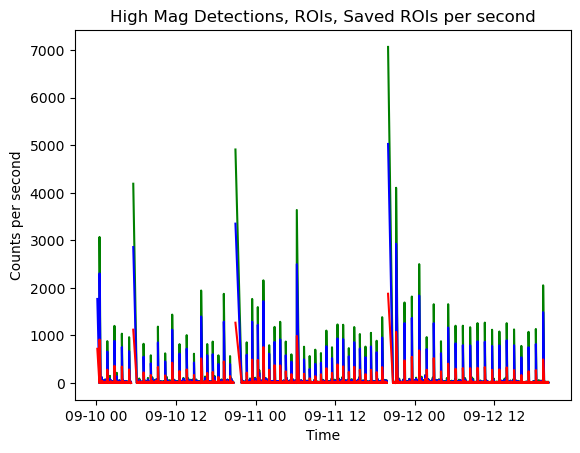

In [39]:
ll=cam_sums['highmag_detections (#/s)']<0
cam_sums.loc[ll,'highmag_detections (#/s)']=np.nan
plt.plot(cam_sums['highmag_detections (#/s)'],'g')
plt.plot(cam_sums['highmag_rois (#/s)'],'b')
plt.plot(cam_sums['highmag_saved_rois (#/s)'],'r')
plt.title('High Mag Detections, ROIs, Saved ROIs per second')
plt.xlabel('Time')
plt.ylabel('Counts per second')
plt.savefig(fig_dir / 'LRAUV_April2025_HighMag_Detections_ROIs_SavedROIs_perSecond.png')
#plt.ylim(0,20)


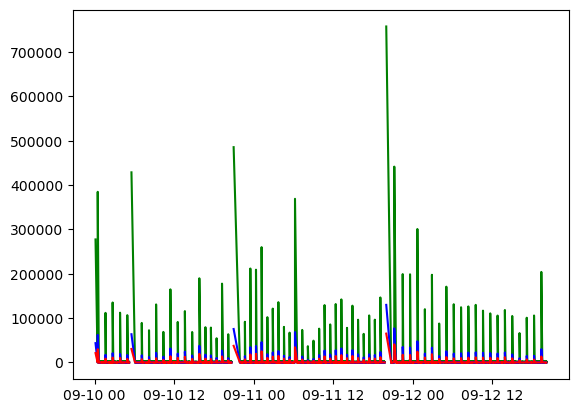

In [40]:
ll=cam_sums['lowmag_detections (#/s)']<0
cam_sums.loc[ll,'lowmag_detections (#/s)']=np.nan
plt.plot(cam_sums['lowmag_detections (#/s)'],'g')
plt.plot(cam_sums['lowmag_rois (#/s)'],'b')
plt.plot(cam_sums['lowmag_saved_rois (#/s)'],'r')


## Load LRAUV Data

These data are found as netcdf files on the Research Workspace:

`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504142054_202504150400_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504150400_202504152346_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504152347_202504160013_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160014_202504160017_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160018_202504181753_2S_scieng.nc`


__Goal__: Align the datetime from planktivore images to the LRAUV CTD Data (with some type of tolerance)

In [ ]:
#interval_index=counts.index.categories.rename('time_interval')
#interval_index_cam=cam_counts.index.rename('time_interval')
#x_pos1=interval_index.left
#y_pos1=counts.values
#x_pos2=interval_index_cam.left
#y_pos2=cam_counts.values
##plt.plot(x_pos1,y_pos1,'b.-')
#plt.plot(y_pos1,'b')
#plt.plot(y_pos2,'r')
##plt.plot(x_pos2,y_pos2,'r.-') # do the zeros on this plot correspond to times when the camera was off?
##plt.xlabel('Time')
##plt.xlim(60000,80000)
#plt.ylabel('Counts')
#plt.ylim(-2,40)
##print(cam_counts.shape)
##print(bins.shape)

In [ ]:
## How do we define no camera ROIs vs planktivore not running and thus no ROIs?
## We want to put NaN vs 0.


#edges = pd.to_datetime(labeled.index).sort_values().unique()
#
## build interval bins [start, end)
#bins = pd.IntervalIndex.from_breaks(edges, closed="left")
## assign each event to a bin
#bin_codes = pd.cut(df["dateTime"], bins=bins, right=False)
## count events per bin (this keeps the IntervalIndex)
#counts = df.groupby(bin_codes).size()

## reindex so we also get zeros for bins with no events
## This is where we need to make sure if it is a true zero or an NaN.  We cannot assume that the value is zero.
## NEED NEW CODE HERE TO DISTINGUISH BETWEEN 0 AND NaN

#counts = counts.reindex(bins, fill_value=0)

## map interval index to left edge (the "stime")
#counts.index = counts.index.left

## align back to labeled.index (so last row is also included with 0)
#labeled["rois_count"] = counts.reindex(labeled.index, fill_value=0).astype(int)

In [41]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'bin_mean_mass_concentration_of_chlorophyll_in_sea_water',
       'bin_median_mass_concentration_of_chlorophyll_in_sea_water',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km', 'rois_count', 'highmag_detections',
       'highmag_rois', 'highmag_saved_rois', 'highmag_average_area'],
      dtype='object')

In [ ]:
#uid=34
#test=labeled['cast_id']==uid
#onecast=labeled[test]
#onecast.keys()

In [ ]:
## This is to get the time values for a profile that had roi count of zero
#junk=onecast.index
#junk=junk.astype(np.int64)
#print(junk)
#print(type(junk))
##print(np.max(test))
##print(np.min(test))

In [ ]:
#uid=np.unique(labeled['cast_id'])
#
#lids=np.arange(0,len(uid))
#for cast in lids:
#    cid=uid[cast]
#    cindex=np.where(labeled['cast_id']==cid)
#    tmpc=labeled['rois_count'].iloc[cindex[0]]
#    tmpd=labeled['depth'].iloc[cindex[0]]
#    plt.plot(labeled['rois_count'].iloc[cindex[0]],labeled['depth'].iloc[cindex[0]])
#    plt.ylim(labeled['depth'].iloc[cindex[0]].max(),labeled['depth'].iloc[cindex[0]].min())
#    plt.title('cast id '+str(cid))
#    #plt.show()
#    plt.savefig('./cast_plots/cast_'+str(uid[cast])+'_rois.jpg')
#    plt.clf()

In [ ]:
# check cast 30, 57,70,2,117,126 
#cid=uid[cast]
#cid=126
#cindex=np.where((labeled['cast_id']==cid)&(labeled['phase']=='up'))
#tmpc=labeled['rois_count'][cindex[0]]
#tmpd=labeled['depth'][cindex[0]]
#plt.plot(labeled['rois_count'][cindex[0]],labeled['depth'][cindex[0]])
#plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#plt.title('cast id '+str(cid))


In [ ]:
## casts to drop due to planktivore not running and ROI counts zero for all or part of profile
#casttodrop=[1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,30,31,31,32,32,33,33,34,34,35,35,57,70,82,93,93,94,94,95,95,96,96,97,97,98,98,112,112,113,113,114,114,115,115,116,116,117,126]
#phasetodrop=['down','up','down','up','down','up','down','up','down','up', # 1,2,3,4,5
#             'down','up','down','up','down','up','down','up','down','up', # 6,7,8,9,10
#             'down','up','down','up','up','down','up','down','up','down','up', # 11,12,30,31,32,33
#             'down','up','down','up','up','up','up','down','up','down','up','down','up', #34,35,57,70,82,93,94,95
#             'down','up','down','up','down','up','down','up','down','up','down','up', #96,97,98,112,113,114
#             'down','up','down','up','down','down'] # 115,116,117,126
#ldr=np.arange(0,len(casttodrop))
##print(len(phasetodrop))
#for dropit in ldr:
#    condition_to_drop=(labeled['cast_id']==casttodrop[dropit])&(labeled['phase']==phasetodrop[dropit])
#    labeled=labeled[~condition_to_drop]

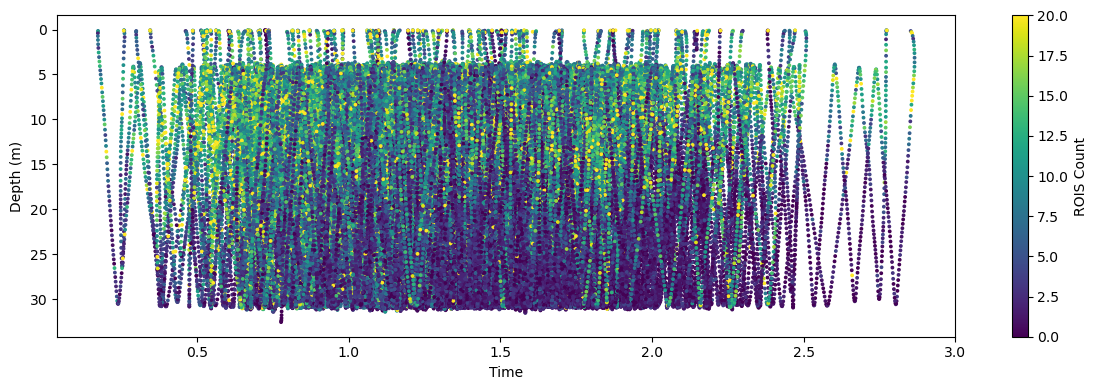

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    labeled.distance_km,labeled['depth'], c=labeled['rois_count'], s=3)
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()

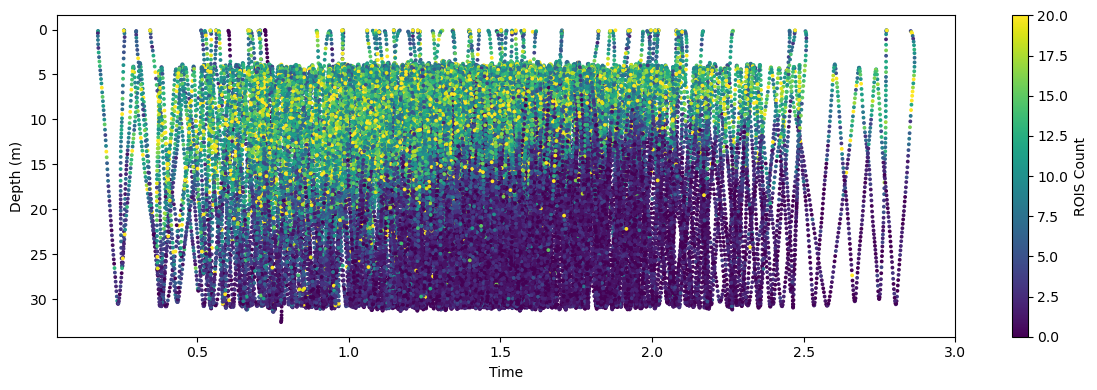

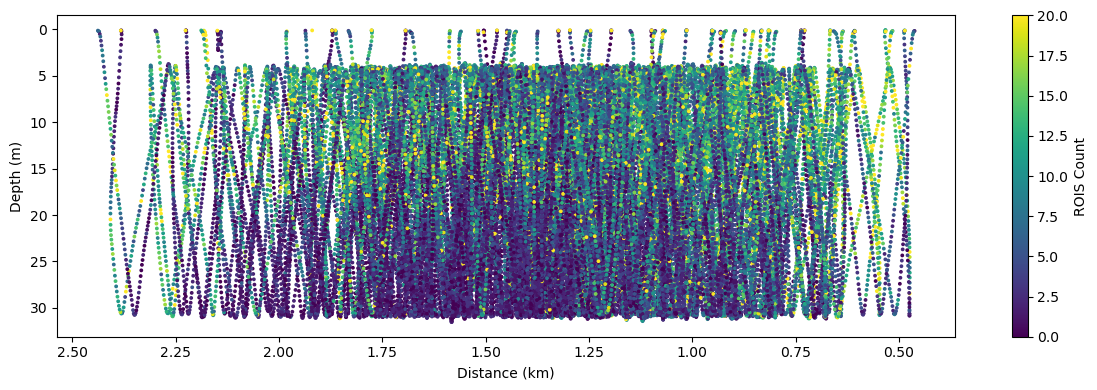

In [44]:
out_trans = labeled.iloc[:65000]
in_trans = labeled.iloc[65000:]


fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    out_trans.distance_km,out_trans['depth'], c=out_trans['rois_count'],s=3)
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()
plt.savefig('ROI_count_outbound_CANON_Sept2025.jpg',dpi=300)

fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    in_trans.distance_km,in_trans['depth'], c=in_trans['rois_count'],s=3)
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()
plt.savefig('ROI_count_inbound_CANON_Sept2025.jpg',dpi=300)

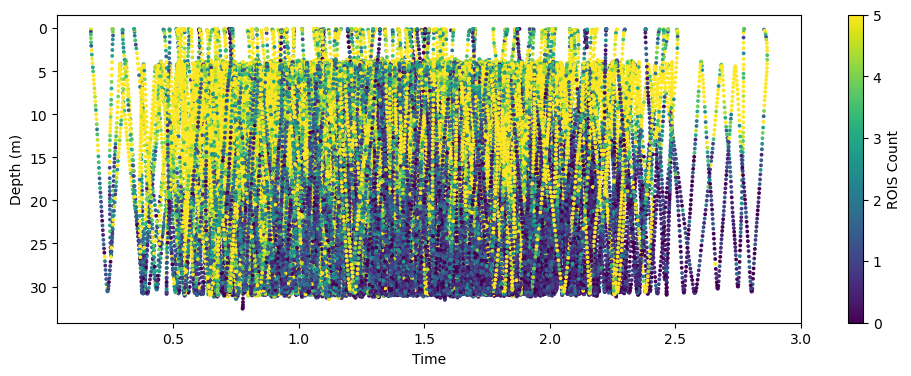

In [ ]:
# Elapsed time (s) between current index and next one, starting at index 0
elapsed_seconds = (
    labeled.index.to_series()
    .diff()
    .dt.total_seconds()
    .shift(-1)        # shift so first interval is at position 0
    .astype('Int64')
)

# Timedelta differences as integer seconds (nullable Int64 keeps the first NA)

labeled['rois_norm'] = labeled['rois_count'] / elapsed_seconds
#out_trans = labeled.iloc[:65000]
#in_trans = labeled.iloc[65000:]
#
#
fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    labeled.distance_km,labeled['depth'], c=labeled['rois_norm'],s=3)
sc.set_clim(0, 5)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
## plt.title('LRAUV Optical Backscatter (470nm) April 2025')
#plt.tight_layout()
#
#fig, ax = plt.subplots(figsize=(12, 4))
#sc = ax.scatter(
#    labeled.distance_km,labeled['depth'], c=labeled['rois_norm'],s=3)
#sc.set_clim(0, 5)
#ax.invert_yaxis()
#ax.invert_xaxis()
#ax.set_ylabel('Depth (m)')
#ax.set_xlabel('Distance (km)')
#plt.colorbar(sc, label='ROIS Count')
## plt.title('LRAUV Optical Backscatter (470nm) April 2025')
#plt.tight_layout()


## Add Inference Data to Profiles

This is the same tedious step, find the time bounds of each samples

In [46]:
import pandas as pd

# Your target labels
labels = [
 'Akashiwo',
 'Amphidinium_Oxyphysis',
 'Ceratium',
 'Chaetoceros',
 'Ciliate',
 'Cylindrotheca',
 'Detonula_Cerataulina_Lauderia',
 'Detritus',
 'Dictyocha',
 'Dinoflagellate',
 'Eucampia',
 'Guinardia_Dactyliosolen',
 'Gyrodinium',
 'Medium_pennate',
 'Mesodinium',
 'Mixed_diatom_chain',
 'Nano_plankton',
 'Polykrikos',
 'Prorocentrum',
 'Pseudo-nitzschia',
 'Strombidium',
 'Thalassionema',
 'Thalassiosira',
 'Tiarina',
 'Truncated',
 'unknown_flagellate'
]

# Suppose your dataframe has a 'label' column
# Example: counts = df['label'].value_counts()
#counts = inference["label1"].value_counts()
counts = inference_filtered["label1"].value_counts()

# Reindex with your full list and fill missing with zero
counts = counts.reindex(labels, fill_value=0)

# Optionally make it a DataFrame
label_counts = counts.reset_index()
label_counts.columns = ["label", "count"]

print(label_counts)

                            label   count
0                        Akashiwo    3994
1           Amphidinium_Oxyphysis   13942
2                        Ceratium   20391
3                     Chaetoceros   90944
4                         Ciliate   22602
5                   Cylindrotheca  254099
6   Detonula_Cerataulina_Lauderia    4141
7                        Detritus   20014
8                       Dictyocha   11439
9                  Dinoflagellate   90315
10                       Eucampia    2285
11        Guinardia_Dactyliosolen   45645
12                     Gyrodinium    2270
13                 Medium_pennate    8656
14                     Mesodinium    1536
15             Mixed_diatom_chain    6510
16                  Nano_plankton   54322
17                     Polykrikos    3220
18                   Prorocentrum    3065
19               Pseudo-nitzschia   44272
20                    Strombidium   26092
21                  Thalassionema   30913
22                  Thalassiosira 

In [47]:
# --- Assumptions ---
# labeled.index: strictly increasing, unique DatetimeIndex (bin edges)
# inference: columns ['dateTime', 'label1'] ; dateTime is datetime64
# all_labels: list of label names (columns order you want)

# 0) Ensure types
edges = pd.to_datetime(labeled.index).sort_values().unique()
# original code
#inference = inference.copy()
#inference["dateTime"] = pd.to_datetime(inference["dateTime"])
#inference["label1"] = pd.Categorical(inference["label1"], categories=all_labels)
inference_filtered = inference_filtered.copy()
inference_filtered["dateTime"] = pd.to_datetime(inference_filtered["dateTime"])
inference_filtered["label1"] = pd.Categorical(inference_filtered["label1"], categories=all_labels)

# 1) Build left-closed, right-open bins: [start, end)
bins = pd.IntervalIndex.from_breaks(edges, closed="left")

# 2) Bin events
#binned = pd.cut(inference["dateTime"], bins=bins, right=False) # original code
binned = pd.cut(inference_filtered["dateTime"], bins=bins, right=False)

# 3) Count per interval × label (use observed=True to avoid the FutureWarning)
# original code
#counts = (
#    inference.groupby([binned, "label1"], observed=True)
#    .size()
#    .unstack("label1", fill_value=0)
#    .reindex(columns=all_labels, fill_value=0)
#)
counts = (
    inference_filtered.groupby([binned, "label1"], observed=True)
    .size()
    .unstack("label1", fill_value=0)
    .reindex(columns=all_labels, fill_value=0)
)

# 4) Ensure **every** interval is present (even empty ones)
counts = counts.reindex(bins, fill_value=0)

# 5) Replace IntervalIndex with its left edge (DatetimeIndex)
counts.index = counts.index.left  # -> Interval start time

# 6) Compute elapsed seconds for each interval (aligned to left edge)
dt = pd.Series(edges, index=edges)            # helpful alignment
elapsed_seconds = (dt.shift(-1) - dt).dt.total_seconds()
elapsed_seconds = elapsed_seconds.loc[counts.index]  # align to left edges

# 7) Rates (counts per second): last bin has NaN duration → fill with 0 later
rates = counts.div(elapsed_seconds, axis=0)

# 8) Join into labeled by left edge, zero-fill where missing
# (This preserves your original labeled rows, including the last edge)
labeled = labeled.join(counts, how="left", rsuffix="_count")
# Do we really want to fill with 0s here?  Maybe NaN is better to indicate no data?
#labeled = labeled.fillna(0)

# 9) If you also want the rates joined (optional):
rate_cols = [f"{c}_rate" for c in counts.columns]
rates.columns = rate_cols
# Again not sure we want to fill in with 0s here.  Maybe NaN is better.
#labeled = labeled.join(rates, how="left").fillna(0)

In [48]:
all_labels

['Akashiwo',
 'Amphidinium_Oxyphysis',
 'Ceratium',
 'Chaetoceros',
 'Ciliate',
 'Cylindrotheca',
 'Detonula_Cerataulina_Lauderia',
 'Detritus',
 'Dictyocha',
 'Dinoflagellate',
 'Eucampia',
 'Guinardia_Dactyliosolen',
 'Gyrodinium',
 'Medium_pennate',
 'Mesodinium',
 'Mixed_diatom_chain',
 'Nano_plankton',
 'Polykrikos',
 'Prorocentrum',
 'Pseudo-nitzschia',
 'Strombidium',
 'Thalassionema',
 'Thalassiosira',
 'Tiarina',
 'Truncated',
 'unknown_flagellate']

In [49]:
# Checkpoint
labeled.to_parquet("c:/planktivore/lrauv_sept2025_with_class_20251009model_filtered_addNaN.parquet")